<div align="center">
  <strong style="font-size:24px;">Model CLARA-FTSMC Indeks BRENT</strong>
</div>

# Step 1: Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

# Step 2: Import Dataset

In [2]:
df = pd.read_csv("Brent Oil Futures Historical Data.csv")
df

Date  Price   Open   High    Low     Vol. Change %
0     07/31/2025  72.53  73.53  73.53  72.40   16.02K   -0.97%
1     07/30/2025  73.24  72.57  73.63  71.75  111.92K    1.01%
2     07/29/2025  72.51  70.28  73.08  69.86  136.65K    3.53%
3     07/28/2025  70.04  68.54  70.45  68.35  203.44K    2.34%
4     07/25/2025  68.44  69.36  69.86  68.31  166.66K    0.12%
...          ...    ...    ...    ...    ...      ...      ...
1286  08/07/2020  44.40  45.15  45.30  44.27  171.72K   -1.53%
1287  08/06/2020  45.09  45.32  45.71  44.85  184.52K   -0.18%
1288  08/05/2020  45.17  44.28  46.23  44.24  246.98K    1.67%
1289  08/04/2020  44.43  43.84  44.82  43.24  227.12K    0.63%
1290  08/03/2020  44.15  43.53  44.46  42.89  198.70K    1.96%

[1291 rows x 7 columns]

# Step 3: Data Prepocessing

In [3]:
# Hapus Kolom yang tidak digunakan
df = df.drop(columns=["Open","High","Low","Vol.","Change %"])

In [4]:
# Ubah Kolom Date Menjadi Datetime
df["Date"]=pd.to_datetime(df["Date"])

In [5]:
# Sort data berdasarkan Date dan reset index data
df = df.sort_values(by='Date', ascending=True).reset_index(drop=True)

In [6]:
df

Date  Price
0    2020-08-03  44.15
1    2020-08-04  44.43
2    2020-08-05  45.17
3    2020-08-06  45.09
4    2020-08-07  44.40
...         ...    ...
1286 2025-07-25  68.44
1287 2025-07-28  70.04
1288 2025-07-29  72.51
1289 2025-07-30  73.24
1290 2025-07-31  72.53

[1291 rows x 2 columns]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1291 entries, 0 to 1290
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1291 non-null   datetime64[ns]
 1   Price   1291 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 20.3 KB


# Step 4: Exploratory Data Analysis (EDA)

In [8]:
# Deskripsi Data
df.describe()

Date        Price
count                           1291  1291.000000
mean   2023-01-30 16:21:33.880712704    78.311650
min              2020-08-03 00:00:00    37.460000
25%              2021-11-01 12:00:00    71.055000
50%              2023-01-31 00:00:00    78.360000
75%              2024-05-01 12:00:00    85.885000
max              2025-07-31 00:00:00   127.980000
std                              NaN    16.100662

In [9]:
# Plot Data
plt.figure(figsize=(20, 6))
df.plot(x="Date", y='Price', kind='line', color='purple')
plt.title('Brent Oil Indeks Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

<Figure size 2000x600 with 0 Axes>

# Step 5: Build Model CLARA-FTSMC

## 5.1. Persiapan Data

In [10]:
# 1. DATA SPLITTING (80% Training, 20% Testing)

split_ratio = 0.8
split_index = int(len(df) * split_ratio)

df_train = df.iloc[:split_index].copy().reset_index(drop=True)
df_test = df.iloc[split_index:].copy().reset_index(drop=True)

print(f"\n{'='*70}")
print("📊 DATA SPLITTING STRATEGY")
print(f"{'='*70}")
print(f"Total Data Points    : {len(df)}")
print(f"Training Set (80%)   : {len(df_train)} records")
print(f"  └─ Date Range      : {df_train['Date'].min()} to {df_train['Date'].max()}")
print(f"Testing Set (20%)    : {len(df_test)} records")
print(f"  └─ Date Range      : {df_test['Date'].min()} to {df_test['Date'].max()}")
print(f"{'='*70}\n")


📊 DATA SPLITTING STRATEGY
Total Data Points    : 1291
Training Set (80%)   : 1032 records
  └─ Date Range      : 2020-08-03 00:00:00 to 2024-07-30 00:00:00
Testing Set (20%)    : 259 records
  └─ Date Range      : 2024-07-31 00:00:00 to 2025-07-31 00:00:00



In [11]:
# 2. NORMALISASI (HANYA DARI TRAINING DATA)

features = ['Price']
X_train = df_train[features].values
X_test = df_test[features].values
# PENTING: Fit scaler HANYA pada training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Transform menggunakan parameter dari training

feature_ranges_training = [(X_train_scaled[:, i].min(), X_train_scaled[:, i].max()) 
                  for i in range(X_train_scaled.shape[1])]
feature_ranges_testing = [(X_test_scaled[:, i].min(), X_test_scaled[:, i].max()) 
                  for i in range(X_test_scaled.shape[1])]

print("✅ Normalization Complete (using training data statistics)")
print(f"\nTraining - Mean: {X_train_scaled[:, 0].mean():.10f}, Std: {X_train_scaled[:, 0].std():.4f}")
print(f"Feature ranges Training: {feature_ranges_training}\n")
print(f"\nTesting  - Mean: {X_test_scaled[:, 0].mean():.10f}, Std: {X_test_scaled[:, 0].std():.4f}")
print(f"Feature ranges Testing: {feature_ranges_testing}\n")

✅ Normalization Complete (using training data statistics)

Training - Mean: 0.0000000000, Std: 1.0000
Feature ranges Training: [(-2.4186652442853105, 2.7491944532213526)]


Testing  - Mean: -0.4307237261, Std: 0.2747
Feature ranges Testing: [(-1.1187076071639375, 0.14128646623389784)]



In [12]:
plt.figure(figsize=(10, 6))

# Plot Training data
plt.plot(df_train['Date'], df_train['Price'], 
         color='purple', label='Training Data')

# Plot Testing data
plt.plot(df_test['Date'], df_test['Price'], 
         color='orange', label='Testing Data')

# Garis vertikal batas split
split_date = df_test['Date'].iloc[0]
plt.axvline(split_date, color='black', linestyle='--', linewidth=2)

# Title dan dekorasi
plt.title('Brent Oil Indeks Price (Training vs Testing)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()

plt.show()

## 5.2. Clustering Large Application (Using Gap Statistic for Optimal Cluster)

### 5.2.1 Input Parameter Awal

In [13]:
# Parameter Gap Statistic
k_max = 20
B = 100
sample_size_base = 40

print(f"⚙️ Gap Statistics Parameters:")
print(f"  k_max = {k_max}")
print(f"  Bootstrap samples (B) = {B}")

⚙️ Gap Statistics Parameters:
  k_max = 20
  Bootstrap samples (B) = 100


### 5.2.2 Hitung W_k Untuk Data Training

In [14]:
def calculate_wk_clara(X, k, sample_size, n_samples=5, random_state=42):
    """
    Hitung Within-cluster Sum of Squares (W_k) menggunakan CLARA.
    CLARA = Clustering LARge Applications (menggunakan sampling + PAM)
    - Menjalankan PAM pada beberapa sample (default = 5)
    - Memilih model dengan inertia terkecil.
    """
    np.random.seed(random_state)
    best_inertia = np.inf
    best_model = None

    for s in range(n_samples):
        # Ambil random sample
        sample_idx = np.random.choice(len(X), size=min(sample_size, len(X)), replace=False)
        X_sample = X[sample_idx]

        # Jalankan PAM (KMedoids)
        kmedoids = KMedoids(
            n_clusters=k,
            method='pam',
            init='k-medoids++',
            max_iter=300,
            random_state=random_state + s
        )
        kmedoids.fit(X_sample)

        # Prediksi seluruh data (label berdasarkan medoid terdekat)
        labels = kmedoids.predict(X)

        # Hitung inertia (W_k) untuk seluruh data
        inertia = 0
        for i in range(k):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                medoid = kmedoids.cluster_centers_[i]
                inertia += np.sum((cluster_points - medoid) ** 2)

        # Simpan hasil terbaik (inertia terkecil)
        if inertia < best_inertia:
            best_inertia = inertia
            best_model = kmedoids

    return best_inertia, best_model

In [15]:
wk_values = []
log_wk_values = []
clara_models = []

print("\n📈 Computing W_k for original data using CLARA:")
for k in range(1, k_max + 1):
    sample_size = 40 + 2 * k  # sesuai aturan CLARA
    wk, clara_model = calculate_wk_clara(X_train_scaled, k=k, sample_size=sample_size, n_samples=5)
    wk_values.append(wk)
    log_wk_values.append(np.log(wk))
    clara_models.append(clara_model)
    print(f"k={k:2d}  →  W_k={wk:8.4f}  →  log(W_k)={np.log(wk):7.4f}")


📈 Computing W_k for original data using CLARA:
k= 1  →  W_k=1560.4995  →  log(W_k)= 7.3528
k= 2  →  W_k=466.8335  →  log(W_k)= 6.1460
k= 3  →  W_k=191.1700  →  log(W_k)= 5.2532
k= 4  →  W_k=105.3746  →  log(W_k)= 4.6575
k= 5  →  W_k= 72.7024  →  log(W_k)= 4.2864
k= 6  →  W_k= 47.5793  →  log(W_k)= 3.8624
k= 7  →  W_k= 44.4604  →  log(W_k)= 3.7946
k= 8  →  W_k= 27.3335  →  log(W_k)= 3.3081
k= 9  →  W_k= 29.0047  →  log(W_k)= 3.3675
k=10  →  W_k= 21.6057  →  log(W_k)= 3.0730
k=11  →  W_k= 18.0463  →  log(W_k)= 2.8929
k=12  →  W_k= 14.7932  →  log(W_k)= 2.6942
k=13  →  W_k= 11.9001  →  log(W_k)= 2.4765
k=14  →  W_k=  9.9076  →  log(W_k)= 2.2933
k=15  →  W_k=  9.3735  →  log(W_k)= 2.2379
k=16  →  W_k=  7.4367  →  log(W_k)= 2.0064
k=17  →  W_k=  6.8781  →  log(W_k)= 1.9283
k=18  →  W_k=  6.8364  →  log(W_k)= 1.9223
k=19  →  W_k=  6.2775  →  log(W_k)= 1.8370
k=20  →  W_k=  5.8529  →  log(W_k)= 1.7669


### 5.2.3 Hitung W_kb, Sd,dan S_k untuk data referensi (Bootstarp)

In [16]:
def generate_reference_data(n_samples, feature_ranges):
    """Generate dataset referensi acak"""
    n_features = len(feature_ranges)
    X_ref = np.zeros((n_samples, n_features))
    
    for i in range(n_features):
        min_val, max_val = feature_ranges[i]
        X_ref[:, i] = np.random.uniform(min_val, max_val, n_samples)
    
    return X_ref

In [17]:
log_wk_star = np.zeros((k_max, B))
n_samples = X_train_scaled.shape[0]

print(f"\n🔄 Computing reference distributions (B={B} iterations):")
for k in range(1, k_max + 1):
    print(f"-Processing k={k}... ", end="", flush=True)

    for b in range(B):
        X_ref = generate_reference_data(n_samples, feature_ranges_training)
        wk_star, _ = calculate_wk_clara(X_ref, k=k, sample_size=sample_size)
        log_wk_star[k-1, b] = np.log(wk_star)
    
    print("✓")


🔄 Computing reference distributions (B=100 iterations):
✓Processing k=1... 
✓Processing k=2... 
✓Processing k=3... 
✓Processing k=4... 
✓Processing k=5... 
✓Processing k=6... 
✓Processing k=7... 
✓Processing k=8... 
✓Processing k=9... 
✓Processing k=10... 
✓Processing k=11... 
✓Processing k=12... 
✓Processing k=13... 
✓Processing k=14... 
✓Processing k=15... 
✓Processing k=16... 
✓Processing k=17... 
✓Processing k=18... 
✓Processing k=19... 
✓Processing k=20... 


In [18]:
# Hitung statistik dasar
E_log_wk_star = log_wk_star.mean(axis=1)
sd_k = log_wk_star.std(axis=1)
s_k = sd_k * np.sqrt(1 + 1/B)

# Hitung juga nilai rata-rata Wk* (bukan log)
E_wk_star = np.exp(E_log_wk_star)

# Buat DataFrame lengkap untuk statistik
gap_stats_df = pd.DataFrame({
    'k': range(1, k_max + 1),
    'W_k* (mean)': E_wk_star,
    'log(W_k*) (mean)': E_log_wk_star,
    'sd_k': sd_k,
    's_k': s_k
})

print("\n" + "="*100)
print("📊 GAP STATISTIC SUMMARY (with W_k* and log(W_k*))")
print("="*100)

# Versi compact (dibulatkan agar mudah dibaca)
gap_stats_compact = pd.DataFrame({
    'k': range(1, k_max + 1),
    'W_k* (mean)': [f"{val:.4f}" for val in E_wk_star],
    'log(W_k*) (mean)': [f"{val:.6f}" for val in E_log_wk_star],
    'sd_k': [f"{val:.3e}" for val in sd_k],
    's_k': [f"{val:.3e}" for val in s_k]
})

print(gap_stats_compact.to_string(index=False))
print("="*100)


📊 GAP STATISTIC SUMMARY (with W_k* and log(W_k*))
 k W_k* (mean) log(W_k*) (mean)      sd_k       s_k
 1   2255.6779         7.721206 8.882e-16 8.926e-16
 2    569.5843         6.344907 8.882e-16 8.926e-16
 3    289.7639         5.669066 1.776e-15 1.785e-15
 4    151.0842         5.017837 0.000e+00 0.000e+00
 5    100.8699         4.613831 0.000e+00 0.000e+00
 6     71.3087         4.267019 1.776e-15 1.785e-15
 7     53.7480         3.984306 4.441e-16 4.463e-16
 8     36.2340         3.589998 8.882e-16 8.926e-16
 9     30.7793         3.426842 1.332e-15 1.339e-15
10     27.7738         3.324095 4.441e-16 4.463e-16
11     22.3327         3.106053 1.332e-15 1.339e-15
12     17.5228         2.863502 8.882e-16 8.926e-16
13     14.4335         2.669554 8.882e-16 8.926e-16
14     13.3206         2.589308 0.000e+00 0.000e+00
15     11.3862         2.432405 0.000e+00 0.000e+00
16     10.4235         2.344059 8.882e-16 8.926e-16
17      9.3490         2.235266 8.882e-16 8.926e-16
18      7.995

### 5.2.4 Hitung Gap Statistic

In [19]:
gap_k = E_log_wk_star - np.array(log_wk_values)

# Tampilkan tabel
results_df = pd.DataFrame({
    'k': range(1, k_max + 1),
    'log(W_k)': log_wk_values,
    'E{log(W_k*)}': E_log_wk_star,
    'Gap(k)': gap_k,
    's_k': s_k
})

print("\n" + "=" * 60)
print("Gap Statistic Results (using CLARA):")
print("=" * 60)
print(results_df.to_string(index=False))


Gap Statistic Results (using CLARA):
 k  log(W_k)  E{log(W_k*)}   Gap(k)          s_k
 1  7.352761      7.721206 0.368445 8.926083e-16
 2  6.145973      6.344907 0.198934 8.926083e-16
 3  5.253163      5.669066 0.415903 1.785217e-15
 4  4.657522      5.017837 0.360315 0.000000e+00
 5  4.286374      4.613831 0.327457 0.000000e+00
 6  3.862398      4.267019 0.404621 1.785217e-15
 7  3.794600      3.984306 0.189706 4.463041e-16
 8  3.308111      3.589998 0.281886 8.926083e-16
 9  3.367458      3.426842 0.059384 1.338912e-15
10  3.072955      3.324095 0.251140 4.463041e-16
11  2.892942      3.106053 0.213111 1.338912e-15
12  2.694166      2.863502 0.169335 8.926083e-16
13  2.476544      2.669554 0.193010 8.926083e-16
14  2.293305      2.589308 0.296003 0.000000e+00
15  2.237888      2.432405 0.194517 0.000000e+00
16  2.006422      2.344059 0.337638 8.926083e-16
17  1.928341      2.235266 0.306925 8.926083e-16
18  1.922262      2.078871 0.156608 0.000000e+00
19  1.836973      1.994780 0.15

### 5.2.5 Tentukan k Optimal

In [20]:
k_optimal = None
print(f"\n{'k':<5} {'Gap(k)':<12} {'Gap(k+1)-s(k+1)':<18} {'Criterion':<12}")
print("-" * 50)

for k in range(1, k_max):
    gap_current = gap_k[k-1]
    gap_next_minus_s = gap_k[k] - s_k[k]
    meets_criteria = gap_current >= gap_next_minus_s

    print(f"{k:<5} {gap_current:<12.4f} {gap_next_minus_s:<18.4f} {'✓ YES' if meets_criteria else '✗ NO':<12}")

    # Pilih k pertama yang memenuhi kriteria (tanpa batas minimal)
    if meets_criteria and k_optimal is None:
        k_optimal = k

# Jika tidak ada k yang memenuhi kriteria
if k_optimal is None:
    # Pilih k dengan Gap tertinggi (tanpa batasan)
    k_optimal = np.argmax(gap_k) + 1
    print(f"\n⚠️  No k meets criterion. Selecting k = {k_optimal} with highest Gap.")

print(f"\n🎯 OPTIMAL k = {k_optimal} (determined using Gap Statistic)")
print(f"   Gap({k_optimal}) = {gap_k[k_optimal-1]:.4f}")


k     Gap(k)       Gap(k+1)-s(k+1)    Criterion   
--------------------------------------------------
1     0.3684       0.1989             ✓ YES       
2     0.1989       0.4159             ✗ NO        
3     0.4159       0.3603             ✓ YES       
4     0.3603       0.3275             ✓ YES       
5     0.3275       0.4046             ✗ NO        
6     0.4046       0.1897             ✓ YES       
7     0.1897       0.2819             ✗ NO        
8     0.2819       0.0594             ✓ YES       
9     0.0594       0.2511             ✗ NO        
10    0.2511       0.2131             ✓ YES       
11    0.2131       0.1693             ✓ YES       
12    0.1693       0.1930             ✗ NO        
13    0.1930       0.2960             ✗ NO        
14    0.2960       0.1945             ✓ YES       
15    0.1945       0.3376             ✗ NO        
16    0.3376       0.3069             ✓ YES       
17    0.3069       0.1566             ✓ YES       
18    0.1566       0.1578     

In [21]:
plt.figure(figsize=(10, 6))
k_range = range(1, k_max)
gap_current = gap_k[:-1]
gap_next_minus_s = gap_k[1:] - s_k[1:]

plt.plot(k_range, gap_current, 'o-', linewidth=2, markersize=8, color='#4A4E69', label='Gap(k)')
plt.plot(k_range, gap_next_minus_s, 's-', linewidth=2, markersize=8, color='#F2CC8F', label='Gap(k+1) - s(k+1)')

for k in k_range:
    if gap_current[k-1] >= gap_next_minus_s[k-1]:
        plt.plot(k, gap_current[k-1], 'g*', markersize=15)
        if k == k_optimal:
            plt.annotate(f'k={k}\n(Optimal)', xy=(k, gap_current[k-1]), 
                        xytext=(k+1, gap_current[k-1]+0.02),
                        fontsize=10, fontweight='bold', color='green',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7),
                        arrowprops=dict(arrowstyle='->', color='green', lw=1.5))

plt.axvline(x=k_optimal, color='red', linestyle='--', linewidth=2, alpha=0.5)
plt.xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
plt.ylabel('Gap Value', fontsize=12, fontweight='bold')
plt.title('Gap Statistic Criterion Check', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

In [22]:
# ================================
# Step 1: Gap Statistic memberikan kandidat
# ================================
valid_k_candidates = [3,4,6,8,10,11,14,16,17]

# ================================
# Step 2: Filter dengan constraint praktis
# ================================
min_k, max_k = 2, 20
filtered_k = [k for k in valid_k_candidates if min_k <= k <= max_k]

print(f"📋 Filtered k candidates: {filtered_k}")
print(f"   Total: {len(filtered_k)} values\n")

# ================================
# Step 3: Evaluasi dengan multiple metrics menggunakan CLARA
# ================================
results = []

print("🔄 Evaluating metrics for each k using CLARA...")
print("-" * 60)

for k in filtered_k:
    print(f"-Processing k={k}... ", end="", flush=True)
    
    # Gunakan CLARA (KMedoids dengan sampling untuk data besar)
    if len(X_train_scaled) > sample_size and k < len(X_train_scaled):
        np.random.seed(42)
        sample_idx = np.random.choice(len(X_train_scaled), size=sample_size, replace=False)
        X_sample = X_train_scaled[sample_idx]
        
        clara = KMedoids(n_clusters=k, method='pam', init='k-medoids++', 
                         max_iter=300, random_state=42)
        clara.fit(X_sample)
        labels = clara.predict(X_train_scaled)
    else:
        clara = KMedoids(n_clusters=k, method='pam', init='k-medoids++', 
                         max_iter=300, random_state=42)
        labels = clara.fit_predict(X_scaled)
    
    # Hitung metrics (hanya jika k > 1 untuk silhouette)
    if k > 1:
        sil_score = silhouette_score(X_train_scaled, labels)
        db_score = davies_bouldin_score(X_train_scaled, labels)
    else:
        sil_score = np.nan
        db_score = np.nan
    
    results.append({
        'k': k,
        'gap': gap_k[k-1],
        'silhouette': sil_score,
        'davies_bouldin': db_score
    })
    
    print("✓")

# Ubah ke DataFrame untuk tampilan rapi
df_metrics = pd.DataFrame(results)
print("\n✅ Processing Complete!")

📋 Filtered k candidates: [3, 4, 6, 8, 10, 11, 14, 16, 17]
   Total: 9 values

🔄 Evaluating metrics for each k using CLARA...
------------------------------------------------------------
✓Processing k=3... 
✓Processing k=4... 
✓Processing k=6... 
✓Processing k=8... 
✓Processing k=10... 
✓Processing k=11... 
✓Processing k=14... 
✓Processing k=16... 
✓Processing k=17... 

✅ Processing Complete!


In [23]:
# ================================
# Gap Statistic Table
# ================================
print("\n" + "=" * 60)
print("📊 GAP STATISTIC VALUES")
print("=" * 60)

gap_table = df_metrics[['k', 'gap']].copy()
gap_table = gap_table.sort_values('k')

print(gap_table.to_string(index=False, float_format='%.4f'))

best_gap_k = df_metrics.loc[df_metrics['gap'].idxmax(), 'k']
max_gap = df_metrics['gap'].max()

print(f"\n🔹 Highest Gap Statistic: k = {best_gap_k} (Gap = {max_gap:.4f})")
print("=" * 60)


📊 GAP STATISTIC VALUES
 k    gap
 3 0.4159
 4 0.3603
 6 0.4046
 8 0.2819
10 0.2511
11 0.2131
14 0.2960
16 0.3376
17 0.3069

🔹 Highest Gap Statistic: k = 3 (Gap = 0.4159)


In [24]:
# ================================
# Gap Statistic Visualization
# ================================
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_metrics['k'], df_metrics['gap'], 'bo-', linewidth=2, markersize=8)
plt.axvline(x=best_gap_k, color='r', linestyle='--', label=f'Best k = {best_gap_k}')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Gap Statistic', fontsize=12)
plt.title('Gap Statistic vs Number of Clusters', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
# ================================
# Silhouette Score Table
# ================================
print("\n" + "=" * 60)
print("📊 SILHOUETTE SCORE VALUES")
print("=" * 60)

df_valid = df_metrics[df_metrics['k'] > 1].copy()  # Exclude k=1
sil_table = df_valid[['k', 'silhouette']].copy()
sil_table = sil_table.sort_values('k')

print(sil_table.to_string(index=False, float_format='%.4f'))

best_sil_k = df_valid.loc[df_valid['silhouette'].idxmax(), 'k']
max_sil = df_valid['silhouette'].max()

print(f"\n🔹 Highest Silhouette Score: k = {best_sil_k} (Silhouette = {max_sil:.4f})")
print("\n📖 Interpretation:")
print("   > 0.7  = Strong structure")
print("   0.5-0.7 = Reasonable structure")
print("   < 0.5  = Weak structure")
print("=" * 60)


📊 SILHOUETTE SCORE VALUES
 k  silhouette
 3      0.4749
 4      0.5775
 6      0.5566
 8      0.5409
10      0.5489
11      0.5443
14      0.5271
16      0.5095
17      0.5126

🔹 Highest Silhouette Score: k = 4 (Silhouette = 0.5775)

📖 Interpretation:
   > 0.7  = Strong structure
   0.5-0.7 = Reasonable structure
   < 0.5  = Weak structure


In [26]:
# ================================
# Silhouette Score Visualization
# ================================
plt.figure(figsize=(10, 6))
plt.plot(df_valid['k'], df_valid['silhouette'], 'go-', linewidth=2, markersize=8)
plt.axvline(x=best_sil_k, color='r', linestyle='--', label=f'Best k = {best_sil_k}')
plt.axhline(y=0.7, color='g', linestyle=':', alpha=0.5, label='Strong (>0.7)')
plt.axhline(y=0.5, color='orange', linestyle=':', alpha=0.5, label='Reasonable (>0.5)')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score vs Number of Clusters', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
# ================================
# Davies-Bouldin Index Table
# ================================
print("\n" + "=" * 60)
print("📊 DAVIES-BOULDIN INDEX VALUES")
print("=" * 60)

db_table = df_valid[['k', 'davies_bouldin']].copy()
db_table = db_table.sort_values('k')

print(db_table.to_string(index=False, float_format='%.4f'))

best_db_k = df_valid.loc[df_valid['davies_bouldin'].idxmin(), 'k']
min_db = df_valid['davies_bouldin'].min()

print(f"\n🔹 Lowest Davies-Bouldin Index: k = {best_db_k} (DB = {min_db:.4f})")
print("\n📖 Interpretation:")
print("   Lower values indicate better cluster separation")
print("=" * 60)


📊 DAVIES-BOULDIN INDEX VALUES
 k  davies_bouldin
 3          0.5751
 4          0.4875
 6          0.4882
 8          0.5088
10          0.5120
11          0.4994
14          0.5287
16          0.5253
17          0.5301

🔹 Lowest Davies-Bouldin Index: k = 4 (DB = 0.4875)

📖 Interpretation:
   Lower values indicate better cluster separation


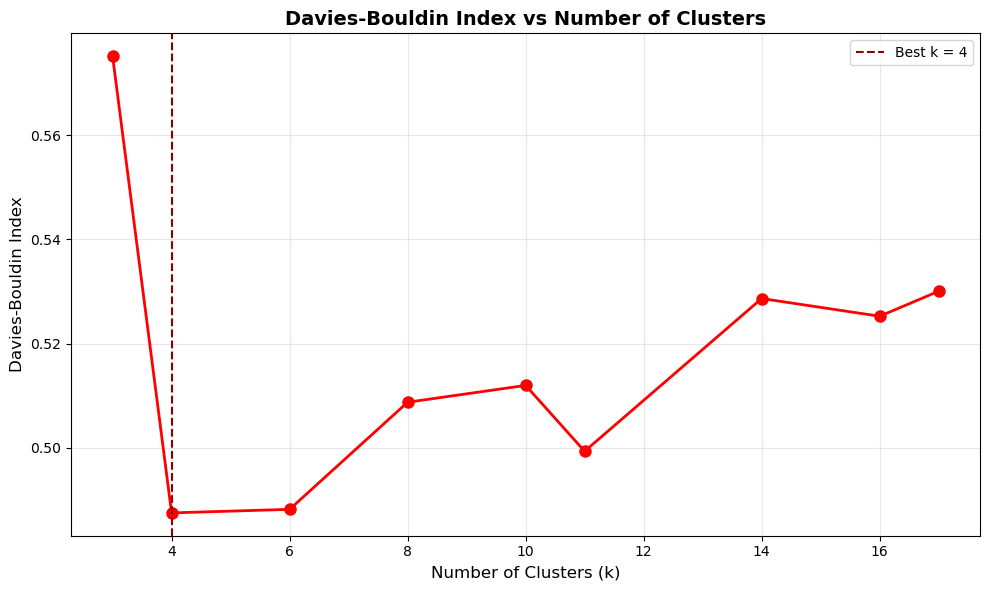

In [28]:
# ================================
# Davies-Bouldin Index Visualization
# ================================
plt.figure(figsize=(10, 6))
plt.plot(df_valid['k'], df_valid['davies_bouldin'], 'ro-', linewidth=2, markersize=8)
plt.axvline(x=best_db_k, color='darkred', linestyle='--', label=f'Best k = {best_db_k}')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Davies-Bouldin Index', fontsize=12)
plt.title('Davies-Bouldin Index vs Number of Clusters', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
# ================================
# Best k per Metric & Voting
# ================================
print("\n" + "=" * 60)
print("🎯 BEST k PER METRIC (CLARA METHOD)")
print("=" * 60)
print(f"🔹 Highest Gap Statistic       : k = {best_gap_k:2d}  (Gap = {df_metrics['gap'].max():.4f})")
print(f"🔹 Highest Silhouette Score    : k = {best_sil_k:2d}  (Silhouette = {df_valid['silhouette'].max():.4f})")
print(f"🔹 Lowest Davies-Bouldin Index : k = {best_db_k:2d}  (DB = {df_valid['davies_bouldin'].min():.4f})")
print("=" * 60)

# ================================
# Voting System
# ================================
votes = {k: 0 for k in filtered_k}

# Berikan vote
votes[best_gap_k] += 1
votes[best_sil_k] += 1
votes[best_db_k]  += 1

# Cari k dengan vote terbanyak
max_votes = max(votes.values())
recommended_k = [k for k, v in votes.items() if v == max_votes]

print(f"\n🗳️  VOTING RESULTS:")
for k in sorted(votes.keys()):
    print(f"   k={k:2d} : {'⭐' * votes[k]} ({votes[k]} votes)")

print(f"\n🏆 VOTING WINNER: k = {recommended_k[0] if len(recommended_k) == 1 else recommended_k}")
if len(recommended_k) > 1:
    print(f"   (Multiple k tied with {max_votes} votes)")
print("=" * 60)


🎯 BEST k PER METRIC (CLARA METHOD)
🔹 Highest Gap Statistic       : k =  3  (Gap = 0.4159)
🔹 Highest Silhouette Score    : k =  4  (Silhouette = 0.5775)
🔹 Lowest Davies-Bouldin Index : k =  4  (DB = 0.4875)

🗳️  VOTING RESULTS:
   k= 3 : ⭐ (1 votes)
   k= 4 : ⭐⭐ (2 votes)
   k= 6 :  (0 votes)
   k= 8 :  (0 votes)
   k=10 :  (0 votes)
   k=11 :  (0 votes)
   k=14 :  (0 votes)
   k=16 :  (0 votes)
   k=17 :  (0 votes)

🏆 VOTING WINNER: k = 4


In [30]:
# ================================
# Aggregate Ranking (Normalized Scores)
# ================================
print("\n" + "=" * 60)
print("🔢 AGGREGATE RANKING (Normalized Scores)")
print("=" * 60)

# Normalize semua metrik ke range [0, 1]
df_rank = df_valid.copy()

df_rank['gap_norm'] = (df_rank['gap'] - df_rank['gap'].min()) / (df_rank['gap'].max() - df_rank['gap'].min())
df_rank['sil_norm'] = (df_rank['silhouette'] - df_rank['silhouette'].min()) / (df_rank['silhouette'].max() - df_rank['silhouette'].min())
df_rank['db_norm']  = 1 - (df_rank['davies_bouldin'] - df_rank['davies_bouldin'].min()) / (df_rank['davies_bouldin'].max() - df_rank['davies_bouldin'].min())

# Aggregate score dari 3 metrik
df_rank['aggregate_score'] = (df_rank['gap_norm'] + df_rank['sil_norm'] + df_rank['db_norm']) / 3

# Urutkan berdasarkan skor total
df_rank = df_rank.sort_values('aggregate_score', ascending=False)

print(df_rank[['k', 'gap_norm', 'sil_norm', 'db_norm', 'aggregate_score']].to_string(index=False, float_format='%.4f'))

best_aggregate_k = df_rank.iloc[0]['k']
print(f"\n🥇 BEST k BY AGGREGATE SCORE: k = {int(best_aggregate_k)} (Score: {df_rank.iloc[0]['aggregate_score']:.4f})")

# ================================
# Final Recommendation
# ================================
print("\n" + "=" * 60)
print("💡 FINAL RECOMMENDATION")
print("=" * 60)
print(f"Method: CLARA (Clustering Large Applications)")
print(f"Sample Size: {sample_size}")
print(f"\nBased on comprehensive evaluation:")
print(f"  • Voting Winner: k = {recommended_k[0] if len(recommended_k) == 1 else recommended_k}")
print(f"  • Aggregate Score Winner: k = {int(best_aggregate_k)}")
print(f"  • Gap Statistic Optimal: k = {k_optimal}")
print(f"\n✅ RECOMMENDED k = {int(best_aggregate_k)}")
print("=" * 60)


🔢 AGGREGATE RANKING (Normalized Scores)
 k  gap_norm  sil_norm  db_norm  aggregate_score
 6    0.9444    0.7968   0.9922           0.9111
 4    0.7259    1.0000   1.0000           0.9086
 8    0.3391    0.6435   0.7577           0.5801
10    0.1875    0.7212   0.7209           0.5432
11    0.0000    0.6769   0.8651           0.5140
16    0.6141    0.3369   0.5694           0.5068
14    0.4088    0.5092   0.5306           0.4829
17    0.4626    0.3677   0.5146           0.4483
 3    1.0000    0.0000   0.0000           0.3333

🥇 BEST k BY AGGREGATE SCORE: k = 6 (Score: 0.9111)

💡 FINAL RECOMMENDATION
Method: CLARA (Clustering Large Applications)
Sample Size: 80

Based on comprehensive evaluation:
  • Voting Winner: k = 4
  • Aggregate Score Winner: k = 6
  • Gap Statistic Optimal: k = 1

✅ RECOMMENDED k = 6


### 5.2.6. Visualisasi Lainnya

In [31]:
k_optimal = 4
plt.style.use('default')
sns.set_palette("husl")

# =====================================================================
# STEP 1: Fit CLARA dengan k optimal
# =====================================================================
print(f"\n🎯 Fitting CLARA with optimal k = {k_optimal}")

if len(X_train_scaled) > sample_size and k_optimal < len(X_train_scaled):
    np.random.seed(42)
    sample_idx = np.random.choice(len(X_train_scaled), size=sample_size, replace=False)
    X_sample = X_train_scaled[sample_idx]
    
    clara_final = KMedoids(n_clusters=k_optimal, method='pam', init='k-medoids++', 
                          max_iter=300, random_state=42)
    clara_final.fit(X_sample)
    labels_final = clara_final.predict(X_train_scaled)
else:
    clara_final = KMedoids(n_clusters=k_optimal, method='pam', init='k-medoids++', 
                          max_iter=300, random_state=42)
    labels_final = clara_final.fit_predict(X_train_scaled)

medoids_scaled = clara_final.cluster_centers_
medoids_original = scaler.inverse_transform(medoids_scaled)

# =====================================================================
# Urutkan Cluster Berdasarkan Medoid
# =====================================================================
medoid_values = medoids_original[:, 0]
sorted_indices = np.argsort(medoid_values)
cluster_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted_indices)}
labels_final_sorted = np.array([cluster_mapping[label] for label in labels_final])

medoids_scaled_sorted = medoids_scaled[sorted_indices]
medoids_original_sorted = medoids_original[sorted_indices]

df_train['Cluster'] = labels_final_sorted
df_train['Price_Scaled'] = X_train_scaled[:, 0]

sil_score = silhouette_score(X_train_scaled, labels_final_sorted)
print(f"✓ Clustering complete!")
print(f"   Silhouette Score: {sil_score:.4f}")

colors = plt.cm.tab20(np.linspace(0, 1, k_optimal))


🎯 Fitting CLARA with optimal k = 4
✓ Clustering complete!
   Silhouette Score: 0.5775


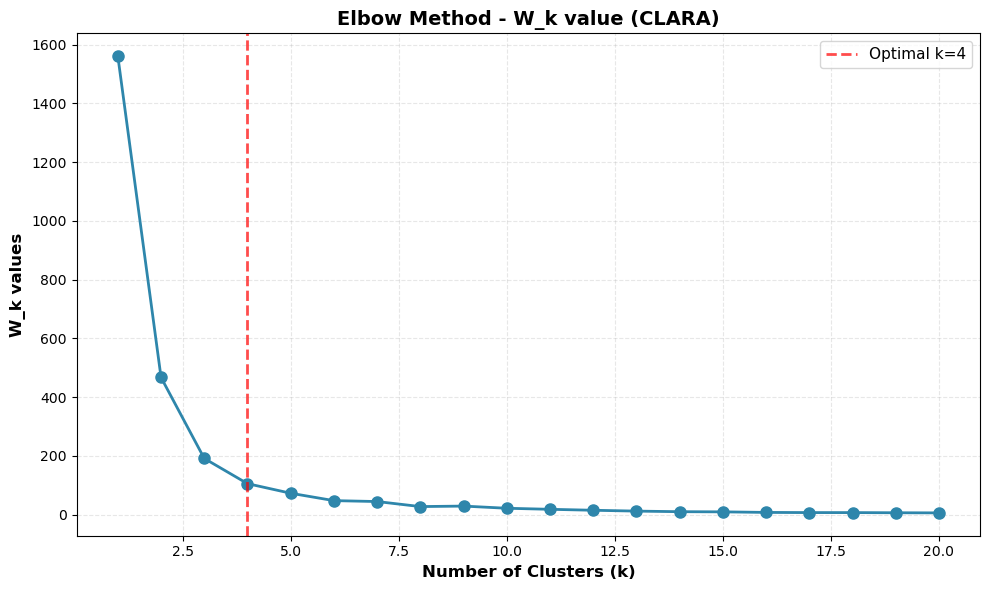

In [32]:
# =====================================================================
# PLOT 1: ELBOW METHOD - W_k values
# =====================================================================
plt.figure(figsize=(10, 6))
plt.plot(range(1, k_max + 1), wk_values, 'o-', linewidth=2, markersize=8, color='#2E86AB')
plt.axvline(x=k_optimal, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Optimal k={k_optimal}')
plt.xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
plt.ylabel('W_k values', fontsize=12, fontweight='bold')
plt.title('Elbow Method - W_k value (CLARA)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

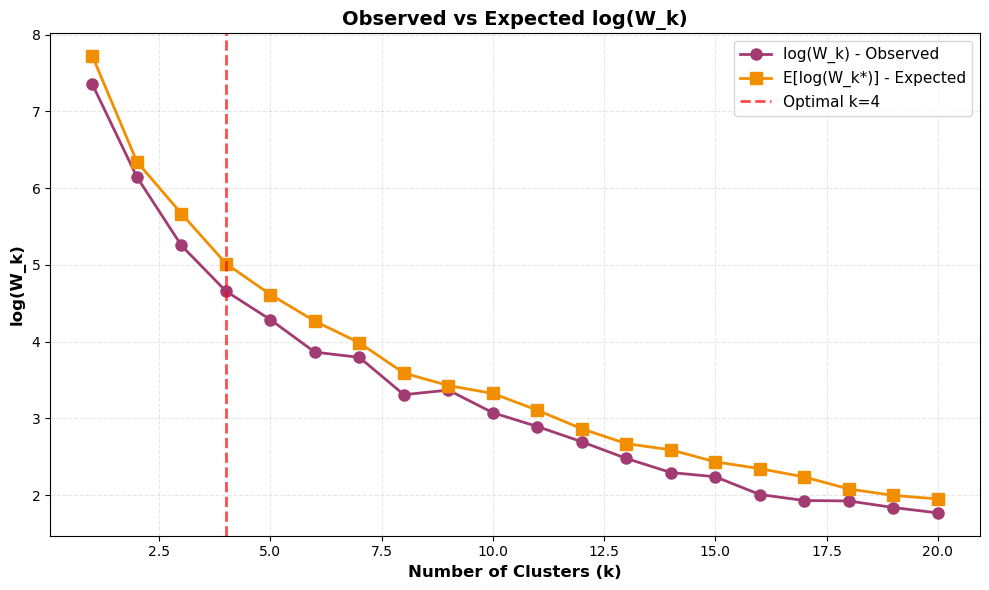

In [33]:
# =====================================================================
# PLOT 2: LOG(W_k) COMPARISON (Observed vs Expected)
# =====================================================================
plt.figure(figsize=(10, 6))
plt.plot(range(1, k_max + 1), log_wk_values, 'o-', linewidth=2, markersize=8, 
         color='#A23B72', label='log(W_k) - Observed')
plt.plot(range(1, k_max + 1), E_log_wk_star, 's-', linewidth=2, markersize=8, 
         color='#F18F01', label='E[log(W_k*)] - Expected')
plt.axvline(x=k_optimal, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Optimal k={k_optimal}')
plt.xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
plt.ylabel('log(W_k)', fontsize=12, fontweight='bold')
plt.title('Observed vs Expected log(W_k)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

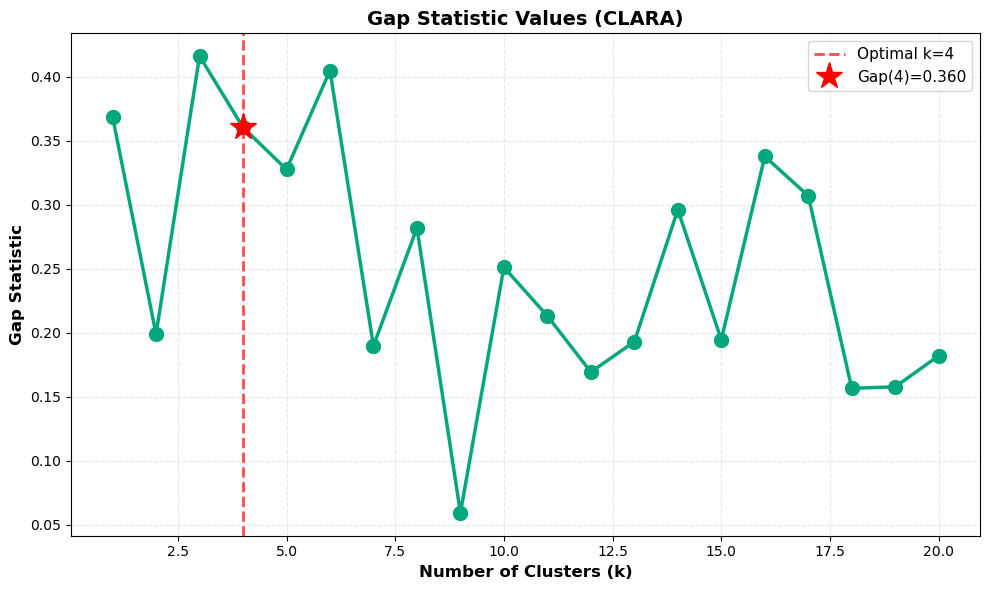

In [34]:
# =====================================================================
# PLOT 3: GAP STATISTIC VALUES
# =====================================================================
plt.figure(figsize=(10, 6))
plt.plot(range(1, k_max + 1), gap_k, 'o-', linewidth=2.5, markersize=10, color='#06A77D')
plt.axvline(x=k_optimal, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Optimal k={k_optimal}')

optimal_gap = gap_k[k_optimal - 1]
plt.plot(k_optimal, optimal_gap, 'r*', markersize=20, label=f'Gap({k_optimal})={optimal_gap:.3f}')

plt.xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
plt.ylabel('Gap Statistic', fontsize=12, fontweight='bold')
plt.title('Gap Statistic Values (CLARA)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

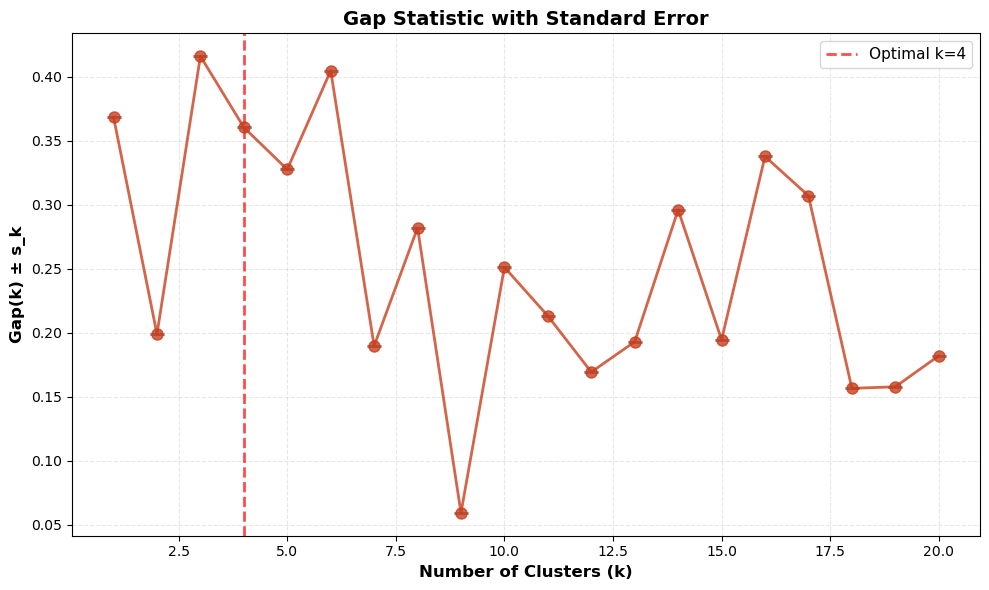

In [35]:
# =====================================================================
# PLOT 4: GAP WITH ERROR BARS (s_k)
# =====================================================================
plt.figure(figsize=(10, 6))
plt.errorbar(range(1, k_max + 1), gap_k, yerr=s_k, fmt='o-', linewidth=2, 
             markersize=8, capsize=5, capthick=2, color='#C73E1D', ecolor='gray', alpha=0.8)
plt.axvline(x=k_optimal, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Optimal k={k_optimal}')
plt.xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
plt.ylabel('Gap(k) ± s_k', fontsize=12, fontweight='bold')
plt.title('Gap Statistic with Standard Error', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

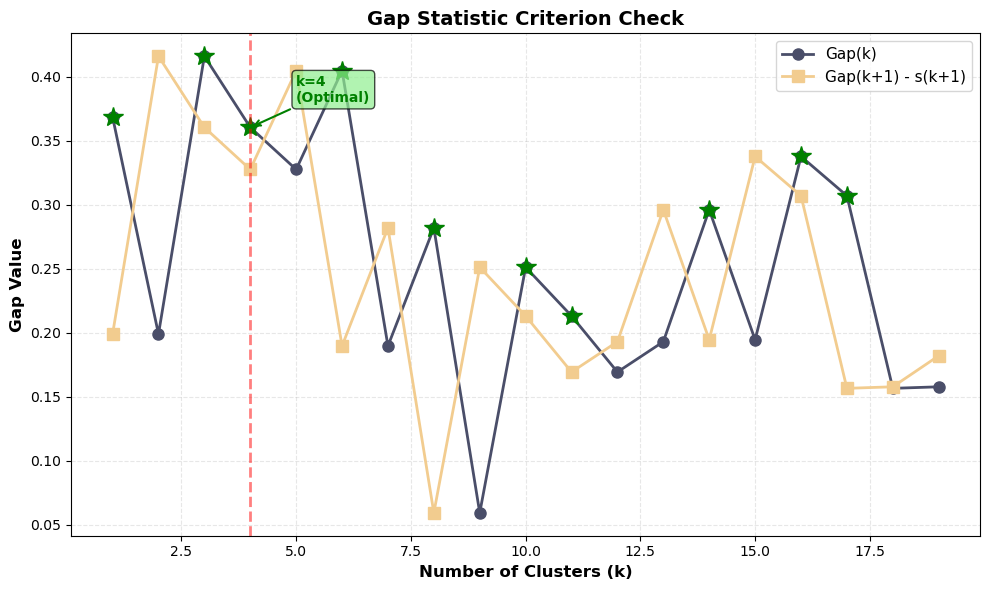

In [36]:
# =====================================================================
# PLOT 5: CRITERION EVALUATION
# =====================================================================
plt.figure(figsize=(10, 6))
k_range = range(1, k_max)
gap_current = gap_k[:-1]
gap_next_minus_s = gap_k[1:] - s_k[1:]

plt.plot(k_range, gap_current, 'o-', linewidth=2, markersize=8, color='#4A4E69', label='Gap(k)')
plt.plot(k_range, gap_next_minus_s, 's-', linewidth=2, markersize=8, color='#F2CC8F', label='Gap(k+1) - s(k+1)')

for k in k_range:
    if gap_current[k-1] >= gap_next_minus_s[k-1]:
        plt.plot(k, gap_current[k-1], 'g*', markersize=15)
        if k == k_optimal:
            plt.annotate(f'k={k}\n(Optimal)', xy=(k, gap_current[k-1]), 
                        xytext=(k+1, gap_current[k-1]+0.02),
                        fontsize=10, fontweight='bold', color='green',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.7),
                        arrowprops=dict(arrowstyle='->', color='green', lw=1.5))

plt.axvline(x=k_optimal, color='red', linestyle='--', linewidth=2, alpha=0.5)
plt.xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
plt.ylabel('Gap Value', fontsize=12, fontweight='bold')
plt.title('Gap Statistic Criterion Check', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

In [37]:
# =====================================================================
# PLOT 6: STANDARD ERROR (s_k)
# =====================================================================
plt.figure(figsize=(10, 6))
plt.plot(range(1, k_max + 1), s_k, 'o-', linewidth=2, markersize=8, color='#8338EC')
plt.axvline(x=k_optimal, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Optimal k={k_optimal}')
plt.xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
plt.ylabel('Standard Error (s_k)', fontsize=12, fontweight='bold')
plt.title('Standard Error Distribution', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

In [38]:
# =====================================================================
# PLOT 7: RESULTS TABLE
# =====================================================================
fig, ax = plt.subplots(figsize=(14, 8))
ax.axis('off')

table_data = []
for k in range(1, min(k_max + 1, 16)):
    criterion = '✓' if (k < k_max and gap_k[k-1] >= (gap_k[k] - s_k[k]) and k >= 3) else '✗'
    table_data.append([
        k,
        f"{wk_values[k-1]:.2f}",
        f"{log_wk_values[k-1]:.4f}",
        f"{E_log_wk_star[k-1]:.4f}",
        f"{gap_k[k-1]:.4f}",
        f"{s_k[k-1]:.4f}",
        criterion
    ])

table = ax.table(cellText=table_data,
                  colLabels=['k', 'W_k', 'log(W_k)', 'E[log(W_k*)]', 'Gap(k)', 's_k', 'Criterion'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

for i in range(7):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(7):
    table[(k_optimal, i)].set_facecolor('#90EE90')
    table[(k_optimal, i)].set_text_props(weight='bold')

ax.set_title('Gap Statistic Summary Table (CLARA Method)', 
              fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

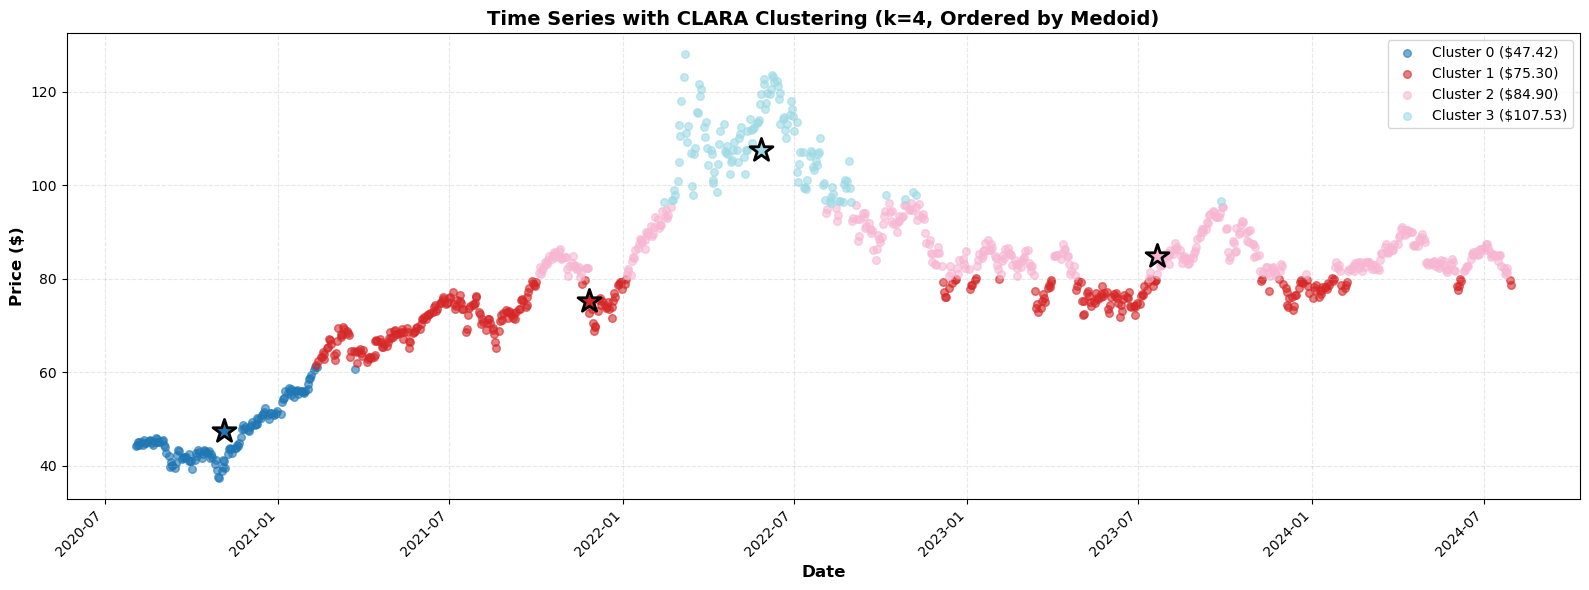

In [39]:
# =====================================================================
# PLOT 8: TIME SERIES dengan CLUSTER COLORING
# =====================================================================
plt.figure(figsize=(16, 6))

for i in range(k_optimal):
    cluster_data = df_train[df_train['Cluster'] == i]
    plt.scatter(cluster_data['Date'], cluster_data['Price'], 
               label=f'Cluster {i} (${medoids_original_sorted[i, 0]:.2f})', 
               color=colors[i], alpha=0.6, s=30)

for i in range(k_optimal):
    cluster_data = df_train[df_train['Cluster'] == i]
    medoid_price = medoids_original_sorted[i, 0]
    median_date = cluster_data['Date'].iloc[len(cluster_data)//2]
    plt.scatter(median_date, medoid_price, color=colors[i], 
               s=300, marker='*', edgecolors='black', linewidths=2, zorder=5)

plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Price ($)', fontsize=12, fontweight='bold')
plt.title(f'Time Series with CLARA Clustering (k={k_optimal}, Ordered by Medoid)', 
         fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=10, frameon=True)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [40]:
# =====================================================================
# PLOT 9: PRICE DISTRIBUTION per CLUSTER (Box Plot)
# =====================================================================
plt.figure(figsize=(10, 6))
cluster_data_list = [df_train[df_train['Cluster'] == i]['Price'].values for i in range(k_optimal)]
bp = plt.boxplot(cluster_data_list, labels=[f'C{i}' for i in range(k_optimal)],
                 patch_artist=True, widths=0.6)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

for i in range(k_optimal):
    plt.scatter(i+1, medoids_original_sorted[i, 0], color='red', s=150, 
               marker='D', edgecolors='black', linewidths=2, zorder=5, label='Medoid' if i==0 else '')

plt.xlabel('Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Price ($)', fontsize=12, fontweight='bold')
plt.title('Price Distribution per Cluster (Ordered)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

In [41]:
# =====================================================================
# PLOT 10: HISTOGRAM STACKED
# =====================================================================
plt.figure(figsize=(10, 6))
for i in range(k_optimal):
    cluster_prices = df_train[df_train['Cluster'] == i]['Price']
    plt.hist(cluster_prices, bins=30, alpha=0.6, color=colors[i], 
            label=f'C{i} (${medoids_original_sorted[i, 0]:.0f})', 
            edgecolor='black', linewidth=0.5)

plt.xlabel('Price ($)', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Price Histogram by Cluster', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

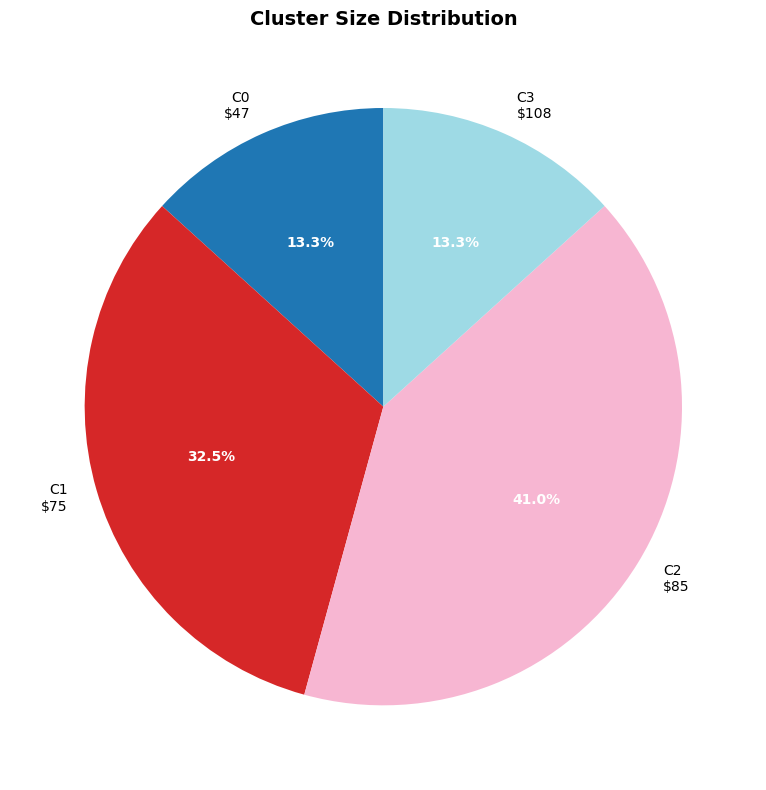

In [42]:
# =====================================================================
# PLOT 11: CLUSTER SIZE (Pie Chart)
# =====================================================================
plt.figure(figsize=(8, 8))
cluster_sizes = [len(df_train[df_train['Cluster'] == i]) for i in range(k_optimal)]
wedges, texts, autotexts = plt.pie(cluster_sizes, 
                                     labels=[f'C{i}\n${medoids_original_sorted[i, 0]:.0f}' 
                                            for i in range(k_optimal)],
                                     colors=colors, autopct='%1.1f%%', startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

plt.title('Cluster Size Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

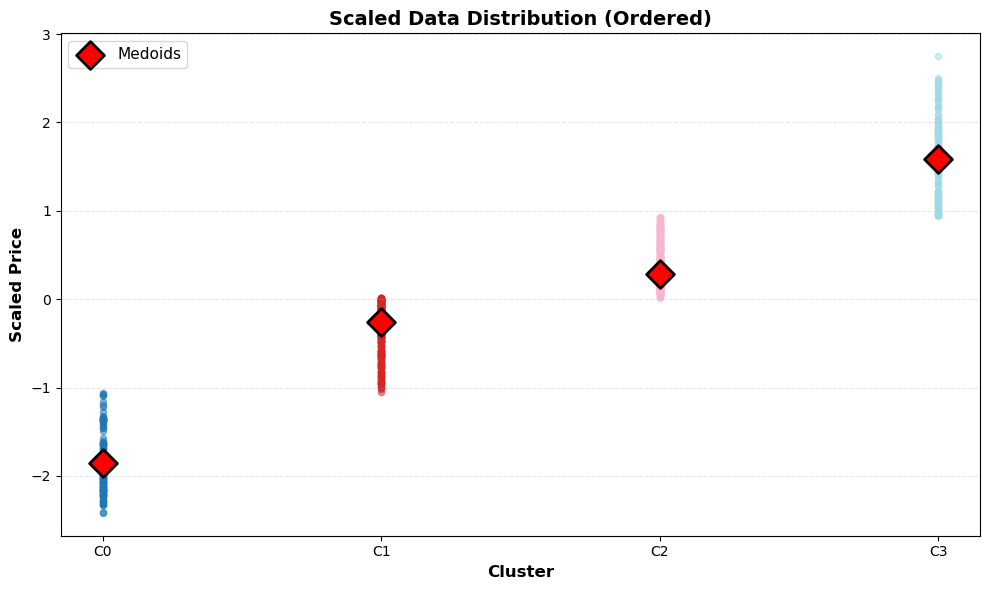

In [43]:
# =====================================================================
# PLOT 12: SCALED DATA VISUALIZATION (1D)
# =====================================================================
plt.figure(figsize=(10, 6))
for i in range(k_optimal):
    cluster_data = df_train[df_train['Cluster'] == i]['Price_Scaled']
    plt.scatter([i]*len(cluster_data), cluster_data, color=colors[i], 
               alpha=0.5, s=20)

plt.scatter(range(k_optimal), medoids_scaled_sorted[:, 0], color='red', s=200, 
           marker='D', edgecolors='black', linewidths=2, zorder=5, label='Medoids')

plt.xlabel('Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Scaled Price', fontsize=12, fontweight='bold')
plt.title('Scaled Data Distribution (Ordered)', fontsize=14, fontweight='bold')
plt.xticks(range(k_optimal), [f'C{i}' for i in range(k_optimal)])
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

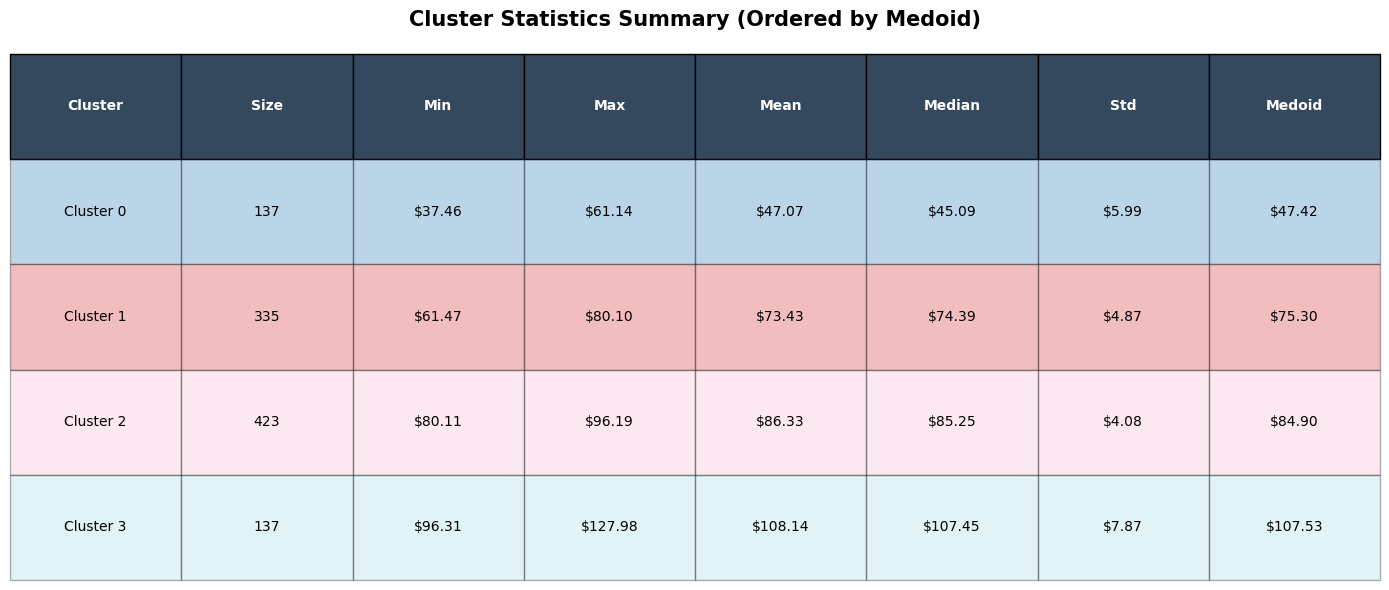

In [44]:
# =====================================================================
# PLOT 13: CLUSTER STATISTICS TABLE
# =====================================================================
fig, ax = plt.subplots(figsize=(14, 6))
ax.axis('off')

stats_data = []
for i in range(k_optimal):
    cluster_prices = df_train[df_train['Cluster'] == i]['Price']
    stats_data.append([
        f'Cluster {i}',
        len(cluster_prices),
        f"${cluster_prices.min():.2f}",
        f"${cluster_prices.max():.2f}",
        f"${cluster_prices.mean():.2f}",
        f"${cluster_prices.median():.2f}",
        f"${cluster_prices.std():.2f}",
        f"${medoids_original_sorted[i, 0]:.2f}"
    ])

table = ax.table(cellText=stats_data,
                  colLabels=['Cluster', 'Size', 'Min', 'Max', 'Mean', 'Median', 'Std', 'Medoid'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

for i in range(8):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white')

for i in range(k_optimal):
    for j in range(8):
        table[(i+1, j)].set_facecolor(colors[i])
        table[(i+1, j)].set_alpha(0.3)

ax.set_title('Cluster Statistics Summary (Ordered by Medoid)', fontsize=15, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [45]:
# =====================================================================
# PRINT SUMMARY
# =====================================================================
print("\n" + "="*70)
print("📊 CLUSTERING SUMMARY (Ordered by Medoid Value)")
print("="*70)
print(f"Method: CLARA (Clustering Large Applications)")
print(f"Optimal k: {k_optimal}")
print(f"Silhouette Score: {sil_score:.4f}")
print(f"Total data points: {len(df)}")
print(f"\nCluster Statistics (Ordered from lowest to highest medoid):")
print("-"*70)
for i in range(k_optimal):
    cluster_data = df_train[df_train['Cluster'] == i]
    print(f"Cluster {i}:")
    print(f"  Medoid: ${medoids_original_sorted[i, 0]:.2f} ⭐")
    print(f"  Size: {len(cluster_data)} ({len(cluster_data)/len(df_train)*100:.1f}%)")
    print(f"  Price Range: ${cluster_data['Price'].min():.2f} - ${cluster_data['Price'].max():.2f}")
    print(f"  Mean: ${cluster_data['Price'].mean():.2f}")
    print()
print("="*70)


📊 CLUSTERING SUMMARY (Ordered by Medoid Value)
Method: CLARA (Clustering Large Applications)
Optimal k: 4
Silhouette Score: 0.5775
Total data points: 1291

Cluster Statistics (Ordered from lowest to highest medoid):
----------------------------------------------------------------------
Cluster 0:
  Medoid: $47.42 ⭐
  Size: 137 (13.3%)
  Price Range: $37.46 - $61.14
  Mean: $47.07

Cluster 1:
  Medoid: $75.30 ⭐
  Size: 335 (32.5%)
  Price Range: $61.47 - $80.10
  Mean: $73.43

Cluster 2:
  Medoid: $84.90 ⭐
  Size: 423 (41.0%)
  Price Range: $80.11 - $96.19
  Mean: $86.33

Cluster 3:
  Medoid: $107.53 ⭐
  Size: 137 (13.3%)
  Price Range: $96.31 - $127.98
  Mean: $108.14



## 5.3 CLARA-FTSMC

### 5.3.1. Fungsi Keanggotaan (Trapezoid using IQR)

In [46]:
print("\n" + "-"*110)
print("Alasan Penggunaan Fungsi Keanggotaan Trapezoid")
print("-"*110)
print("✅ Sesuai dengan hasil CLARA: Setiap cluster sudah memiliki batas yang jelas dan tidak overlap")
print("✅ Ada plateau (μ = 1.0): Area dengan keanggotaan penuh di sekitar medoid")
print("✅ Lebih stabil: Tidak sensitif terhadap noise di tengah cluster")
print("✅ Interpretasi bisnis jelas: Harga di sekitar medoid = 'fully belongs' to that state")


--------------------------------------------------------------------------------------------------------------
Alasan Penggunaan Fungsi Keanggotaan Trapezoid
--------------------------------------------------------------------------------------------------------------
✅ Sesuai dengan hasil CLARA: Setiap cluster sudah memiliki batas yang jelas dan tidak overlap
✅ Ada plateau (μ = 1.0): Area dengan keanggotaan penuh di sekitar medoid
✅ Lebih stabil: Tidak sensitif terhadap noise di tengah cluster
✅ Interpretasi bisnis jelas: Harga di sekitar medoid = 'fully belongs' to that state


In [47]:
print("\n📊 5.3.1: Calculating Quartiles (Q1, Q3) and IQR...")

cluster_stats = []

for i in range(k_optimal):
    # Get cluster data (original scale)
    cluster_data = df_train[df_train['Cluster'] == i]['Price'].values
    
    # Calculate quartiles and statistics
    Q1 = np.percentile(cluster_data, 25)
    Q2 = np.percentile(cluster_data, 50)  # Median
    Q3 = np.percentile(cluster_data, 75)
    IQR = Q3 - Q1
    
    # Store statistics
    cluster_stats.append({
        'cluster': i,
        'size': len(cluster_data),
        'min': cluster_data.min(),
        'max': cluster_data.max(),
        'Q1': Q1,
        'Q2_median': Q2,
        'Q3': Q3,
        'IQR': IQR,
        'medoid': medoids_original_sorted[i, 0],
        'mean': cluster_data.mean(),
        'std': cluster_data.std()
    })

# Convert to DataFrame for nice display
df_cluster_stats = pd.DataFrame(cluster_stats)

print("\n✅ Quartile Calculation Complete!")
print("\n" + "-"*110)
print("CLUSTER STATISTICS (Q1, Q2, Q3, IQR)")
print("-"*110)
print(df_cluster_stats.to_string(index=False, float_format=lambda x: f'{x:.2f}'))
print("-"*110)

# Calculate plateau coverage
cluster_ranges = df_cluster_stats['max'] - df_cluster_stats['min']
plateau_coverage = (df_cluster_stats['IQR'] / cluster_ranges * 100)

print("\n📊 IQR Coverage of Cluster Range:")
for i in range(k_optimal):
    print(f"  Cluster {i}: IQR=${df_cluster_stats.iloc[i]['IQR']:.2f} "
          f"= {plateau_coverage.iloc[i]:.1f}% of range "
          f"(${cluster_ranges.iloc[i]:.2f})")
print(f"\n  Average IQR Coverage: {plateau_coverage.mean():.1f}%")
print("-"*110)


📊 5.3.1: Calculating Quartiles (Q1, Q3) and IQR...

✅ Quartile Calculation Complete!

--------------------------------------------------------------------------------------------------------------
CLUSTER STATISTICS (Q1, Q2, Q3, IQR)
--------------------------------------------------------------------------------------------------------------
 cluster  size   min    max     Q1  Q2_median     Q3   IQR  medoid   mean  std
       0   137 37.46  61.14  42.45      45.09  51.09  8.64   47.42  47.07 5.96
       1   335 61.47  80.10  69.57      74.39  77.37  7.80   75.30  73.43 4.87
       2   423 80.11  96.19  83.02      85.25  89.24  6.22   84.90  86.33 4.08
       3   137 96.31 127.98 100.99     107.45 113.45 12.46  107.53 108.14 7.84
--------------------------------------------------------------------------------------------------------------

📊 IQR Coverage of Cluster Range:
  Cluster 0: IQR=$8.64 = 36.5% of range ($23.68)
  Cluster 1: IQR=$7.80 = 41.9% of range ($18.63)
  Cluster 2: IQR

In [48]:
print("\n📐 5.3.2: Defining Trapezoid Parameters (Direct Q1-Q3)...")

fuzzy_sets = []

for i in range(k_optimal):
    cluster_data = df_train[df_train['Cluster'] == i]['Price'].values
    
    # Get quartiles
    Q1 = cluster_stats[i]['Q1']
    Q3 = cluster_stats[i]['Q3']
    IQR = cluster_stats[i]['IQR']
    medoid = cluster_stats[i]['medoid']
    cluster_min = cluster_stats[i]['min']
    cluster_max = cluster_stats[i]['max']
    
    # Core region [b, c] - DIRECTLY USE Q1 and Q3 ✅
    b = Q1  # 25th percentile - start of plateau
    c = Q3  # 75th percentile - end of plateau
    
    # Support region [a, d] - transition boundaries
    if i == 0:  # First cluster (leftmost)
        # a: extend below minimum to capture lower tail
        a = cluster_min - (cluster_max - cluster_min) * 0.1
        
        # d: midpoint to next cluster's medoid
        next_medoid = cluster_stats[i+1]['medoid']
        d = (medoid + next_medoid) / 2
        
        # Ensure d >= Q3 (no overlap with core)
        if d < Q3:
            d = Q3 + IQR * 0.3
    
    elif i == k_optimal - 1:  # Last cluster (rightmost)
        # a: midpoint from previous cluster's medoid
        prev_medoid = cluster_stats[i-1]['medoid']
        a = (prev_medoid + medoid) / 2
        
        # Ensure a <= Q1 (no overlap with core)
        if a > Q1:
            a = Q1 - IQR * 0.3
        
        # d: extend above maximum to capture upper tail
        d = cluster_max + (cluster_max - cluster_min) * 0.1
    
    else:  # Middle clusters
        # a: midpoint from previous cluster's medoid
        prev_medoid = cluster_stats[i-1]['medoid']
        a = (prev_medoid + medoid) / 2
        
        # Adjust if a > Q1 (overlaps with core)
        if a > Q1:
            a = Q1 - IQR * 0.3
        
        # d: midpoint to next cluster's medoid
        next_medoid = cluster_stats[i+1]['medoid']
        d = (medoid + next_medoid) / 2
        
        # Adjust if d < Q3 (overlaps with core)
        if d < Q3:
            d = Q3 + IQR * 0.3
    
    fuzzy_sets.append({
        'cluster': i,
        'label': f'A{i}',
        'a': a,
        'b': b,  # Q1
        'c': c,  # Q3
        'd': d,
        'medoid': medoid,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'plateau_width': c - b,  # = IQR
        'support_width': d - a
    })

# Convert to DataFrame
df_fuzzy_sets = pd.DataFrame(fuzzy_sets)

print("\n✅ Trapezoid Parameters Defined (Q1-Q3 Based)!")
print("\n" + "-"*115)
print("FUZZY SET PARAMETERS (Trapezoid: [a, b=Q1, c=Q3, d])")
print("-"*115)
print(df_fuzzy_sets[['label', 'cluster', 'a', 'b', 'c', 'd', 'medoid', 'plateau_width', 'support_width']]
      .to_string(index=False, float_format=lambda x: f'{x:.3f}'))
print("-"*115)
print("\n📖 INTERPRETATION:")
print("  • a: Lower support boundary (μ=0 starts)")
print("  • b: Q1 (25th percentile) - Plateau starts (μ=1 starts)")
print("  • c: Q3 (75th percentile) - Plateau ends (μ=1 ends)")
print("  • d: Upper support boundary (μ=0 ends)")
print("  • Plateau [b,c] = IQR = MIDDLE 50% of cluster data ✅")
print("  • Data between Q1 and Q3 has FULL membership (μ=1.0)")
print("-"*115)

# Validate trapezoid constraints
print("\n🔍 Validating Trapezoid Constraints:")
violations = []
for i in range(k_optimal):
    fs = df_fuzzy_sets.iloc[i]
    if not (fs['a'] < fs['b'] <= fs['c'] < fs['d']):
        violations.append(f"Cluster {i}: {fs['a']:.3f} < {fs['b']:.3f} <= {fs['c']:.3f} < {fs['d']:.3f}")

if violations:
    print("  ⚠️  Constraint violations found:")
    for v in violations:
        print(f"    {v}")
else:
    print("  ✅ All trapezoid constraints satisfied: a < b ≤ c < d")

# Calculate plateau statistics
plateau_widths = df_fuzzy_sets['plateau_width'].values
support_widths = df_fuzzy_sets['support_width'].values

print(f"\n📊 Plateau Width Statistics:")
print(f"  Mean Plateau: ${plateau_widths.mean():.2f}")
print(f"  Std Plateau: ${plateau_widths.std():.2f}")
print(f"  Min Plateau: ${plateau_widths.min():.2f} (Cluster {plateau_widths.argmin()})")
print(f"  Max Plateau: ${plateau_widths.max():.2f} (Cluster {plateau_widths.argmax()})")

print(f"\n📏 Support Width Statistics:")
print(f"  Mean Support: ${support_widths.mean():.2f}")
print(f"  Std Support: ${support_widths.std():.2f}")


📐 5.3.2: Defining Trapezoid Parameters (Direct Q1-Q3)...

✅ Trapezoid Parameters Defined (Q1-Q3 Based)!

-------------------------------------------------------------------------------------------------------------------
FUZZY SET PARAMETERS (Trapezoid: [a, b=Q1, c=Q3, d])
-------------------------------------------------------------------------------------------------------------------
label  cluster      a       b       c       d  medoid  plateau_width  support_width
   A0        0 35.092  42.450  51.090  61.360  47.420          8.640         26.268
   A1        1 61.360  69.570  77.370  80.100  75.300          7.800         18.740
   A2        2 80.100  83.015  89.240  96.215  84.900          6.225         16.115
   A3        3 96.215 100.990 113.450 131.147 107.530         12.460         34.932
-------------------------------------------------------------------------------------------------------------------

📖 INTERPRETATION:
  • a: Lower support boundary (μ=0 starts)
  • b: Q1 (

In [49]:
def trapezoid_membership(x, a, b, c, d):
    """
    Trapezoid membership function dengan boundary handling yang BENAR
    
    FIX: Ketika x tepat di boundary kanan (x == d), beri membership minimum
         sehingga data di boundary masuk ke fuzzy set di bawah (sesuai keinginan)
    
    Parameters:
    -----------
    x : float or array
        Input value(s) - Price
    a, b, c, d : float
        Trapezoid parameters where a < b <= c < d
        - [a, b]: left slope (μ: 0→1)
        - [b, c]: plateau (μ: 1)
        - [c, d]: right slope (μ: 1→0)
    
    Boundary Handling:
    ------------------
    - Gunakan <= untuk batas kiri (x <= a → μ = 0)
    - Gunakan <= untuk batas kanan (x <= d → μ > 0)
    - Di boundary point (x == d), berikan membership minimum
    - Titik perbatasan akan masuk ke fuzzy set di BAWAH
    
    Returns:
    --------
    mu : float or array
        Membership degree [0, 1]
    """
    MIN_MEMBERSHIP = 0.0001  # Membership minimum untuk boundary points
    
    if isinstance(x, (int, float)):
        if x <= a:
            return 0.0
        elif x > d:
            return 0.0
        elif a < x < b:
            return (x - a) / (b - a) if (b - a) > 0 else 1.0
        elif b <= x <= c:
            return 1.0
        elif c < x <= d:
            if (d - c) == 0:
                return MIN_MEMBERSHIP
            slope_value = (d - x) / (d - c)
            # KUNCI: Ensure minimum membership at boundary
            return max(slope_value, MIN_MEMBERSHIP)
        else:
            return 0.0
    else:
        # Array input
        mu = np.zeros_like(x, dtype=float)
        
        # Left slope: a < x < b
        mask1 = (x > a) & (x < b)
        if np.any(mask1) and (b - a) > 0:
            mu[mask1] = (x[mask1] - a) / (b - a)
        
        # Plateau: b <= x <= c (Q1 to Q3)
        mask2 = (x >= b) & (x <= c)
        mu[mask2] = 1.0
        
        # Right slope: c < x <= d
        mask3 = (x > c) & (x <= d)
        if np.any(mask3) and (d - c) > 0:
            mu[mask3] = (d - x[mask3]) / (d - c)
            # KUNCI: Ensure minimum membership at boundary points
            mu[mask3] = np.maximum(mu[mask3], MIN_MEMBERSHIP)
        
        return mu

print("✅ Trapezoid Membership Function Defined (BOUNDARY FIX VERSION)!")
print("\n Formula:")
print("  ⎧ 0           if x ≤ a or x > d")
print("  ⎪ (x-a)/(b-a) if a < x < b")
print("  μ(x) = ⎨ 1           if b ≤ x ≤ c  ← PLATEAU (Q1 to Q3)")
print("  ⎪ max((d-x)/(d-c), ε) if c < x ≤ d  ← FIX: min membership at boundary")
print("  ⎩ 0           otherwise")
print("\n 📌 Boundary Rule: Titik batas masuk ke fuzzy set di BAWAH")
print("    Contoh: x=80.1 di batas A1|A2 → masuk A1 (bukan A2)")

✅ Trapezoid Membership Function Defined (BOUNDARY FIX VERSION)!

 Formula:
  ⎧ 0           if x ≤ a or x > d
  ⎪ (x-a)/(b-a) if a < x < b
  μ(x) = ⎨ 1           if b ≤ x ≤ c  ← PLATEAU (Q1 to Q3)
  ⎪ max((d-x)/(d-c), ε) if c < x ≤ d  ← FIX: min membership at boundary
  ⎩ 0           otherwise

 📌 Boundary Rule: Titik batas masuk ke fuzzy set di BAWAH
    Contoh: x=80.1 di batas A1|A2 → masuk A1 (bukan A2)


In [50]:
print("\n📊 5.3.4: Calculating Membership Degrees for Training Data...")
# Create membership matrix (n_samples × k_clusters)
n_train = len(df_train)
membership_matrix = np.zeros((n_train, k_optimal))
for i in range(k_optimal):
    params = df_fuzzy_sets.iloc[i]
    membership_matrix[:, i] = trapezoid_membership(
        df_train['Price'].values, 
        params['a'], params['b'], params['c'], params['d']
    )

# Add membership columns to dataframe
for i in range(k_optimal):
    df_train[f'mu_A{i}'] = membership_matrix[:, i]

# Calculate sum of memberships
df_train['mu_sum'] = membership_matrix.sum(axis=1)

# Find dominant fuzzy set (max membership)
df_train['max_mu'] = membership_matrix.max(axis=1)
df_train['fuzzy_state'] = membership_matrix.argmax(axis=1)

print(f"✅ Membership calculation complete!")
print(f"\n📋 Sample Membership Degrees (first 15 rows):")
sample_cols = ['Date', 'Price', 'Cluster'] + [f'mu_A{i}' for i in range(k_optimal)] + ['mu_sum']
print(df_train[sample_cols].head(15).to_string(index=False))

# ✅ VALIDASI: Cek data yang hilang
missing_membership = df_train[df_train['mu_sum'] == 0]
if len(missing_membership) > 0:
    print(f"\n⚠️  WARNING: {len(missing_membership)} data points memiliki mu_sum = 0!")
    print(missing_membership[['Date', 'Price', 'Cluster'] + [f'mu_A{i}' for i in range(k_optimal)]])
else:
    print(f"\n✅ VALIDASI: Semua data memiliki membership > 0 (no gaps!)")


📊 5.3.4: Calculating Membership Degrees for Training Data...
✅ Membership calculation complete!

📋 Sample Membership Degrees (first 15 rows):
      Date  Price  Cluster  mu_A0  mu_A1  mu_A2  mu_A3  mu_sum
2020-08-03  44.15        0    1.0    0.0    0.0    0.0     1.0
2020-08-04  44.43        0    1.0    0.0    0.0    0.0     1.0
2020-08-05  45.17        0    1.0    0.0    0.0    0.0     1.0
2020-08-06  45.09        0    1.0    0.0    0.0    0.0     1.0
2020-08-07  44.40        0    1.0    0.0    0.0    0.0     1.0
2020-08-10  44.99        0    1.0    0.0    0.0    0.0     1.0
2020-08-11  44.50        0    1.0    0.0    0.0    0.0     1.0
2020-08-12  45.43        0    1.0    0.0    0.0    0.0     1.0
2020-08-13  44.96        0    1.0    0.0    0.0    0.0     1.0
2020-08-14  44.80        0    1.0    0.0    0.0    0.0     1.0
2020-08-17  45.37        0    1.0    0.0    0.0    0.0     1.0
2020-08-18  45.46        0    1.0    0.0    0.0    0.0     1.0
2020-08-19  45.37        0    1.0    0

In [51]:
print("\n🔍 5.3.5: Membership Quality Analysis...")

# Check membership properties
full_membership_points = ((df_train['max_mu'] == 1.0)).sum()
partial_membership_points = ((df_train['max_mu'] > 0) & (df_train['max_mu'] < 1.0)).sum()
zero_membership_points = (df_train['mu_sum'] == 0).sum()
overlapping_points = (df_train['mu_sum'] > 1.01).sum()

print(f"\n📊 Membership Distribution:")
print(f"  Points with FULL membership (μ=1.0 in at least one set): {full_membership_points} ({full_membership_points/n_train*100:.1f}%)")
print(f"  Points with PARTIAL membership (0<μ<1.0 all sets): {partial_membership_points} ({partial_membership_points/n_train*100:.1f}%)")
print(f"  Points with NO membership (μ=0 all sets): {zero_membership_points} ({zero_membership_points/n_train*100:.1f}%)")
print(f"  Points with OVERLAPPING membership (sum>1.01): {overlapping_points} ({overlapping_points/n_train*100:.1f}%)")

# Analyze membership sum statistics
print(f"\n📈 Membership Sum Statistics:")
print(f"  Mean μ_sum: {df_train['mu_sum'].mean():.4f}")
print(f"  Std μ_sum: {df_train['mu_sum'].std():.4f}")
print(f"  Min μ_sum: {df_train['mu_sum'].min():.4f}")
print(f"  Max μ_sum: {df_train['mu_sum'].max():.4f}")

# Count points in plateau region per cluster
print(f"\n🎯 Points in Plateau Region (Q1-Q3) per Cluster:")
for i in range(k_optimal):
    in_plateau = (df_train['Cluster'] == i) & (df_train[f'mu_A{i}'] == 1.0)
    total_cluster = (df_train['Cluster'] == i).sum()
    print(f"  Cluster {i}: {in_plateau.sum()}/{total_cluster} ({in_plateau.sum()/total_cluster*100:.1f}%) have μ=1.0")

# Overall quality assessment
print(f"\n✅ QUALITY ASSESSMENT:")
if zero_membership_points == 0 and overlapping_points < n_train * 0.05:
    print("  ✅ EXCELLENT: No gaps, minimal overlap (<5%)")
elif zero_membership_points == 0:
    print("  ✅ GOOD: No gaps, some overlap at boundaries")
elif zero_membership_points < n_train * 0.01:
    print("  ⚠️  ACCEPTABLE: Very few gaps (<1%)")
else:
    print("  ⚠️  WARNING: Significant gaps or overlap detected")


🔍 5.3.5: Membership Quality Analysis...

📊 Membership Distribution:
  Points with FULL membership (μ=1.0 in at least one set): 517 (50.1%)
  Points with PARTIAL membership (0<μ<1.0 all sets): 515 (49.9%)
  Points with NO membership (μ=0 all sets): 0 (0.0%)
  Points with OVERLAPPING membership (sum>1.01): 0 (0.0%)

📈 Membership Sum Statistics:
  Mean μ_sum: 0.7898
  Std μ_sum: 0.2894
  Min μ_sum: 0.0001
  Max μ_sum: 1.0000

🎯 Points in Plateau Region (Q1-Q3) per Cluster:
  Cluster 0: 69/137 (50.4%) have μ=1.0
  Cluster 1: 167/335 (49.9%) have μ=1.0
  Cluster 2: 211/423 (49.9%) have μ=1.0
  Cluster 3: 70/137 (51.1%) have μ=1.0

✅ QUALITY ASSESSMENT:
  ✅ EXCELLENT: No gaps, minimal overlap (<5%)



📈 5.3.6: Creating Visualizations...


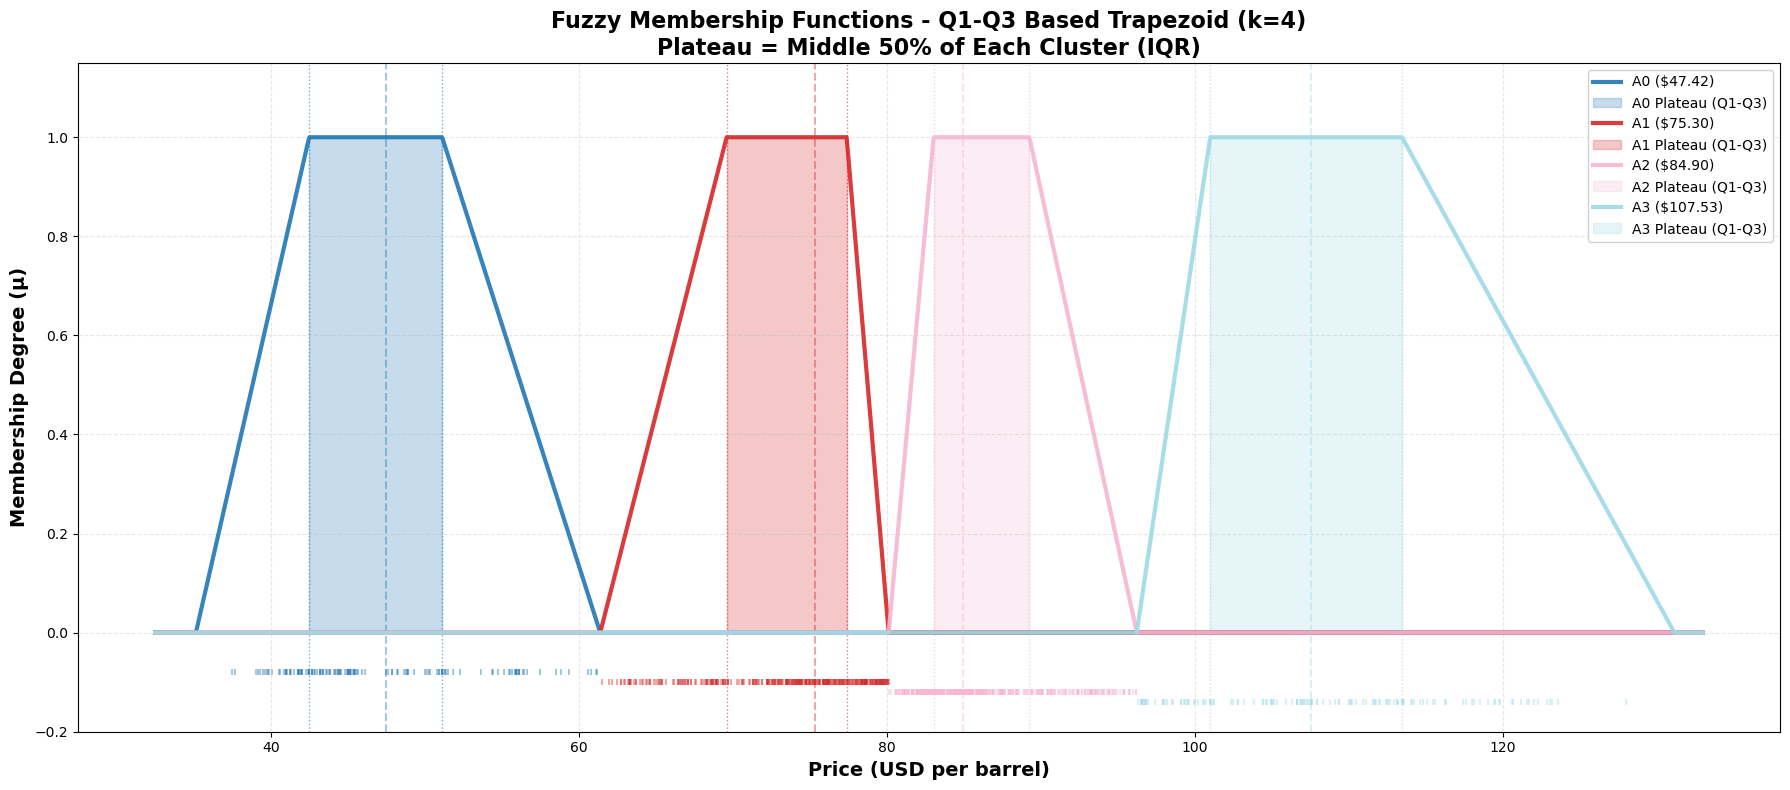

In [52]:
print("\n📈 5.3.6: Creating Visualizations...")

# Create dense x-axis for smooth curves
x_min = df_train['Price'].min() - 5
x_max = df_train['Price'].max() + 5
x_dense = np.linspace(x_min, x_max, 2000)

plt.figure(figsize=(18, 8))

# Plot membership functions
for i in range(k_optimal):
    params = df_fuzzy_sets.iloc[i]
    mu_values = trapezoid_membership(x_dense, params['a'], params['b'], 
                                      params['c'], params['d'])
    
    # Plot membership curve
    plt.plot(x_dense, mu_values, linewidth=3, label=f'A{i} (${params["medoid"]:.2f})',
             color=colors[i], alpha=0.9)
    
    # Mark medoid
    plt.axvline(params['medoid'], color=colors[i], linestyle='--', 
                linewidth=1.5, alpha=0.4)
    
    # Highlight plateau region (Q1 to Q3)
    plt.fill_between(x_dense, 0, mu_values, 
                     where=(x_dense >= params['b']) & (x_dense <= params['c']),
                     color=colors[i], alpha=0.25, label=f'A{i} Plateau (Q1-Q3)')
    
    # Mark Q1 and Q3
    plt.axvline(params['b'], color=colors[i], linestyle=':', 
                linewidth=1, alpha=0.6)
    plt.axvline(params['c'], color=colors[i], linestyle=':', 
                linewidth=1, alpha=0.6)

# Mark actual data points at bottom
for i in range(k_optimal):
    cluster_prices = df_train[df_train['Cluster'] == i]['Price'].values
    y_pos = np.full_like(cluster_prices, -0.08 - (i * 0.02))
    plt.scatter(cluster_prices, y_pos, color=colors[i], alpha=0.4, s=15, marker='|')

plt.xlabel('Price (USD per barrel)', fontsize=14, fontweight='bold')
plt.ylabel('Membership Degree (μ)', fontsize=14, fontweight='bold')
plt.title(f'Fuzzy Membership Functions - Q1-Q3 Based Trapezoid (k={k_optimal})\nPlateau = Middle 50% of Each Cluster (IQR)', 
          fontsize=16, fontweight='bold')
plt.legend(loc='upper right', fontsize=10, ncol=1, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.ylim(-0.2, 1.15)
plt.tight_layout()
plt.show()


📊 Creating individual membership function plots...


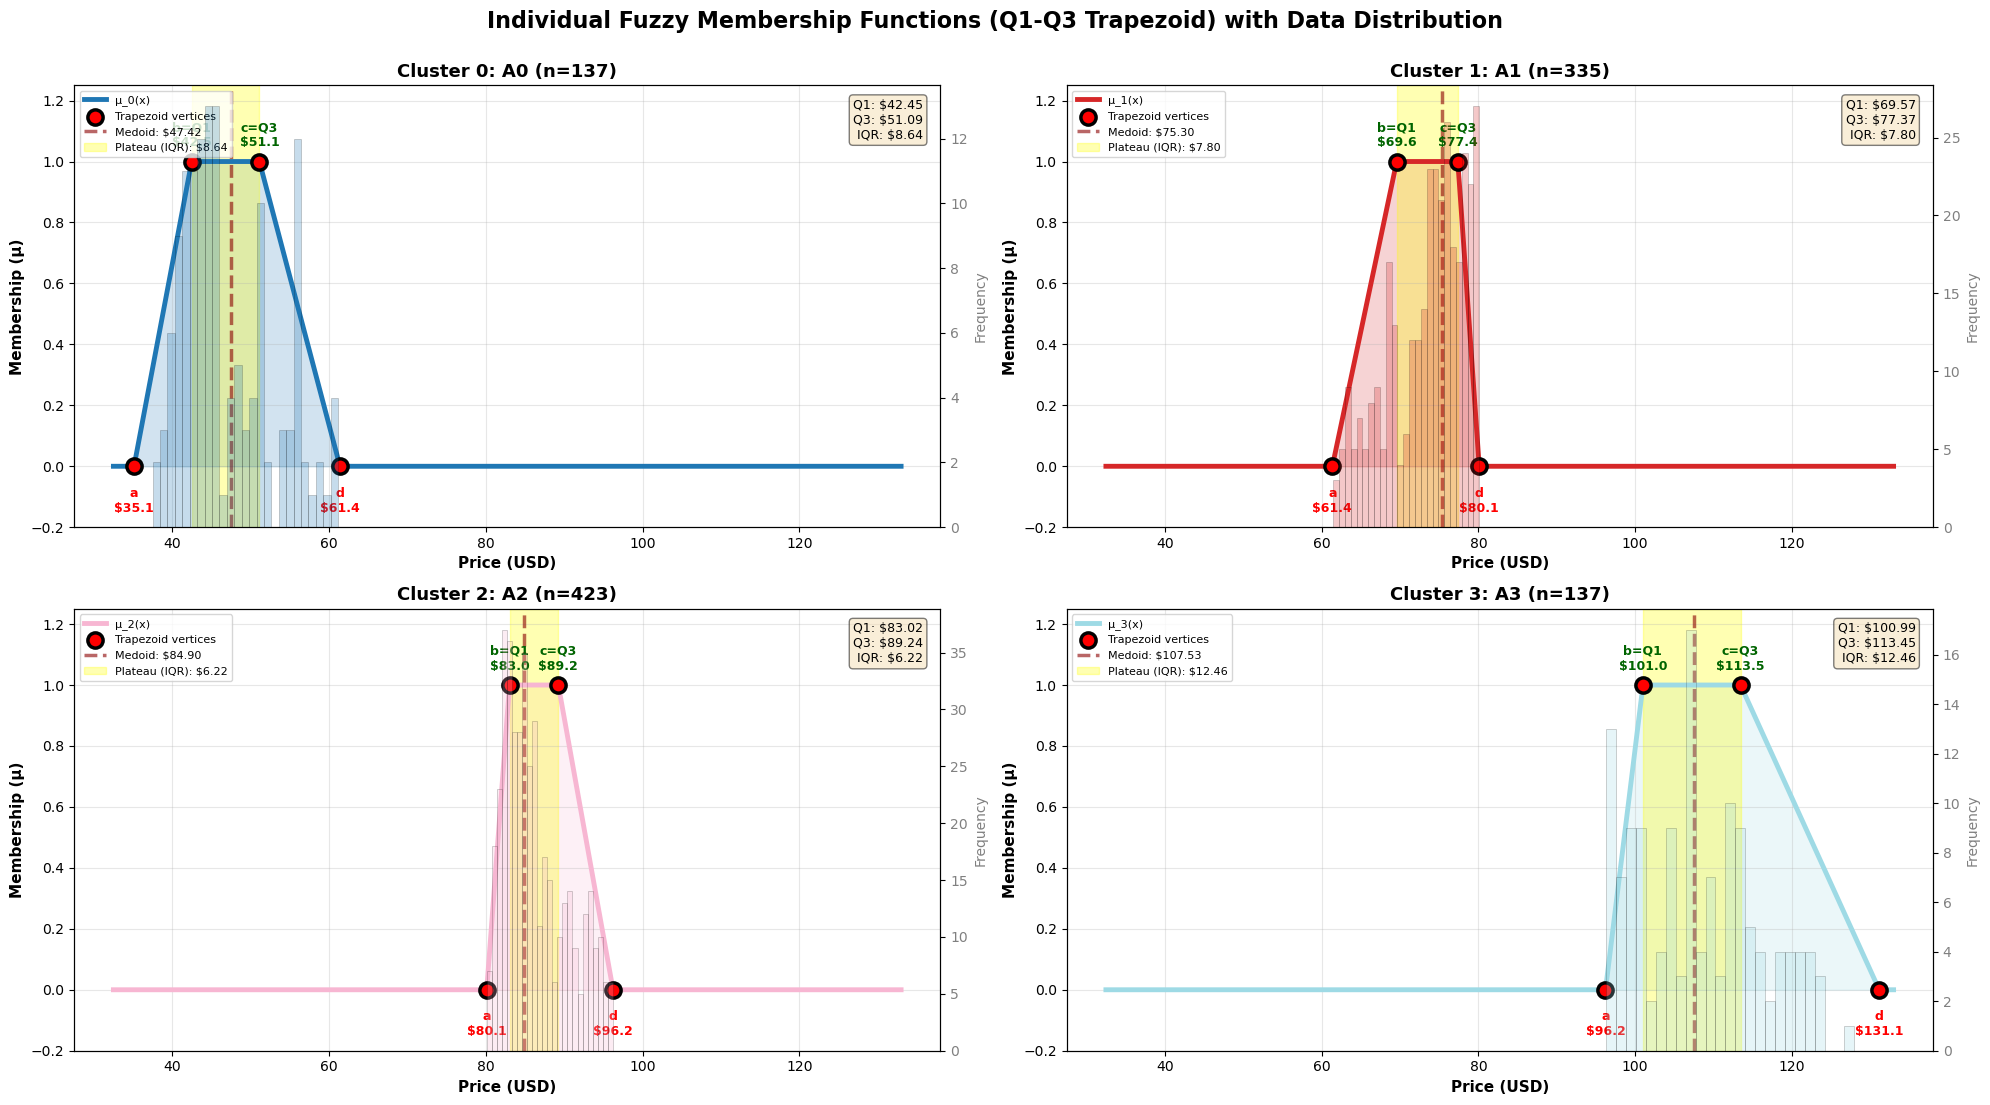

In [53]:
print("\n📊 Creating individual membership function plots...")

fig, axes = plt.subplots(2, 2, figsize=(20, 11))
axes = axes.flatten()

for i in range(k_optimal):
    ax = axes[i]
    params = df_fuzzy_sets.iloc[i]
    
    # Calculate membership
    mu_values = trapezoid_membership(x_dense, params['a'], params['b'], 
                                      params['c'], params['d'])
    
    # Plot membership function
    ax.plot(x_dense, mu_values, linewidth=3.5, color=colors[i], 
            label=f'μ_{i}(x)', zorder=3)
    ax.fill_between(x_dense, 0, mu_values, color=colors[i], alpha=0.2)
    
    # Mark trapezoid key points
    trapezoid_points = [params['a'], params['b'], params['c'], params['d']]
    trapezoid_mu = [0, 1, 1, 0]
    ax.scatter(trapezoid_points, trapezoid_mu, color='red', s=120, 
               zorder=5, edgecolors='black', linewidths=2.5,
               label='Trapezoid vertices')
    
    # Annotate points
    ax.text(params['a'], -0.15, f'a\n${params["a"]:.1f}', 
            ha='center', fontsize=9, color='red', fontweight='bold')
    ax.text(params['b'], 1.05, f'b=Q1\n${params["b"]:.1f}', 
            ha='center', fontsize=9, color='darkgreen', fontweight='bold')
    ax.text(params['c'], 1.05, f'c=Q3\n${params["c"]:.1f}', 
            ha='center', fontsize=9, color='darkgreen', fontweight='bold')
    ax.text(params['d'], -0.15, f'd\n${params["d"]:.1f}', 
            ha='center', fontsize=9, color='red', fontweight='bold')
    
    # Mark medoid
    ax.axvline(params['medoid'], color='darkred', linestyle='--', 
               linewidth=2.5, alpha=0.6, label=f'Medoid: ${params["medoid"]:.2f}')
    
    # Highlight plateau (Q1-Q3)
    ax.axvspan(params['b'], params['c'], alpha=0.3, color='yellow', 
               label=f'Plateau (IQR): ${params["IQR"]:.2f}', zorder=1)
    
    # Actual data distribution (histogram)
    cluster_data = df_train[df_train['Cluster'] == i]['Price'].values
    ax2 = ax.twinx()
    ax2.hist(cluster_data, bins=25, alpha=0.25, color=colors[i], 
             edgecolor='black', linewidth=0.5)
    ax2.set_ylabel('Frequency', fontsize=10, color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')
    
    # Labels and title
    ax.set_xlabel('Price (USD)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Membership (μ)', fontsize=11, fontweight='bold')
    ax.set_title(f'Cluster {i}: A{i} (n={len(cluster_data)})', 
                 fontsize=13, fontweight='bold')
    ax.legend(fontsize=8, loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.2, 1.25)
    
    # Add statistics box
    textstr = f'Q1: ${params["Q1"]:.2f}\nQ3: ${params["Q3"]:.2f}\nIQR: ${params["IQR"]:.2f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.98, 0.97, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='right', bbox=props)

plt.suptitle('Individual Fuzzy Membership Functions (Q1-Q3 Trapezoid) with Data Distribution', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


In [54]:
print("\n🔥 Creating membership heatmap...")

# Sample data for visualization (every 5th point for clarity)
sample_step = 5
sample_data = df_train.iloc[::sample_step].reset_index(drop=True)

# Create heatmap data
heatmap_data = sample_data[[f'mu_A{i}' for i in range(k_optimal)]].T.values

plt.figure(figsize=(18, 7))
im = plt.imshow(heatmap_data, aspect='auto', cmap='YlOrRd', 
                interpolation='nearest', vmin=0, vmax=1)

# Colorbar
cbar = plt.colorbar(im, label='Membership Degree (μ)', pad=0.02)
cbar.ax.tick_params(labelsize=11)

# Labels
plt.yticks(range(k_optimal), [f'A{i}' for i in range(k_optimal)], fontsize=12)
plt.ylabel('Fuzzy Sets', fontsize=13, fontweight='bold')
plt.xlabel('Data Points (sampled every 5th point)', fontsize=13, fontweight='bold')
plt.title('Membership Degree Heatmap - Training Data', fontsize=15, fontweight='bold')

# Add grid
for i in range(k_optimal + 1):
    plt.axhline(i - 0.5, color='white', linewidth=1.5)

plt.tight_layout()
plt.show()


🔥 Creating membership heatmap...



📋 Creating parameter table visualization...


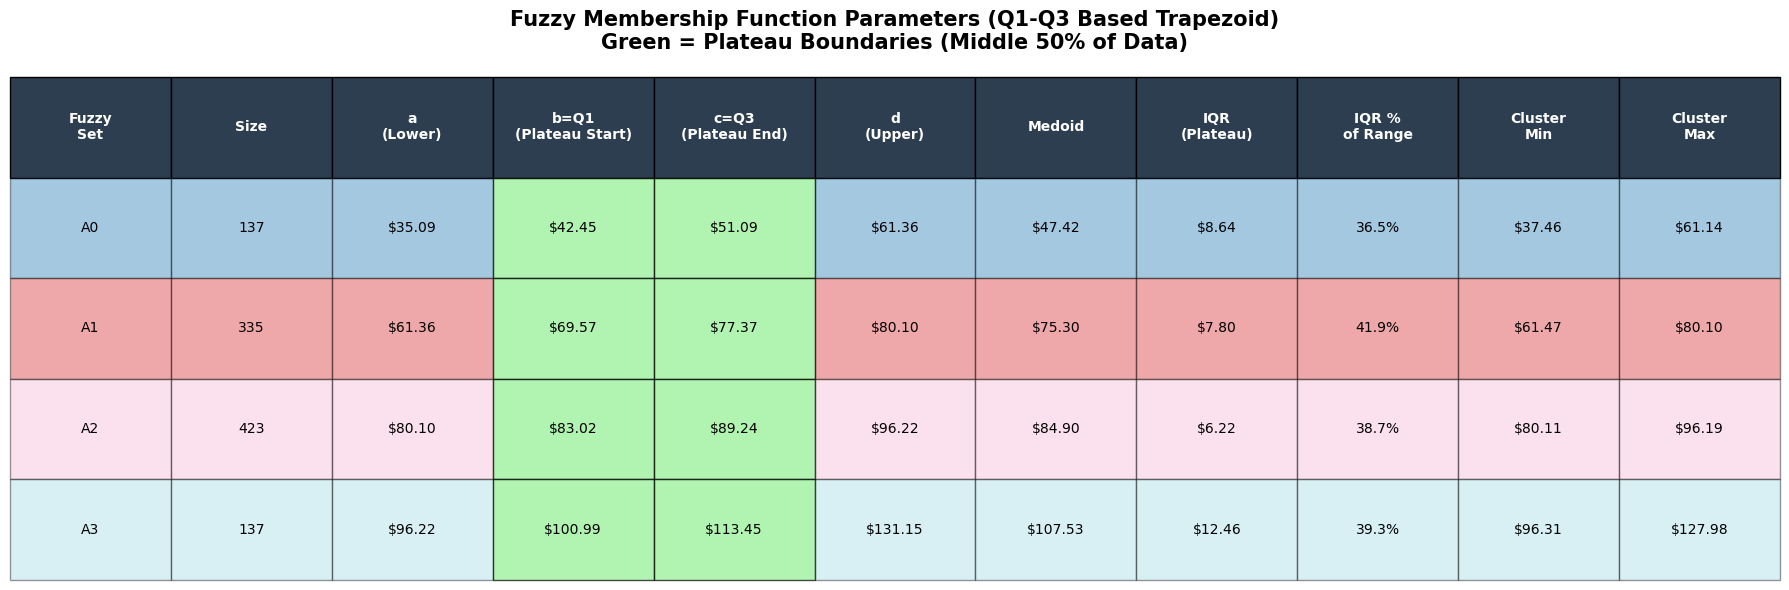

In [55]:
print("\n📋 Creating parameter table visualization...")

fig, ax = plt.subplots(figsize=(18, 6))
ax.axis('off')

table_data = []
for i in range(k_optimal):
    stats = cluster_stats[i]
    params = df_fuzzy_sets.iloc[i]
    cluster_range = stats['max'] - stats['min']
    plateau_pct = (params['IQR'] / cluster_range) * 100
    
    table_data.append([
        f'A{i}',
        stats['size'],
        f"${params['a']:.2f}",
        f"${params['b']:.2f}",
        f"${params['c']:.2f}",
        f"${params['d']:.2f}",
        f"${params['medoid']:.2f}",
        f"${params['IQR']:.2f}",
        f"{plateau_pct:.1f}%",
        f"${stats['min']:.2f}",
        f"${stats['max']:.2f}"
    ])

table = ax.table(
    cellText=table_data,
    colLabels=['Fuzzy\nSet', 'Size', 'a\n(Lower)', 'b=Q1\n(Plateau Start)', 
               'c=Q3\n(Plateau End)', 'd\n(Upper)', 'Medoid', 
               'IQR\n(Plateau)', 'IQR %\nof Range', 'Cluster\nMin', 'Cluster\nMax'],
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1]
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 3)

# Header styling
for i in range(11):
    table[(0, i)].set_facecolor('#2c3e50')
    table[(0, i)].set_text_props(weight='bold', color='white', fontsize=10)

# Row coloring
for i in range(k_optimal):
    for j in range(11):
        table[(i+1, j)].set_facecolor(colors[i])
        table[(i+1, j)].set_alpha(0.4)
        table[(i+1, j)].set_text_props(fontsize=10)

# Highlight Q1-Q3 columns
for i in range(k_optimal):
    table[(i+1, 3)].set_facecolor('lightgreen')
    table[(i+1, 3)].set_alpha(0.7)
    table[(i+1, 4)].set_facecolor('lightgreen')
    table[(i+1, 4)].set_alpha(0.7)

ax.set_title('Fuzzy Membership Function Parameters (Q1-Q3 Based Trapezoid)\nGreen = Plateau Boundaries (Middle 50% of Data)', 
             fontsize=15, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [56]:
print("\n📊 Creating membership scatter plots...")

fig, axes = plt.subplots(2, 2, figsize=(20, 11))
axes = axes.flatten()

for i in range(k_optimal):
    ax = axes[i]
    params = df_fuzzy_sets.iloc[i]
    
    # Scatter plot: Price vs Membership
    scatter = ax.scatter(df_train['Price'], df_train[f'mu_A{i}'], 
                        c=df_train[f'mu_A{i}'], cmap='YlOrRd', 
                        s=25, alpha=0.6, edgecolors='black', linewidths=0.3,
                        vmin=0, vmax=1)
    
    # Mark key boundaries
    ax.axvline(params['a'], color='red', linestyle=':', linewidth=1.5, 
               alpha=0.5, label=f'a=${params["a"]:.1f}')
    ax.axvline(params['b'], color='green', linestyle='--', linewidth=2, 
               alpha=0.7, label=f'Q1=${params["b"]:.1f}')
    ax.axvline(params['c'], color='green', linestyle='--', linewidth=2, 
               alpha=0.7, label=f'Q3=${params["c"]:.1f}')
    ax.axvline(params['d'], color='red', linestyle=':', linewidth=1.5, 
               alpha=0.5, label=f'd=${params["d"]:.1f}')
    ax.axvline(params['medoid'], color='darkred', linestyle='-', linewidth=2.5, 
               alpha=0.8, label=f'Medoid=${params["medoid"]:.1f}')
    
    # Highlight plateau region
    ax.axvspan(params['b'], params['c'], alpha=0.15, color='yellow', zorder=1)
    ax.axhline(1.0, color='black', linestyle='-', linewidth=1, alpha=0.3)
    
    # Colorbar
    plt.colorbar(scatter, ax=ax, label='μ', pad=0.02)
    
    # Labels
    ax.set_xlabel('Price (USD)', fontsize=11, fontweight='bold')
    ax.set_ylabel(f'Membership μ_A{i}', fontsize=11, fontweight='bold')
    ax.set_title(f'Cluster {i}: Membership Degree vs Price', 
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=8, loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.1, 1.15)


📊 Creating membership scatter plots...


### 5.3.2. Build Model FTSMC

In [69]:
# ============================================================================
# STEP 1: ASSIGN FUZZY STATES BASED ON MEMBERSHIP FUNCTION
# ============================================================================
print("\n📊 STEP 1: Assigning Fuzzy States to Training Data")
print("-"*100)

# Fungsi untuk menentukan fuzzy state berdasarkan membership maksimum
def assign_fuzzy_state(row, k_optimal):
    """
    Assign fuzzy state based on maximum membership degree
    """
    memberships = [row[f'mu_A{i}'] for i in range(k_optimal)]
    max_membership = max(memberships)
    
    # Jika ada membership yang sama (tie), pilih state dengan index terkecil
    fuzzy_state = memberships.index(max_membership)
    
    return fuzzy_state, max_membership

# Assign fuzzy states
fuzzy_states = []
max_memberships = []

for idx, row in df_train.iterrows():
    state, max_mu = assign_fuzzy_state(row, k_optimal)
    fuzzy_states.append(state)
    max_memberships.append(max_mu)

df_train['Fuzzy_State'] = fuzzy_states
df_train['Max_Membership'] = max_memberships

# Tampilkan hasil assignment
print("\n✅ Fuzzy State Assignment Complete!")
print(f"\nSample Results (first 20 rows):")
sample_cols = ['Date', 'Price', 'Cluster'] + [f'mu_A{i}' for i in range(k_optimal)] + ['Fuzzy_State', 'Max_Membership']
print(df_train[sample_cols].head(20).to_string(index=False))

# Statistik fuzzy states
print("\n📈 Fuzzy State Distribution:")
state_counts = df_train['Fuzzy_State'].value_counts().sort_index()
for state in range(k_optimal):
    count = state_counts.get(state, 0)
    percentage = (count / len(df_train)) * 100


📊 STEP 1: Assigning Fuzzy States to Training Data
----------------------------------------------------------------------------------------------------

✅ Fuzzy State Assignment Complete!

Sample Results (first 20 rows):
      Date  Price  Cluster  mu_A0  mu_A1  mu_A2  mu_A3  Fuzzy_State  Max_Membership
2020-08-03  44.15        0    1.0    0.0    0.0    0.0            0             1.0
2020-08-04  44.43        0    1.0    0.0    0.0    0.0            0             1.0
2020-08-05  45.17        0    1.0    0.0    0.0    0.0            0             1.0
2020-08-06  45.09        0    1.0    0.0    0.0    0.0            0             1.0
2020-08-07  44.40        0    1.0    0.0    0.0    0.0            0             1.0
2020-08-10  44.99        0    1.0    0.0    0.0    0.0            0             1.0
2020-08-11  44.50        0    1.0    0.0    0.0    0.0            0             1.0
2020-08-12  45.43        0    1.0    0.0    0.0    0.0            0             1.0
2020-08-13  44.96      

In [70]:
# ============================================================================
# STEP 2: CREATE FUZZY LOGICAL RELATIONSHIPS (FLR)
# ============================================================================
print("\n" + "="*100)
print("📊 STEP 2: Creating Fuzzy Logical Relationships (FLR)")
print("-"*100)

# ✅ PERBAIKAN: Gunakan vectorized operations untuk efisiensi
df_train_indexed = df_train.reset_index(drop=True)  # Pastikan index berurutan

# Buat FLR menggunakan shift() - jauh lebih cepat!
df_flr = pd.DataFrame({
    'Index': df_train_indexed.index[1:],  # Mulai dari index 1
    'Date': df_train_indexed['Date'].iloc[1:].values,
    'Previous_State': df_train_indexed['Fuzzy_State'].iloc[:-1].values,
    'Current_State': df_train_indexed['Fuzzy_State'].iloc[1:].values,
    'Previous_Price': df_train_indexed['Price'].iloc[:-1].values,
    'Current_Price': df_train_indexed['Price'].iloc[1:].values
})

# Buat kolom FLR string
df_flr['FLR'] = df_flr.apply(lambda row: f"A{row['Previous_State']} → A{row['Current_State']}", axis=1)

# Reset index
df_flr = df_flr.reset_index(drop=True)

print(f"\n✅ Total FLR Created: {len(df_flr)}")
print(f"\nSample FLR (first 20 relationships):")
print(df_flr[['Date', 'Previous_State', 'Current_State', 'FLR', 'Previous_Price', 'Current_Price']].head(20).to_string(index=False))

# Hitung frekuensi setiap FLR
flr_frequency = df_flr['FLR'].value_counts()
print(f"\n📊 Top 10 Most Frequent FLR:")
print(flr_frequency.head(10))

# ✅ TAMBAHAN: Statistik transisi
print(f"\n📈 FLR Statistics:")
print(f"  Total unique FLR patterns: {len(flr_frequency)}")
print(f"  Most common transition: {flr_frequency.index[0]} ({flr_frequency.iloc[0]} times)")


📊 STEP 2: Creating Fuzzy Logical Relationships (FLR)
----------------------------------------------------------------------------------------------------

✅ Total FLR Created: 1031

Sample FLR (first 20 relationships):
      Date  Previous_State  Current_State     FLR  Previous_Price  Current_Price
2020-08-04               0              0 A0 → A0           44.15          44.43
2020-08-05               0              0 A0 → A0           44.43          45.17
2020-08-06               0              0 A0 → A0           45.17          45.09
2020-08-07               0              0 A0 → A0           45.09          44.40
2020-08-10               0              0 A0 → A0           44.40          44.99
2020-08-11               0              0 A0 → A0           44.99          44.50
2020-08-12               0              0 A0 → A0           44.50          45.43
2020-08-13               0              0 A0 → A0           45.43          44.96
2020-08-14               0              0 A0 → A0  

In [71]:
# ============================================================================
# STEP 3: CREATE FUZZY LOGICAL RELATIONSHIP GROUPS (FLRG)
# ============================================================================
print("\n" + "="*100)
print("📊 STEP 3: Creating Fuzzy Logical Relationship Groups (FLRG)")
print("-"*100)

# ✅ PERBAIKAN: Gunakan groupby untuk efisiensi
flrg_dict = df_flr.groupby('Previous_State')['Current_State'].apply(list).to_dict()

# Buat FLRG summary
flrg_summary = []
for state in range(k_optimal):
    if state in flrg_dict:
        transitions = flrg_dict[state]
        unique_transitions = sorted(set(transitions))
        
        # Hitung frekuensi setiap transisi
        transition_counts = pd.Series(transitions).value_counts().to_dict()
        
        flrg_summary.append({
            'State': f'A{state}',
            'Total_Transitions': len(transitions),
            'Unique_States': unique_transitions,
            'Transition_Counts': transition_counts,
            'FLRG': f"A{state} → {{{', '.join([f'A{s}' for s in unique_transitions])}}}"  # ✅ Tambah kurung kurawal
        })
    else:
        # ✅ PERBAIKAN: Handle state yang tidak pernah muncul sebagai previous state
        flrg_summary.append({
            'State': f'A{state}',
            'Total_Transitions': 0,
            'Unique_States': [],
            'Transition_Counts': {},
            'FLRG': f"A{state} → ∅ (No transitions)"
        })

df_flrg = pd.DataFrame(flrg_summary)

print("\n✅ FLRG Created Successfully!")
print("\n" + "-"*100)
print("FUZZY LOGICAL RELATIONSHIP GROUPS (FLRG)")
print("-"*100)
for idx, row in df_flrg.iterrows():
    print(f"\n{row['State']}:")
    print(f"  FLRG: {row['FLRG']}")
    print(f"  Total Transitions: {row['Total_Transitions']}")
    if row['Transition_Counts']:
        print(f"  Transition Details:")
        for to_state, count in sorted(row['Transition_Counts'].items()):
            percentage = (count / row['Total_Transitions']) * 100
            print(f"    → A{to_state}: {count:4d} times ({percentage:5.2f}%)")


📊 STEP 3: Creating Fuzzy Logical Relationship Groups (FLRG)
----------------------------------------------------------------------------------------------------

✅ FLRG Created Successfully!

----------------------------------------------------------------------------------------------------
FUZZY LOGICAL RELATIONSHIP GROUPS (FLRG)
----------------------------------------------------------------------------------------------------

A0:
  FLRG: A0 → {A0, A1}
  Total Transitions: 137
  Transition Details:
    → A0:  134 times (97.81%)
    → A1:    3 times ( 2.19%)

A1:
  FLRG: A1 → {A0, A1, A2}
  Total Transitions: 334
  Transition Details:
    → A0:    2 times ( 0.60%)
    → A1:  315 times (94.31%)
    → A2:   17 times ( 5.09%)

A2:
  FLRG: A2 → {A1, A2, A3}
  Total Transitions: 423
  Transition Details:
    → A1:   17 times ( 4.02%)
    → A2:  398 times (94.09%)
    → A3:    8 times ( 1.89%)

A3:
  FLRG: A3 → {A2, A3}
  Total Transitions: 137
  Transition Details:
    → A2:    8 times

In [72]:
# ============================================================================
# STEP 4: CREATE MARKOV TRANSITION PROBABILITY MATRIX
# ============================================================================
print("\n" + "="*100)
print("📊 STEP 4: Creating Markov Transition Probability Matrix")
print("-"*100)

# Initialize transition matrix
transition_matrix = np.zeros((k_optimal, k_optimal))

# Hitung transition probabilities
for state in range(k_optimal):
    if state in flrg_dict:
        transitions = flrg_dict[state]
        total = len(transitions)
        
        for to_state in range(k_optimal):
            count = transitions.count(to_state)
            transition_matrix[state, to_state] = count / total if total > 0 else 0

# Buat DataFrame untuk tampilan yang lebih baik
transition_df = pd.DataFrame(
    transition_matrix,
    index=[f'A{i}' for i in range(k_optimal)],
    columns=[f'A{i}' for i in range(k_optimal)]
)

print("\n✅ Transition Probability Matrix Created!")
print("\n" + "-"*100)
print("MARKOV TRANSITION PROBABILITY MATRIX")
print("-"*100)
print("\nP = ")
print(transition_df.to_string(float_format=lambda x: f'{x:.4f}'))

# Validasi: setiap baris harus sum = 1
print("\n🔍 Matrix Validation:")
row_sums = transition_matrix.sum(axis=1)
print("Row sums (should all be 1.0 or 0.0 for states with no transitions):")
for i, row_sum in enumerate(row_sums):
    status = "✓" if abs(row_sum - 1.0) < 0.001 or row_sum == 0 else "✗"
    print(f"  A{i}: {row_sum:.6f} {status}")


📊 STEP 4: Creating Markov Transition Probability Matrix
----------------------------------------------------------------------------------------------------

✅ Transition Probability Matrix Created!

----------------------------------------------------------------------------------------------------
MARKOV TRANSITION PROBABILITY MATRIX
----------------------------------------------------------------------------------------------------

P = 
       A0     A1     A2     A3
A0 0.9781 0.0219 0.0000 0.0000
A1 0.0060 0.9431 0.0509 0.0000
A2 0.0000 0.0402 0.9409 0.0189
A3 0.0000 0.0000 0.0584 0.9416

🔍 Matrix Validation:
Row sums (should all be 1.0 or 0.0 for states with no transitions):
  A0: 1.000000 ✓
  A1: 1.000000 ✓
  A2: 1.000000 ✓
  A3: 1.000000 ✓


In [73]:
# ============================================================================
# STEP 5: FORECASTING USING FTSMC (SEPARATED INITIAL & FINAL)
# ============================================================================
print("\n" + "="*100)
print("📊 STEP 5: Forecasting using FTSMC (Initial & Final Forecast)")
print("-"*100)

# Midpoint dari setiap fuzzy set (untuk defuzzification)
midpoints = []
for i in range(k_optimal):
    params = df_fuzzy_sets.iloc[i]
    midpoint = (params['b'] + params['c']) / 2  # Midpoint dari plateau (Q1 dan Q3)
    midpoints.append(midpoint)

print(f"\n📍 Midpoints for each Fuzzy Set:")
for i, mid in enumerate(midpoints):
    print(f"  A{i}: ${mid:.2f}")

# Fungsi forecasting INITIAL (tanpa adjustment)
def forecast_ftsmc_initial(current_state, current_price, transition_matrix, midpoints):
    """
    Initial forecast using FTSMC (before adjustment)
    
    Rules:
    1. If no FLR (empty state): return midpoint
    2. If one-to-one relationship: return target midpoint
    3. If one-to-many: use weighted average based on transition probabilities
    """
    probabilities = transition_matrix[current_state]
    
    # Rule 1: No transitions
    if probabilities.sum() == 0:
        return midpoints[current_state]
    
    # Rule 2 & 3: Calculate weighted forecast
    forecast = 0
    for to_state in range(len(midpoints)):
        if to_state == current_state:
            # Use current price instead of midpoint for same state (Rule 3 formula)
            forecast += current_price * probabilities[to_state]
        else:
            forecast += midpoints[to_state] * probabilities[to_state]
    
    return forecast

# Lakukan forecasting untuk training data
print("\n🔄 Processing Training Data Forecasts...")
print("-"*100)

forecast_results = []

for i in range(len(df_train)):
    if i == 0:
        # First data point - no previous state
        forecast_results.append({
            'Index': i,
            'Date': df_train.loc[i, 'Date'],
            'Y(t)': df_train.loc[i, 'Price'],
            'Y(t-1)': None,
            'diff(Y(t))': 0,
            'Fuzzy_State_t-1': None,
            'Initial_Forecast_F(t)': None,
            'Final_Forecast_F^(t)': None
        })
    else:
        # Get data
        current_price = df_train.loc[i, 'Price']
        prev_price = df_train.loc[i-1, 'Price']
        prev_state = df_train.loc[i-1, 'Fuzzy_State']
        
        # Calculate diff(Y(t)) = Y(t) - Y(t-1)
        diff_yt = current_price - prev_price
        
        # Initial forecast F(t)
        initial_forecast = forecast_ftsmc_initial(prev_state, prev_price, transition_matrix, midpoints)
        
        # Final forecast F^(t) = F(t) + diff(Y(t-1))
        # diff(Y(t-1)) is the difference for the PREVIOUS time step
        if i == 1:
            diff_yt_minus1 = 0  # No diff for t=1
        else:
            diff_yt_minus1 = df_train.loc[i-1, 'Price'] - df_train.loc[i-2, 'Price']
        
        final_forecast = initial_forecast + diff_yt_minus1
        
        forecast_results.append({
            'Index': i,
            'Date': df_train.loc[i, 'Date'],
            'Y(t)': current_price,
            'Y(t-1)': prev_price,
            'diff(Y(t))': diff_yt,
            'Fuzzy_State_t-1': f'A{prev_state}',
            'Initial_Forecast_F(t)': initial_forecast,
            'Final_Forecast_F^(t)': final_forecast
        })

df_forecast_train = pd.DataFrame(forecast_results)

print("\n✅ Forecasting Complete!")
print(f"\n📋 Sample Forecast Results (first 30 rows):")
print(df_forecast_train.head(30).to_string(index=False, float_format=lambda x: f'{x:.2f}' if pd.notna(x) else 'NaN'))

print(f"\n📋 Sample Forecast Results (last 20 rows):")
print(df_forecast_train.tail(20).to_string(index=False, float_format=lambda x: f'{x:.2f}' if pd.notna(x) else 'NaN'))


📊 STEP 5: Forecasting using FTSMC (Initial & Final Forecast)
----------------------------------------------------------------------------------------------------

📍 Midpoints for each Fuzzy Set:
  A0: $46.77
  A1: $73.47
  A2: $86.13
  A3: $107.22

🔄 Processing Training Data Forecasts...
----------------------------------------------------------------------------------------------------

✅ Forecasting Complete!

📋 Sample Forecast Results (first 30 rows):
 Index       Date  Y(t)  Y(t-1)  diff(Y(t)) Fuzzy_State_t-1  Initial_Forecast_F(t)  Final_Forecast_F^(t)
     0 2020-08-03 44.15     NaN        0.00            None                    NaN                   NaN
     1 2020-08-04 44.43   44.15        0.28              A0                  44.79                 44.79
     2 2020-08-05 45.17   44.43        0.74              A0                  45.07                 45.35
     3 2020-08-06 45.09   45.17       -0.08              A0                  45.79                 46.53
     4 2020-08-

In [74]:
# ============================================================================
# STEP 6: CALCULATE FORECASTING ACCURACY (INITIAL vs FINAL)
# ============================================================================
print("\n" + "="*100)
print("📊 STEP 6: Calculating Forecasting Accuracy (Initial vs Final)")
print("-"*100)

# Remove first row (no forecast for first data point)
df_forecast_eval = df_forecast_train[1:].copy()

# Actual values
actual = df_forecast_eval['Y(t)'].values

# Initial forecast values
initial_pred = df_forecast_eval['Initial_Forecast_F(t)'].values

# Final forecast values
final_pred = df_forecast_eval['Final_Forecast_F^(t)'].values

# ===== INITIAL FORECAST ACCURACY =====
print("\n" + "="*60)
print("📈 INITIAL FORECAST ACCURACY (F(t))")
print("="*60)

initial_mae = mean_absolute_error(actual, initial_pred)
initial_mse = mean_squared_error(actual, initial_pred)
initial_rmse = np.sqrt(initial_mse)
initial_mape = mean_absolute_percentage_error(actual, initial_pred) * 100

print(f"\n  MAE  (Mean Absolute Error)           : ${initial_mae:.4f}")
print(f"  MSE  (Mean Squared Error)            : ${initial_mse:.4f}")
print(f"  RMSE (Root Mean Squared Error)       : ${initial_rmse:.4f}")
print(f"  MAPE (Mean Absolute Percentage Error): {initial_mape:.4f}%")

# Interpretasi akurasi
def interpret_accuracy(mae_value):
    if mae_value <= 10:
        return "EXCELLENT ⭐⭐⭐"
    elif mae_value <= 20:
        return "GOOD ⭐⭐"
    elif mae_value <= 50:
        return "FAIR ⭐"
    else:
        return "POOR"

initial_accuracy_level = interpret_accuracy(initial_mae)
print(f"\n  Accuracy Level: {initial_accuracy_level}")

# ===== FINAL FORECAST ACCURACY =====
print("\n" + "="*60)
print("📈 FINAL FORECAST ACCURACY (F^(t) - Adjusted)")
print("="*60)

final_mae = mean_absolute_error(actual, final_pred)
final_mse = mean_squared_error(actual, final_pred)
final_rmse = np.sqrt(final_mse)
final_mape = mean_absolute_percentage_error(actual, final_pred) * 100

print(f"\n  MAE  (Mean Absolute Error)           : ${final_mae:.4f}")
print(f"  MSE  (Mean Squared Error)            : ${final_mse:.4f}")
print(f"  RMSE (Root Mean Squared Error)       : ${final_rmse:.4f}")
print(f"  MAPE (Mean Absolute Percentage Error): {final_mape:.4f}%")

final_accuracy_level = interpret_accuracy(final_mae)
print(f"\n  Accuracy Level: {final_accuracy_level}")

# ===== COMPARISON =====
print("\n" + "="*60)
print("🔍 COMPARISON: INITIAL vs FINAL FORECAST")
print("="*60)

comparison_data = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'MAPE (%)'],
    'Initial_F(t)': [initial_mae, initial_mse, initial_rmse, initial_mape],
    'Final_F^(t)': [final_mae, final_mse, final_rmse, final_mape],
    'Improvement': [
        initial_mae - final_mae,
        initial_mse - final_mse,
        initial_rmse - final_rmse,
        initial_mape - final_mape
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print("\n" + df_comparison.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

# Determine which is better
print("\n🏆 WINNER:")
if final_mae < initial_mae:
    improvement_pct = ((initial_mae - final_mae) / initial_mae) * 100
    print(f"  Final Forecast (Adjusted) is BETTER by {improvement_pct:.2f}%")
    print(f"  ✅ Adjustment with diff(Y(t)) IMPROVES accuracy!")
else:
    degradation_pct = ((final_mae - initial_mae) / initial_mae) * 100
    print(f"  Initial Forecast is BETTER by {degradation_pct:.2f}%")
    print(f"  ⚠️  Adjustment with diff(Y(t)) DECREASES accuracy!")



📊 STEP 6: Calculating Forecasting Accuracy (Initial vs Final)
----------------------------------------------------------------------------------------------------

📈 INITIAL FORECAST ACCURACY (F(t))

  MAE  (Mean Absolute Error)           : $1.3816
  MSE  (Mean Squared Error)            : $3.9628
  RMSE (Root Mean Squared Error)       : $1.9907
  MAPE (Mean Absolute Percentage Error): 1.6957%

  Accuracy Level: EXCELLENT ⭐⭐⭐

📈 FINAL FORECAST ACCURACY (F^(t) - Adjusted)

  MAE  (Mean Absolute Error)           : $1.9144
  MSE  (Mean Squared Error)            : $7.4597
  RMSE (Root Mean Squared Error)       : $2.7312
  MAPE (Mean Absolute Percentage Error): 2.3601%

  Accuracy Level: EXCELLENT ⭐⭐⭐

🔍 COMPARISON: INITIAL vs FINAL FORECAST

  Metric  Initial_F(t)  Final_F^(t)  Improvement
     MAE        1.3816       1.9144      -0.5328
     MSE        3.9628       7.4597      -3.4969
    RMSE        1.9907       2.7312      -0.7406
MAPE (%)        1.6957       2.3601      -0.6644

🏆 WINN

In [75]:
# ============================================================================
# STEP 7: VISUALIZE FORECASTING RESULTS (INITIAL vs FINAL)
# ============================================================================
print("\n" + "="*100)
print("📊 STEP 7: Visualizing Forecasting Results (Initial vs Final)")
print("-"*100)

# Plot 1: Actual vs Initial vs Final (Full Time Series)
plt.figure(figsize=(20, 7))
plt.plot(df_forecast_train['Date'], df_forecast_train['Y(t)'], 
         label='Actual Price', color='blue', linewidth=2.5, alpha=0.8)
plt.plot(df_forecast_train['Date'], df_forecast_train['Initial_Forecast_F(t)'], 
         label='Initial Forecast F(t)', color='orange', linewidth=1.5, alpha=0.7)
plt.plot(df_forecast_train['Date'], df_forecast_train['Final_Forecast_F^(t)'], 
         label='Final Forecast F^(t) (Adjusted)', color='red', linewidth=1.5, alpha=0.7)
plt.xlabel('Date', fontsize=13, fontweight='bold')
plt.ylabel('Price (USD)', fontsize=13, fontweight='bold')
plt.title('Brent Oil Price: Actual vs FTSMC Forecasts (Training Data)\nInitial F(t) vs Final F^(t)', 
          fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


📊 STEP 7: Visualizing Forecasting Results (Initial vs Final)
----------------------------------------------------------------------------------------------------


In [76]:
# Plot 2: Detailed view (First 100 days)
plt.figure(figsize=(18, 7))
n_display = min(100, len(df_forecast_train))
plt.plot(df_forecast_train['Date'][:n_display], df_forecast_train['Y(t)'][:n_display], 
         'o-', label='Actual Price', color='blue', linewidth=2.5, markersize=6)
plt.plot(df_forecast_train['Date'][:n_display], df_forecast_train['Initial_Forecast_F(t)'][:n_display], 
         's-', label='Initial Forecast F(t)', color='orange', linewidth=2, markersize=5, alpha=0.7)
plt.plot(df_forecast_train['Date'][:n_display], df_forecast_train['Final_Forecast_F^(t)'][:n_display], 
         '^-', label='Final Forecast F^(t)', color='red', linewidth=2, markersize=5, alpha=0.7)
plt.xlabel('Date', fontsize=13, fontweight='bold')
plt.ylabel('Price (USD)', fontsize=13, fontweight='bold')
plt.title(f'Detailed View: Actual vs FTSMC Forecasts (First {n_display} Days)', 
          fontsize=15, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

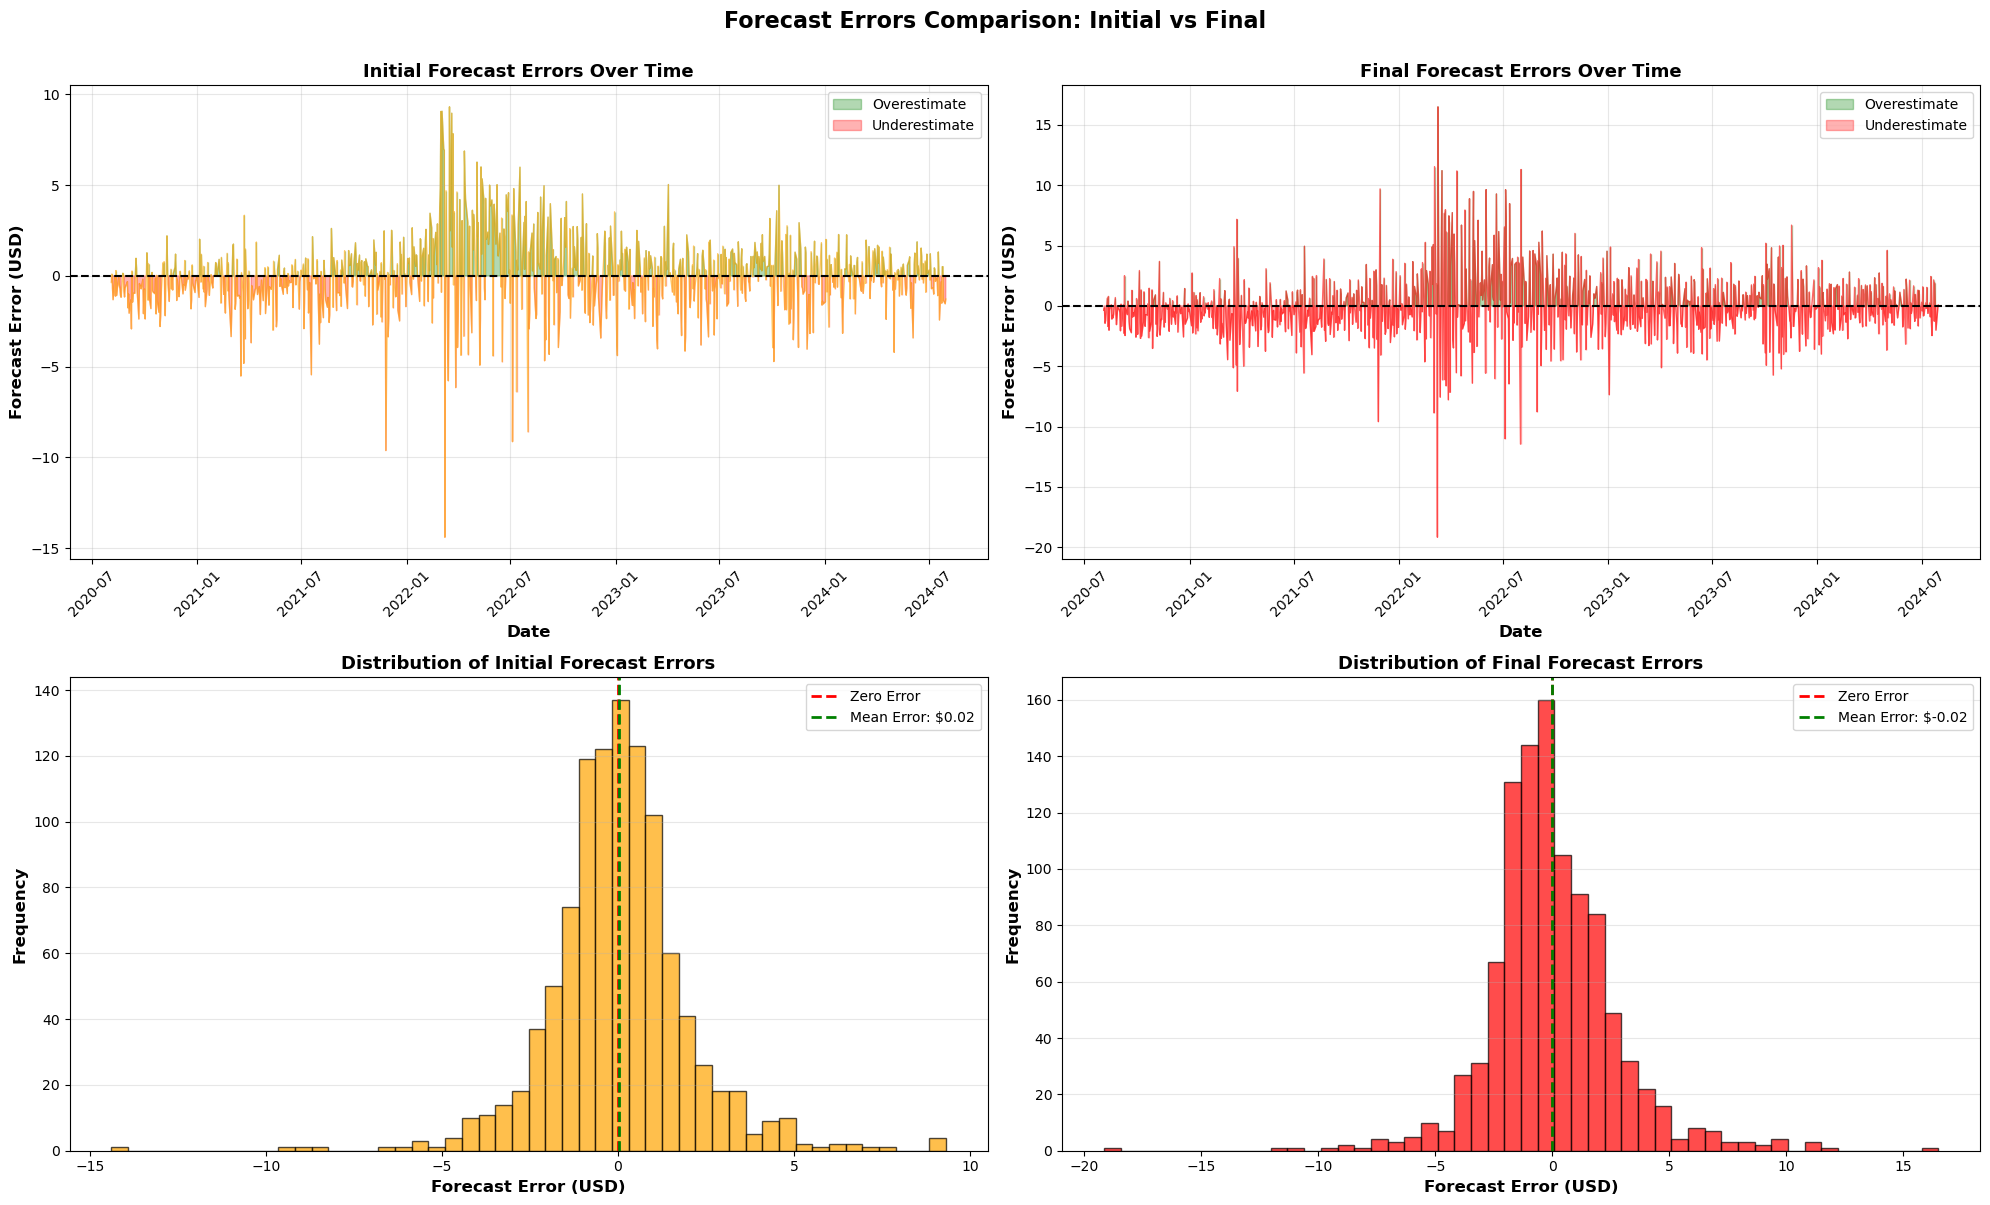

In [77]:
# Plot 3: Forecast Errors Comparison
errors_initial = df_forecast_eval['Y(t)'] - df_forecast_eval['Initial_Forecast_F(t)']
errors_final = df_forecast_eval['Y(t)'] - df_forecast_eval['Final_Forecast_F^(t)']

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Error over time - Initial
axes[0, 0].plot(df_forecast_eval['Date'], errors_initial, color='orange', linewidth=1, alpha=0.6)
axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=1.5)
axes[0, 0].fill_between(df_forecast_eval['Date'], errors_initial, 0, 
                         where=(errors_initial > 0), color='green', alpha=0.3, label='Overestimate')
axes[0, 0].fill_between(df_forecast_eval['Date'], errors_initial, 0, 
                         where=(errors_initial < 0), color='red', alpha=0.3, label='Underestimate')
axes[0, 0].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Forecast Error (USD)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Initial Forecast Errors Over Time', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Error over time - Final
axes[0, 1].plot(df_forecast_eval['Date'], errors_final, color='red', linewidth=1, alpha=0.6)
axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=1.5)
axes[0, 1].fill_between(df_forecast_eval['Date'], errors_final, 0, 
                         where=(errors_final > 0), color='green', alpha=0.3, label='Overestimate')
axes[0, 1].fill_between(df_forecast_eval['Date'], errors_final, 0, 
                         where=(errors_final < 0), color='red', alpha=0.3, label='Underestimate')
axes[0, 1].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Forecast Error (USD)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Final Forecast Errors Over Time', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Error distribution - Initial
axes[1, 0].hist(errors_initial, bins=50, color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1, 0].axvline(x=errors_initial.mean(), color='green', linestyle='--', linewidth=2, 
                    label=f'Mean Error: ${errors_initial.mean():.2f}')
axes[1, 0].set_xlabel('Forecast Error (USD)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Distribution of Initial Forecast Errors', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Error distribution - Final
axes[1, 1].hist(errors_final, bins=50, color='red', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1, 1].axvline(x=errors_final.mean(), color='green', linestyle='--', linewidth=2, 
                    label=f'Mean Error: ${errors_final.mean():.2f}')
axes[1, 1].set_xlabel('Forecast Error (USD)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Distribution of Final Forecast Errors', fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Forecast Errors Comparison: Initial vs Final', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [78]:
# Plot 4: Scatter Plots (Actual vs Predicted)
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Scatter - Initial
axes[0].scatter(df_forecast_eval['Y(t)'], df_forecast_eval['Initial_Forecast_F(t)'], 
                alpha=0.5, s=30, c='orange', edgecolors='black', linewidths=0.5)
min_val = min(df_forecast_eval['Y(t)'].min(), df_forecast_eval['Initial_Forecast_F(t)'].min())
max_val = max(df_forecast_eval['Y(t)'].max(), df_forecast_eval['Initial_Forecast_F(t)'].max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price (USD)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Price (USD)', fontsize=12, fontweight='bold')
axes[0].set_title(f'Initial Forecast\nMAE: ${initial_mae:.2f}, RMSE: ${initial_rmse:.2f}', 
                  fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Scatter - Final
axes[1].scatter(df_forecast_eval['Y(t)'], df_forecast_eval['Final_Forecast_F^(t)'], 
                alpha=0.5, s=30, c='red', edgecolors='black', linewidths=0.5)
min_val = min(df_forecast_eval['Y(t)'].min(), df_forecast_eval['Final_Forecast_F^(t)'].min())
max_val = max(df_forecast_eval['Y(t)'].max(), df_forecast_eval['Final_Forecast_F^(t)'].max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Price (USD)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Predicted Price (USD)', fontsize=12, fontweight='bold')
axes[1].set_title(f'Final Forecast (Adjusted)\nMAE: ${final_mae:.2f}, RMSE: ${final_rmse:.2f}', 
                  fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Actual vs Predicted Prices: Initial vs Final Forecast', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


In [79]:
# Plot 5: Error Magnitude Comparison
plt.figure(figsize=(18, 7))
abs_errors_initial = np.abs(errors_initial)
abs_errors_final = np.abs(errors_final)

x_range = range(len(abs_errors_initial))
plt.plot(x_range, abs_errors_initial, label='Initial Forecast Error', 
         color='orange', linewidth=1.5, alpha=0.7)
plt.plot(x_range, abs_errors_final, label='Final Forecast Error', 
         color='red', linewidth=1.5, alpha=0.7)
plt.axhline(y=initial_mae, color='orange', linestyle='--', linewidth=1.5, 
            label=f'Initial MAE: ${initial_mae:.2f}')
plt.axhline(y=final_mae, color='red', linestyle='--', linewidth=1.5, 
            label=f'Final MAE: ${final_mae:.2f}')
plt.xlabel('Observation Index', fontsize=12, fontweight='bold')
plt.ylabel('Absolute Error (USD)', fontsize=12, fontweight='bold')
plt.title('Absolute Forecast Errors: Initial vs Final', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [80]:
# ============================================================================
# STEP 8: FORECASTING ON TESTING DATA (ONE-STEP-AHEAD ITERATIVELY)
# ============================================================================
print("\n" + "="*100)
print("📊 STEP 8: Forecasting on Testing Data (One-Step-Ahead)")
print("="*100)
print("\n⚠️  IMPORTANT: Testing forecast is done ONE STEP at a time")
print("   because we need actual Y(t) to calculate diff(Y(t)) for next prediction.")
print("-"*100)

# Assign fuzzy states to test data first
print("\n🔄 Assigning fuzzy states to testing data...")

# Calculate membership for test data
n_test = len(df_test)
membership_matrix_test = np.zeros((n_test, k_optimal))

for i in range(k_optimal):
    params = df_fuzzy_sets.iloc[i]
    membership_matrix_test[:, i] = trapezoid_membership(
        df_test['Price'].values,
        params['a'], params['b'], params['c'], params['d']
    )

# Add membership columns
for i in range(k_optimal):
    df_test[f'mu_A{i}'] = membership_matrix_test[:, i]

# Assign fuzzy states to test data
fuzzy_states_test = []
max_memberships_test = []

for idx in df_test.index:
    row = df_test.loc[idx]
    state, max_mu = assign_fuzzy_state(row, k_optimal)
    fuzzy_states_test.append(state)
    max_memberships_test.append(max_mu)

df_test['Fuzzy_State'] = fuzzy_states_test
df_test['Max_Membership'] = max_memberships_test

print("✅ Fuzzy states assigned to testing data!")

# Now perform one-step-ahead forecasting
print("\n🔄 Performing one-step-ahead forecasting on testing data...")
print("-"*100)

forecast_results_test = []

# Get last training data point for initial forecast
last_train_price = df_train.iloc[-1]['Price']
last_train_state = df_train.iloc[-1]['Fuzzy_State']
second_last_train_price = df_train.iloc[-2]['Price']

for i in range(len(df_test)):
    current_idx = df_test.index[i]
    current_price = df_test.loc[current_idx, 'Price']
    
    if i == 0:
        # First test point - use last training data
        prev_price = last_train_price
        prev_state = last_train_state
        diff_yt_minus1 = last_train_price - second_last_train_price
    else:
        # Use previous test point
        prev_idx = df_test.index[i-1]
        prev_price = df_test.loc[prev_idx, 'Price']
        prev_state = df_test.loc[prev_idx, 'Fuzzy_State']
        
        # Calculate diff from previous step
        if i == 1:
            diff_yt_minus1 = df_test.iloc[0]['Price'] - last_train_price
        else:
            diff_yt_minus1 = df_test.iloc[i-1]['Price'] - df_test.iloc[i-2]['Price']
    
    # Calculate diff(Y(t)) for current step (will be used for NEXT prediction)
    diff_yt = current_price - prev_price
    
    # Initial forecast F(t)
    initial_forecast = forecast_ftsmc_initial(prev_state, prev_price, transition_matrix, midpoints)
    
    # Final forecast F^(t) = F(t) + diff(Y(t-1))
    final_forecast = initial_forecast + diff_yt_minus1
    
    forecast_results_test.append({
        'Index': i,
        'Date': df_test.loc[current_idx, 'Date'],
        'Y(t)': current_price,
        'Y(t-1)': prev_price,
        'diff(Y(t))': diff_yt,
        'diff(Y(t-1))': diff_yt_minus1,
        'Fuzzy_State_t-1': f'A{prev_state}',
        'Initial_Forecast_F(t)': initial_forecast,
        'Final_Forecast_F^(t)': final_forecast
    })

df_forecast_test = pd.DataFrame(forecast_results_test)

print("\n✅ Testing Forecasting Complete!")
print(f"\n📋 Sample Test Forecast Results (first 30 rows):")
print(df_forecast_test.head(30).to_string(index=False, float_format=lambda x: f'{x:.2f}' if pd.notna(x) else 'NaN'))

print(f"\n📋 Sample Test Forecast Results (last 20 rows):")
print(df_forecast_test.tail(20).to_string(index=False, float_format=lambda x: f'{x:.2f}' if pd.notna(x) else 'NaN'))

# Show step-by-step calculation for first 5 predictions
print("\n" + "="*100)
print("🔍 DETAILED STEP-BY-STEP CALCULATION (First 5 Test Predictions)")
print("="*100)

for i in range(min(5, len(df_forecast_test))):
    row = df_forecast_test.iloc[i]
    print(f"\n{'─'*100}")
    print(f"Prediction {i+1}: {row['Date']}")
    print(f"{'─'*100}")
    print(f"  Step 1: Previous Information")
    print(f"    • Y(t-1)           = ${row['Y(t-1)']:.2f}")
    print(f"    • Fuzzy State(t-1) = {row['Fuzzy_State_t-1']}")
    print(f"    • diff(Y(t-1))     = ${row['diff(Y(t-1))']:.2f}")
    print(f"\n  Step 2: Initial Forecast")
    print(f"    • F(t) = Weighted forecast based on transition probabilities")
    
    # Show transition probabilities
    state_num = int(row['Fuzzy_State_t-1'][1])
    probs = transition_matrix[state_num]
    print(f"    • Transition probabilities from {row['Fuzzy_State_t-1']}:")
    for j in range(k_optimal):
        if probs[j] > 0:
            print(f"      - P({row['Fuzzy_State_t-1']} → A{j}) = {probs[j]:.4f} × ${midpoints[j]:.2f}")
    print(f"    • F(t) = ${row['Initial_Forecast_F(t)']:.2f}")
    
    print(f"\n  Step 3: Final Forecast (Adjusted)")
    print(f"    • F^(t) = F(t) + diff(Y(t-1))")
    print(f"    • F^(t) = ${row['Initial_Forecast_F(t)']:.2f} + ${row['diff(Y(t-1))']:.2f}")
    print(f"    • F^(t) = ${row['Final_Forecast_F^(t)']:.2f}")
    
    print(f"\n  Step 4: Actual Value & Error")
    print(f"    • Actual Y(t)      = ${row['Y(t)']:.2f}")
    print(f"    • Initial Error    = ${row['Y(t)'] - row['Initial_Forecast_F(t)']:.2f}")
    print(f"    • Final Error      = ${row['Y(t)'] - row['Final_Forecast_F^(t)']:.2f}")
    print(f"    • diff(Y(t))       = ${row['diff(Y(t))']:.2f} (for next prediction)")


📊 STEP 8: Forecasting on Testing Data (One-Step-Ahead)

⚠️  IMPORTANT: Testing forecast is done ONE STEP at a time
   because we need actual Y(t) to calculate diff(Y(t)) for next prediction.
----------------------------------------------------------------------------------------------------

🔄 Assigning fuzzy states to testing data...
✅ Fuzzy states assigned to testing data!

🔄 Performing one-step-ahead forecasting on testing data...
----------------------------------------------------------------------------------------------------

✅ Testing Forecasting Complete!

📋 Sample Test Forecast Results (first 30 rows):
 Index       Date  Y(t)  Y(t-1)  diff(Y(t))  diff(Y(t-1)) Fuzzy_State_t-1  Initial_Forecast_F(t)  Final_Forecast_F^(t)
     0 2024-07-31 80.72   78.63        2.09         -1.15              A1                  78.82                 77.67
     1 2024-08-01 79.52   80.72       -1.20          2.09              A2                  80.93                 83.02
     2 2024-08-02 76.

In [81]:
# ============================================================================
# STEP 9: CALCULATE TESTING ACCURACY (INITIAL vs FINAL)
# ============================================================================
print("\n" + "="*100)
print("📊 STEP 9: Calculating Testing Accuracy (Initial vs Final)")
print("="*100)

# Actual values
actual_test = df_forecast_test['Y(t)'].values

# Initial forecast values
initial_pred_test = df_forecast_test['Initial_Forecast_F(t)'].values

# Final forecast values
final_pred_test = df_forecast_test['Final_Forecast_F^(t)'].values

# ===== INITIAL FORECAST ACCURACY =====
print("\n" + "="*60)
print("📈 TESTING - INITIAL FORECAST ACCURACY (F(t))")
print("="*60)

initial_mae_test = mean_absolute_error(actual_test, initial_pred_test)
initial_mse_test = mean_squared_error(actual_test, initial_pred_test)
initial_rmse_test = np.sqrt(initial_mse_test)
initial_mape_test = mean_absolute_percentage_error(actual_test, initial_pred_test) * 100

print(f"\n  MAE  (Mean Absolute Error)           : ${initial_mae_test:.4f}")
print(f"  MSE  (Mean Squared Error)            : ${initial_mse_test:.4f}")
print(f"  RMSE (Root Mean Squared Error)       : ${initial_rmse_test:.4f}")
print(f"  MAPE (Mean Absolute Percentage Error): {initial_mape_test:.4f}%")

initial_accuracy_level_test = interpret_accuracy(initial_mae_test)
print(f"\n  Accuracy Level: {initial_accuracy_level_test}")

# ===== FINAL FORECAST ACCURACY =====
print("\n" + "="*60)
print("📈 TESTING - FINAL FORECAST ACCURACY (F^(t) - Adjusted)")
print("="*60)

final_mae_test = mean_absolute_error(actual_test, final_pred_test)
final_mse_test = mean_squared_error(actual_test, final_pred_test)
final_rmse_test = np.sqrt(final_mse_test)
final_mape_test = mean_absolute_percentage_error(actual_test, final_pred_test) * 100

print(f"\n  MAE  (Mean Absolute Error)           : ${final_mae_test:.4f}")
print(f"  MSE  (Mean Squared Error)            : ${final_mse_test:.4f}")
print(f"  RMSE (Root Mean Squared Error)       : ${final_rmse_test:.4f}")
print(f"  MAPE (Mean Absolute Percentage Error): {final_mape_test:.4f}%")

final_accuracy_level_test = interpret_accuracy(final_mae_test)
print(f"\n  Accuracy Level: {final_accuracy_level_test}")

# ===== COMPARISON =====
print("\n" + "="*60)
print("🔍 TESTING COMPARISON: INITIAL vs FINAL FORECAST")
print("="*60)

comparison_data_test = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'MAPE (%)'],
    'Initial_F(t)': [initial_mae_test, initial_mse_test, initial_rmse_test, initial_mape_test],
    'Final_F^(t)': [final_mae_test, final_mse_test, final_rmse_test, final_mape_test],
    'Improvement': [
        initial_mae_test - final_mae_test,
        initial_mse_test - final_mse_test,
        initial_rmse_test - final_rmse_test,
        initial_mape_test - final_mape_test
    ]
}

df_comparison_test = pd.DataFrame(comparison_data_test)
print("\n" + df_comparison_test.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

# Determine which is better
print("\n🏆 TESTING WINNER:")
if final_mae_test < initial_mae_test:
    improvement_pct_test = ((initial_mae_test - final_mae_test) / initial_mae_test) * 100
    print(f"  Final Forecast (Adjusted) is BETTER by {improvement_pct_test:.2f}%")
    print(f"  ✅ Adjustment with diff(Y(t)) IMPROVES accuracy on testing data!")
else:
    degradation_pct_test = ((final_mae_test - initial_mae_test) / initial_mae_test) * 100
    print(f"  Initial Forecast is BETTER by {degradation_pct_test:.2f}%")
    print(f"  ⚠️  Adjustment with diff(Y(t)) DECREASES accuracy on testing data!")

# ===== TRAINING vs TESTING COMPARISON =====
print("\n" + "="*100)
print("🔍 OVERALL COMPARISON: TRAINING vs TESTING PERFORMANCE")
print("="*100)

overall_comparison = {
    'Dataset': ['Training', 'Training', 'Testing', 'Testing'],
    'Forecast_Type': ['Initial F(t)', 'Final F^(t)', 'Initial F(t)', 'Final F^(t)'],
    'MAE': [initial_mae, final_mae, initial_mae_test, final_mae_test],
    'MSE': [initial_mse, final_mse, initial_mse_test, final_mse_test],
    'RMSE': [initial_rmse, final_rmse, initial_rmse_test, final_rmse_test],
    'MAPE (%)': [initial_mape, final_mape, initial_mape_test, final_mape_test]
}

df_overall_comparison = pd.DataFrame(overall_comparison)
print("\n" + df_overall_comparison.to_string(index=False, float_format=lambda x: f'{x:.4f}'))


📊 STEP 9: Calculating Testing Accuracy (Initial vs Final)

📈 TESTING - INITIAL FORECAST ACCURACY (F(t))

  MAE  (Mean Absolute Error)           : $1.1653
  MSE  (Mean Squared Error)            : $2.3125
  RMSE (Root Mean Squared Error)       : $1.5207
  MAPE (Mean Absolute Percentage Error): 1.6279%

  Accuracy Level: EXCELLENT ⭐⭐⭐

📈 TESTING - FINAL FORECAST ACCURACY (F^(t) - Adjusted)

  MAE  (Mean Absolute Error)           : $1.6141
  MSE  (Mean Squared Error)            : $4.2501
  RMSE (Root Mean Squared Error)       : $2.0616
  MAPE (Mean Absolute Percentage Error): 2.2434%

  Accuracy Level: EXCELLENT ⭐⭐⭐

🔍 TESTING COMPARISON: INITIAL vs FINAL FORECAST

  Metric  Initial_F(t)  Final_F^(t)  Improvement
     MAE        1.1653       1.6141      -0.4489
     MSE        2.3125       4.2501      -1.9376
    RMSE        1.5207       2.0616      -0.5409
MAPE (%)        1.6279       2.2434      -0.6155

🏆 TESTING WINNER:
  Initial Forecast is BETTER by 38.52%
  ⚠️  Adjustment with diff

In [82]:
# ============================================================================
# STEP 10: VISUALIZE TESTING RESULTS
# ============================================================================
print("\n" + "="*100)
print("📊 STEP 10: Visualizing Testing Results")
print("="*100)

# Plot 1: Testing Data - Actual vs Forecasts
plt.figure(figsize=(20, 7))
plt.plot(df_forecast_test['Date'], df_forecast_test['Y(t)'], 
         label='Actual Price', color='blue', linewidth=2.5, alpha=0.8, marker='o', markersize=4)
plt.plot(df_forecast_test['Date'], df_forecast_test['Initial_Forecast_F(t)'], 
         label='Initial Forecast F(t)', color='orange', linewidth=1.8, alpha=0.7, 
         marker='o', markersize=3)
plt.plot(df_forecast_test['Date'], df_forecast_test['Final_Forecast_F^(t)'], 
         label='Final Forecast F^(t) (Adjusted)', color='red', linewidth=1.8, alpha=0.7, 
         marker='o', markersize=3)
plt.xlabel('Date', fontsize=13, fontweight='bold')
plt.ylabel('Price (USD)', fontsize=13, fontweight='bold')
plt.title('Brent Oil Price: Testing Data - Actual vs FTSMC Forecasts\nInitial F(t) vs Final F^(t)', 
          fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


📊 STEP 10: Visualizing Testing Results


In [83]:
# Plot 2: Testing Errors
errors_initial_test = df_forecast_test['Y(t)'] - df_forecast_test['Initial_Forecast_F(t)']
errors_final_test = df_forecast_test['Y(t)'] - df_forecast_test['Final_Forecast_F^(t)']

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Error over time - Initial
axes[0, 0].plot(df_forecast_test['Date'], errors_initial_test, color='orange', linewidth=1.5, alpha=0.7)
axes[0, 0].axhline(y=0, color='black', linestyle='--', linewidth=1.5)
axes[0, 0].fill_between(df_forecast_test['Date'], errors_initial_test, 0, 
                         where=(errors_initial_test > 0), color='green', alpha=0.3, label='Overestimate')
axes[0, 0].fill_between(df_forecast_test['Date'], errors_initial_test, 0, 
                         where=(errors_initial_test < 0), color='red', alpha=0.3, label='Underestimate')
axes[0, 0].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Forecast Error (USD)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Testing: Initial Forecast Errors Over Time', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Error over time - Final
axes[0, 1].plot(df_forecast_test['Date'], errors_final_test, color='red', linewidth=1.5, alpha=0.7)
axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=1.5)
axes[0, 1].fill_between(df_forecast_test['Date'], errors_final_test, 0, 
                         where=(errors_final_test > 0), color='green', alpha=0.3, label='Overestimate')
axes[0, 1].fill_between(df_forecast_test['Date'], errors_final_test, 0, 
                         where=(errors_final_test < 0), color='red', alpha=0.3, label='Underestimate')
axes[0, 1].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Forecast Error (USD)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Testing: Final Forecast Errors Over Time', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Error distribution - Initial
axes[1, 0].hist(errors_initial_test, bins=30, color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1, 0].axvline(x=errors_initial_test.mean(), color='green', linestyle='--', linewidth=2, 
                    label=f'Mean Error: ${errors_initial_test.mean():.2f}')
axes[1, 0].set_xlabel('Forecast Error (USD)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Testing: Distribution of Initial Forecast Errors', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Error distribution - Final
axes[1, 1].hist(errors_final_test, bins=30, color='red', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1, 1].axvline(x=errors_final_test.mean(), color='green', linestyle='--', linewidth=2, 
                    label=f'Mean Error: ${errors_final_test.mean():.2f}')
axes[1, 1].set_xlabel('Forecast Error (USD)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Testing: Distribution of Final Forecast Errors', fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Testing Forecast Errors: Initial vs Final', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [84]:
# Plot 3: Scatter Plots for Testing
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Scatter - Initial
axes[0].scatter(df_forecast_test['Y(t)'], df_forecast_test['Initial_Forecast_F(t)'], 
                alpha=0.6, s=40, c='orange', edgecolors='black', linewidths=0.5)
min_val = min(df_forecast_test['Y(t)'].min(), df_forecast_test['Initial_Forecast_F(t)'].min())
max_val = max(df_forecast_test['Y(t)'].max(), df_forecast_test['Initial_Forecast_F(t)'].max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price (USD)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Predicted Price (USD)', fontsize=12, fontweight='bold')
axes[0].set_title(f'Testing: Initial Forecast\nMAE: ${initial_mae_test:.2f}, RMSE: ${initial_rmse_test:.2f}', 
                  fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Scatter - Final
axes[1].scatter(df_forecast_test['Y(t)'], df_forecast_test['Final_Forecast_F^(t)'], 
                alpha=0.6, s=40, c='red', edgecolors='black', linewidths=0.5)
min_val = min(df_forecast_test['Y(t)'].min(), df_forecast_test['Final_Forecast_F^(t)'].min())
max_val = max(df_forecast_test['Y(t)'].max(), df_forecast_test['Final_Forecast_F^(t)'].max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Price (USD)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Predicted Price (USD)', fontsize=12, fontweight='bold')
axes[1].set_title(f'Testing: Final Forecast (Adjusted)\nMAE: ${final_mae_test:.2f}, RMSE: ${final_rmse_test:.2f}', 
                  fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Testing: Actual vs Predicted Prices', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [85]:
# Plot 4: Combined Training + Testing Visualization
print("\n🔄 Creating combined Training + Testing visualization...")

# Prepare combined data
df_train_plot = df_forecast_train.copy()
df_train_plot['Dataset'] = 'Training'
df_test_plot = df_forecast_test.copy()
df_test_plot['Dataset'] = 'Testing'

# Plot Combined
fig, axes = plt.subplots(2, 1, figsize=(22, 12))

# Subplot 1: Initial Forecast
axes[0].plot(df_train_plot['Date'], df_train_plot['Y(t)'], 
             label='Actual (Training)', color='blue', linewidth=2, alpha=0.7)
axes[0].plot(df_test_plot['Date'], df_test_plot['Y(t)'], 
             label='Actual (Testing)', color='darkblue', linewidth=2, alpha=0.7)
axes[0].plot(df_train_plot['Date'], df_train_plot['Initial_Forecast_F(t)'], 
             label='Initial Forecast (Training)', color='orange', linewidth=1.5, alpha=0.6)
axes[0].plot(df_test_plot['Date'], df_test_plot['Initial_Forecast_F(t)'], 
             label='Initial Forecast (Testing)', color='darkorange', linewidth=1.5, alpha=0.6)

# Add vertical line to separate training and testing
split_date = df_test_plot['Date'].iloc[0]
axes[0].axvline(split_date, color='red', linestyle='-.', linewidth=2.5, alpha=0.7, label='Train/Test Split')

axes[0].set_xlabel('Date', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Price (USD)', fontsize=13, fontweight='bold')
axes[0].set_title('Complete Dataset: Initial Forecast F(t)\nTraining + Testing', 
                  fontsize=15, fontweight='bold')
axes[0].legend(fontsize=10, loc='upper left')
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].tick_params(axis='x', rotation=45)

# Subplot 2: Final Forecast
axes[1].plot(df_train_plot['Date'], df_train_plot['Y(t)'], 
             label='Actual (Training)', color='blue', linewidth=2, alpha=0.7)
axes[1].plot(df_test_plot['Date'], df_test_plot['Y(t)'], 
             label='Actual (Testing)', color='darkblue', linewidth=2, alpha=0.7)
axes[1].plot(df_train_plot['Date'], df_train_plot['Final_Forecast_F^(t)'], 
             label='Final Forecast (Training)', color='red', linewidth=1.5, alpha=0.6)
axes[1].plot(df_test_plot['Date'], df_test_plot['Final_Forecast_F^(t)'], 
             label='Final Forecast (Testing)', color='darkred', linewidth=1.5, alpha=0.6)

# Add vertical line
axes[1].axvline(split_date, color='red', linestyle='-.', linewidth=2.5, alpha=0.7, label='Train/Test Split')

axes[1].set_xlabel('Date', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Price (USD)', fontsize=13, fontweight='bold')
axes[1].set_title('Complete Dataset: Final Forecast F^(t) (Adjusted)\nTraining + Testing', 
                  fontsize=15, fontweight='bold')
axes[1].legend(fontsize=10, loc='upper left')
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


🔄 Creating combined Training + Testing visualization...


In [86]:
# Plot 5: Side-by-side comparison of errors
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Training errors
axes[0].plot(df_forecast_eval['Date'], np.abs(errors_initial), 
             label=f'Initial (MAE: ${initial_mae:.2f})', color='orange', linewidth=1.5, alpha=0.7)
axes[0].plot(df_forecast_eval['Date'], np.abs(errors_final), 
             label=f'Final (MAE: ${final_mae:.2f})', color='red', linewidth=1.5, alpha=0.7)
axes[0].axhline(y=initial_mae, color='orange', linestyle='--', linewidth=1.5, alpha=0.5)
axes[0].axhline(y=final_mae, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
axes[0].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Absolute Error (USD)', fontsize=12, fontweight='bold')
axes[0].set_title('Training: Absolute Errors', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Testing errors
axes[1].plot(df_forecast_test['Date'], np.abs(errors_initial_test), 
             label=f'Initial (MAE: ${initial_mae_test:.2f})', color='orange', linewidth=1.5, alpha=0.7)
axes[1].plot(df_forecast_test['Date'], np.abs(errors_final_test), 
             label=f'Final (MAE: ${final_mae_test:.2f})', color='red', linewidth=1.5, alpha=0.7)
axes[1].axhline(y=initial_mae_test, color='orange', linestyle='--', linewidth=1.5, alpha=0.5)
axes[1].axhline(y=final_mae_test, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
axes[1].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Absolute Error (USD)', fontsize=12, fontweight='bold')
axes[1].set_title('Testing: Absolute Errors', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.suptitle('Absolute Forecast Errors: Training vs Testing', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


📊 STEP 11: One-Step-Ahead Future Forecast (Beyond Test Data)

⚠️  IMPORTANT: We can only forecast ONE STEP into the future
   because we need actual Y(t) to calculate diff(Y(t)) for subsequent predictions.
----------------------------------------------------------------------------------------------------

📋 Last Known Information:
  • Last Date               : 2025-07-31 00:00:00
  • Last Price Y(t)         : $72.53
  • Second Last Price Y(t-1): $73.24
  • Last Fuzzy State        : A1
  • diff(Y(t))              : $-0.71

🔮 Forecasting Next Step...
----------------------------------------------------------------------------------------------------

✅ Future Forecast Complete!

🔮 FORECAST FOR 2025-08-01 00:00:00

📊 Detailed Calculation:
────────────────────────────────────────────────────────────────────────────────────────────────────

Step 1: Current State Information
  • Current Price Y(t)      : $72.53
  • Current Fuzzy State     : A1
  • Medoid of A1          : $73.47

Step 2: Tr

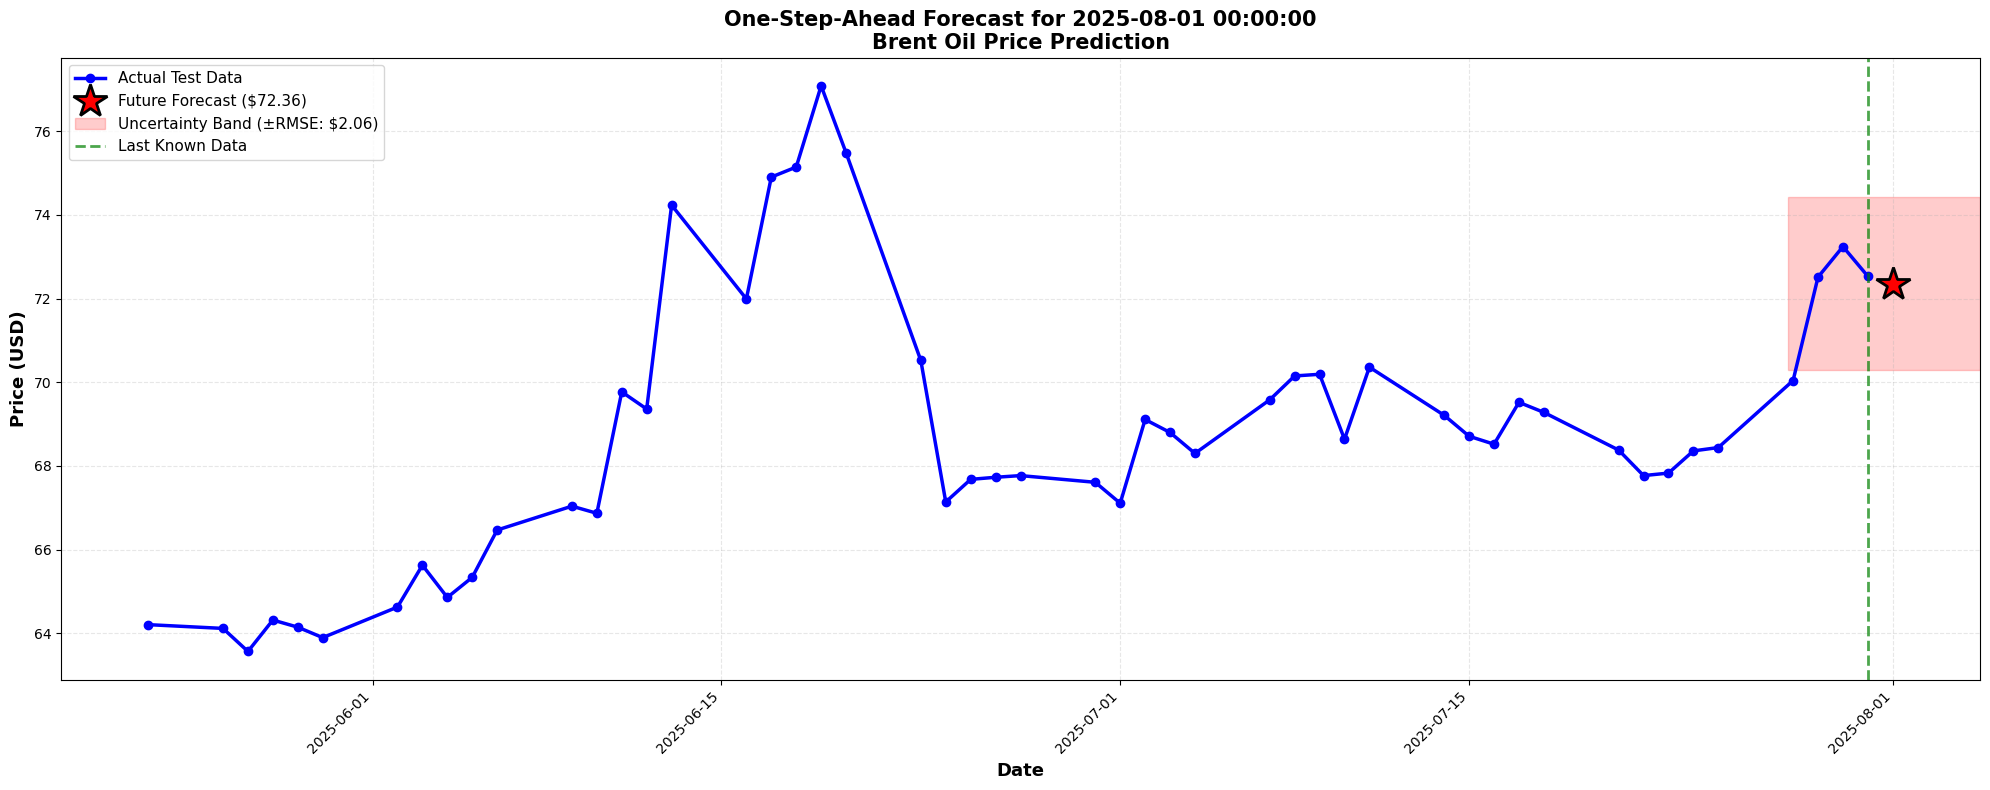

In [87]:
# ============================================================================
# STEP 11: ONE-STEP-AHEAD FUTURE FORECAST
# ============================================================================
print("\n" + "="*100)
print("📊 STEP 11: One-Step-Ahead Future Forecast (Beyond Test Data)")
print("="*100)
print("\n⚠️  IMPORTANT: We can only forecast ONE STEP into the future")
print("   because we need actual Y(t) to calculate diff(Y(t)) for subsequent predictions.")
print("-"*100)

# Get last test data information
last_test_price = df_test.iloc[-1]['Price']
last_test_state = df_test.iloc[-1]['Fuzzy_State']
second_last_test_price = df_test.iloc[-2]['Price']
last_test_date = df_test.iloc[-1]['Date']

# Calculate diff for adjustment
diff_last = last_test_price - second_last_test_price

print(f"\n📋 Last Known Information:")
print(f"  • Last Date               : {last_test_date}")
print(f"  • Last Price Y(t)         : ${last_test_price:.2f}")
print(f"  • Second Last Price Y(t-1): ${second_last_test_price:.2f}")
print(f"  • Last Fuzzy State        : A{last_test_state}")
print(f"  • diff(Y(t))              : ${diff_last:.2f}")

# Perform one-step-ahead forecast
print(f"\n🔮 Forecasting Next Step...")
print("-"*100)

# Initial forecast
future_initial_forecast = forecast_ftsmc_initial(last_test_state, last_test_price, 
                                                   transition_matrix, midpoints)

# Final forecast (adjusted)
future_final_forecast = future_initial_forecast + diff_last

# Next date (assuming daily data)
from datetime import timedelta
next_date = last_test_date + timedelta(days=1)

print(f"\n✅ Future Forecast Complete!")
print(f"\n{'='*100}")
print(f"🔮 FORECAST FOR {next_date}")
print(f"{'='*100}")

print(f"\n📊 Detailed Calculation:")
print(f"{'─'*100}")

print(f"\nStep 1: Current State Information")
print(f"  • Current Price Y(t)      : ${last_test_price:.2f}")
print(f"  • Current Fuzzy State     : A{last_test_state}")
print(f"  • Medoid of A{last_test_state}          : ${midpoints[last_test_state]:.2f}")

print(f"\nStep 2: Transition Probabilities from A{last_test_state}")
probs = transition_matrix[last_test_state]
for j in range(k_optimal):
    if probs[j] > 0:
        print(f"  • P(A{last_test_state} → A{j}) = {probs[j]:.4f}")

print(f"\nStep 3: Initial Forecast F(t+1)")
print(f"  • Formula: Weighted sum based on transition probabilities")
forecast_calculation = []
for j in range(k_optimal):
    if probs[j] > 0:
        if j == last_test_state:
            contrib = last_test_price * probs[j]
            forecast_calculation.append(f"${last_test_price:.2f} × {probs[j]:.4f}")
        else:
            contrib = midpoints[j] * probs[j]
            forecast_calculation.append(f"${midpoints[j]:.2f} × {probs[j]:.4f}")

print(f"  • F(t+1) = " + " + ".join(forecast_calculation))
print(f"  • F(t+1) = ${future_initial_forecast:.2f}")

print(f"\nStep 4: Adjustment with diff(Y(t))")
print(f"  • diff(Y(t)) = Y(t) - Y(t-1)")
print(f"  • diff(Y(t)) = ${last_test_price:.2f} - ${second_last_test_price:.2f}")
print(f"  • diff(Y(t)) = ${diff_last:.2f}")

print(f"\nStep 5: Final Forecast F^(t+1)")
print(f"  • F^(t+1) = F(t+1) + diff(Y(t))")
print(f"  • F^(t+1) = ${future_initial_forecast:.2f} + ${diff_last:.2f}")
print(f"  • F^(t+1) = ${future_final_forecast:.2f}")

print(f"\n{'='*100}")
print(f"📈 FINAL PREDICTION FOR {next_date}:")
print(f"{'='*100}")
print(f"\n  🔸 Initial Forecast F(t+1)  : ${future_initial_forecast:.2f}")
print(f"  🔸 Final Forecast F^(t+1)   : ${future_final_forecast:.2f}")
print(f"\n  ✅ RECOMMENDED FORECAST: ${future_final_forecast:.2f}")
print(f"{'='*100}")

# Create future forecast DataFrame
future_forecast_data = {
    'Date': [next_date],
    'Forecast_Type': ['One-Step-Ahead'],
    'Previous_Y(t)': [last_test_price],
    'Previous_State': [f'A{last_test_state}'],
    'diff(Y(t))': [diff_last],
    'Initial_Forecast_F(t+1)': [future_initial_forecast],
    'Final_Forecast_F^(t+1)': [future_final_forecast]
}

df_future_forecast = pd.DataFrame(future_forecast_data)

# Visualization of future forecast
print(f"\n📊 Visualizing Future Forecast...")

plt.figure(figsize=(20, 8))

# Plot last 50 test points + future forecast
n_display = min(50, len(df_test))
display_test = df_test.tail(n_display)

plt.plot(display_test['Date'], display_test['Price'], 
         'o-', label='Actual Test Data', color='blue', linewidth=2.5, markersize=6)

# Add future forecast point
plt.plot(next_date, future_final_forecast, 
         '*', label=f'Future Forecast (${future_final_forecast:.2f})', 
         color='red', markersize=25, markeredgecolor='black', markeredgewidth=2)

# Add forecast uncertainty band (optional - based on RMSE)
plt.axhspan(future_final_forecast - final_rmse_test, 
            future_final_forecast + final_rmse_test, 
            xmin=0.9, alpha=0.2, color='red', 
            label=f'Uncertainty Band (±RMSE: ${final_rmse_test:.2f})')

# Vertical line at last known data
plt.axvline(last_test_date, color='green', linestyle='--', linewidth=2, 
            alpha=0.7, label='Last Known Data')

plt.xlabel('Date', fontsize=13, fontweight='bold')
plt.ylabel('Price (USD)', fontsize=13, fontweight='bold')
plt.title(f'One-Step-Ahead Forecast for {next_date}\nBrent Oil Price Prediction', 
          fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [88]:
# ============================================================================
# STEP 12: SAVE ALL RESULTS
# ============================================================================
print("\n" + "="*100)
print("📊 STEP 12: Saving All Results")
print("="*100)

print("\n💾 Saving forecast results to files...")

# Save training forecast
df_forecast_train.to_csv('ftsmc_training_forecast.csv', index=False)
print("  ✓ Training forecast saved to 'ftsmc_training_forecast.csv'")

# Save testing forecast
df_forecast_test.to_csv('ftsmc_testing_forecast.csv', index=False)
print("  ✓ Testing forecast saved to 'ftsmc_testing_forecast.csv'")

# Save future forecast
df_future_forecast.to_csv('ftsmc_future_forecast.csv', index=False)
print("  ✓ Future forecast saved to 'ftsmc_future_forecast.csv'")

# Save transition matrix
transition_df.to_csv('ftsmc_transition_matrix.csv')
print("  ✓ Transition matrix saved to 'ftsmc_transition_matrix.csv'")

# Save fuzzy sets parameters
df_fuzzy_sets.to_csv('ftsmc_fuzzy_sets.csv', index=False)
print("  ✓ Fuzzy sets parameters saved to 'ftsmc_fuzzy_sets.csv'")

# Save FLRG
df_flrg.to_csv('ftsmc_flrg.csv', index=False)
print("  ✓ FLRG saved to 'ftsmc_flrg.csv'")

# Save accuracy comparison
accuracy_summary = {
    'Dataset': ['Training', 'Training', 'Testing', 'Testing'],
    'Forecast_Type': ['Initial F(t)', 'Final F^(t)', 'Initial F(t)', 'Final F^(t)'],
    'MAE': [initial_mae, final_mae, initial_mae_test, final_mae_test],
    'MSE': [initial_mse, final_mse, initial_mse_test, final_mse_test],
    'RMSE': [initial_rmse, final_rmse, initial_rmse_test, final_rmse_test],
    'MAPE': [initial_mape, final_mape, initial_mape_test, final_mape_test],
    'Accuracy_Level': [initial_accuracy_level, final_accuracy_level, 
                       initial_accuracy_level_test, final_accuracy_level_test]
}
df_accuracy_summary = pd.DataFrame(accuracy_summary)
df_accuracy_summary.to_csv('ftsmc_accuracy_summary.csv', index=False)
print("  ✓ Accuracy summary saved to 'ftsmc_accuracy_summary.csv'")

print("\n✅ All results saved successfully!")


📊 STEP 12: Saving All Results

💾 Saving forecast results to files...
  ✓ Training forecast saved to 'ftsmc_training_forecast.csv'
  ✓ Testing forecast saved to 'ftsmc_testing_forecast.csv'
  ✓ Future forecast saved to 'ftsmc_future_forecast.csv'
  ✓ Transition matrix saved to 'ftsmc_transition_matrix.csv'
  ✓ Fuzzy sets parameters saved to 'ftsmc_fuzzy_sets.csv'
  ✓ FLRG saved to 'ftsmc_flrg.csv'
  ✓ Accuracy summary saved to 'ftsmc_accuracy_summary.csv'

✅ All results saved successfully!


In [89]:
# ============================================================================
# STEP 13: FINAL SUMMARY REPORT
# ============================================================================
print("\n" + "="*100)
print("📊 FINAL SUMMARY REPORT: CLARA-FTSMC MODEL")
print("="*100)

print(f"\n🔧 MODEL CONFIGURATION:")
print(f"  • Clustering Method      : CLARA (Clustering Large Applications)")
print(f"  • Optimal Clusters (k)   : {k_optimal}")
print(f"  • Membership Function    : Trapezoid (Q1-Q3 based)")
print(f"  • Forecasting Method     : Fuzzy Time Series Markov Chain (FTSMC)")
print(f"  • Training Data Size     : {len(df_train)} observations")
print(f"  • Testing Data Size      : {len(df_test)} observations")
print(f"  • Total Data Points      : {len(df)} observations")

print(f"\n📅 DATA RANGE:")
print(f"  • Training Period : {df_train['Date'].min()} to {df_train['Date'].max()}")
print(f"  • Testing Period  : {df_test['Date'].min()} to {df_test['Date'].max()}")
print(f"  • Total Period    : {df['Date'].min()} to {df['Date'].max()}")

print(f"\n📊 FUZZY STATES SUMMARY:")
for i in range(k_optimal):
    params = df_fuzzy_sets.iloc[i]
    count_train = (df_train['Fuzzy_State'] == i).sum()
    count_test = (df_test['Fuzzy_State'] == i).sum()
    pct_train = (count_train / len(df_train)) * 100
    pct_test = (count_test / len(df_test)) * 100
    print(f"  • A{i} [${params['b']:.2f}, ${params['c']:.2f}]:")
    print(f"      Training: {count_train:4d} ({pct_train:5.2f}%) | Testing: {count_test:4d} ({pct_test:5.2f}%)")

print(f"\n📈 TRAINING PERFORMANCE:")
print(f"{'─'*100}")
print(f"  {'Metric':<20} {'Initial F(t)':<20} {'Final F^(t)':<20} {'Better':<15}")
print(f"{'─'*100}")
print(f"  {'MAE':<20} ${initial_mae:<19.4f} ${final_mae:<19.4f} {'Final' if final_mae < initial_mae else 'Initial':<15}")
print(f"  {'MSE':<20} ${initial_mse:<19.4f} ${final_mse:<19.4f} {'Final' if final_mse < initial_mse else 'Initial':<15}")
print(f"  {'RMSE':<20} ${initial_rmse:<19.4f} ${final_rmse:<19.4f} {'Final' if final_rmse < initial_rmse else 'Initial':<15}")
print(f"  {'MAPE (%)':<20} {initial_mape:<20.4f} {final_mape:<20.4f} {'Final' if final_mape < initial_mape else 'Initial':<15}")
print(f"  {'Accuracy Level':<20} {initial_accuracy_level:<20} {final_accuracy_level:<20}")
print(f"{'─'*100}")

print(f"\n📈 TESTING PERFORMANCE:")
print(f"{'─'*100}")
print(f"  {'Metric':<20} {'Initial F(t)':<20} {'Final F^(t)':<20} {'Better':<15}")
print(f"{'─'*100}")
print(f"  {'MAE':<20} ${initial_mae_test:<19.4f} ${final_mae_test:<19.4f} {'Final' if final_mae_test < initial_mae_test else 'Initial':<15}")
print(f"  {'MSE':<20} ${initial_mse_test:<19.4f} ${final_mse_test:<19.4f} {'Final' if final_mse_test < initial_mse_test else 'Initial':<15}")
print(f"  {'RMSE':<20} ${initial_rmse_test:<19.4f} ${final_rmse_test:<19.4f} {'Final' if final_rmse_test < initial_rmse_test else 'Initial':<15}")
print(f"  {'MAPE (%)':<20} {initial_mape_test:<20.4f} {final_mape_test:<20.4f} {'Final' if final_mape_test < initial_mape_test else 'Initial':<15}")
print(f"  {'Accuracy Level':<20} {initial_accuracy_level_test:<20} {final_accuracy_level_test:<20}")
print(f"{'─'*100}")

print(f"\n🎯 TRANSITION MATRIX STATISTICS:")
non_zero_transitions = (transition_matrix > 0).sum()
total_possible = k_optimal * k_optimal
print(f"  • Total Possible Transitions : {total_possible}")
print(f"  • Observed Transitions       : {non_zero_transitions}")
print(f"  • Transition Coverage        : {(non_zero_transitions/total_possible)*100:.2f}%")

print(f"\n🔮 FUTURE FORECAST:")
print(f"  • Forecast Date              : {next_date}")
print(f"  • Initial Forecast F(t+1)    : ${future_initial_forecast:.2f}")
print(f"  • Final Forecast F^(t+1)     : ${future_final_forecast:.2f}")
print(f"  • Uncertainty (±RMSE)        : ${final_rmse_test:.2f}")
print(f"  • Forecast Range             : ${future_final_forecast - final_rmse_test:.2f} - ${future_final_forecast + final_rmse_test:.2f}")

print(f"\n💡 KEY FINDINGS:")
if final_mae < initial_mae and final_mae_test < initial_mae_test:
    print(f"  ✅ The adjustment with diff(Y(t)) IMPROVES accuracy in BOTH training and testing")
    print(f"     - Training improvement: {((initial_mae - final_mae) / initial_mae * 100):.2f}%")
    print(f"     - Testing improvement: {((initial_mae_test - final_mae_test) / initial_mae_test * 100):.2f}%")
elif final_mae < initial_mae:
    print(f"  ⚠️  The adjustment improves TRAINING but not TESTING")
    print(f"     - May indicate overfitting to training data")
elif final_mae_test < initial_mae_test:
    print(f"  ⚠️  The adjustment improves TESTING but not TRAINING")
    print(f"     - The model generalizes well despite training performance")
else:
    print(f"  ⚠️  The adjustment DECREASES accuracy in both datasets")
    print(f"     - Consider using Initial Forecast without adjustment")

print(f"\n📊 RECOMMENDATION:")
if final_mae_test < initial_mae_test:
    print(f"  ✅ USE FINAL FORECAST F^(t) for predictions")
    print(f"     - Better testing performance: MAE = ${final_mae_test:.2f}")
else:
    print(f"  ✅ USE INITIAL FORECAST F(t) for predictions")
    print(f"     - Better testing performance: MAE = ${initial_mae_test:.2f}")

print("\n" + "="*100)
print("✅ CLARA-FTSMC MODEL BUILDING AND FORECASTING COMPLETE!")
print("="*100)

print(f"\n📁 Generated Files:")
print(f"  1. ftsmc_training_forecast.csv     - Training predictions with details")
print(f"  2. ftsmc_testing_forecast.csv      - Testing predictions with details")
print(f"  3. ftsmc_future_forecast.csv       - One-step-ahead future prediction")
print(f"  4. ftsmc_transition_matrix.csv     - Markov transition probability matrix")
print(f"  5. ftsmc_fuzzy_sets.csv            - Fuzzy sets parameters")
print(f"  6. ftsmc_flrg.csv                  - Fuzzy logical relationship groups")
print(f"  7. ftsmc_accuracy_summary.csv      - Complete accuracy comparison")

print("\n" + "="*100)
print("🎉 Thank you for using CLARA-FTSMC Model!")
print("="*100)


📊 FINAL SUMMARY REPORT: CLARA-FTSMC MODEL

🔧 MODEL CONFIGURATION:
  • Clustering Method      : CLARA (Clustering Large Applications)
  • Optimal Clusters (k)   : 4
  • Membership Function    : Trapezoid (Q1-Q3 based)
  • Forecasting Method     : Fuzzy Time Series Markov Chain (FTSMC)
  • Training Data Size     : 1032 observations
  • Testing Data Size      : 259 observations
  • Total Data Points      : 1291 observations

📅 DATA RANGE:
  • Training Period : 2020-08-03 00:00:00 to 2024-07-30 00:00:00
  • Testing Period  : 2024-07-31 00:00:00 to 2025-07-31 00:00:00
  • Total Period    : 2020-08-03 00:00:00 to 2025-07-31 00:00:00

📊 FUZZY STATES SUMMARY:
  • A0 [$42.45, $51.09]:
      Training:  137 (13.28%) | Testing:    3 ( 1.16%)
  • A1 [$69.57, $77.37]:
      Training:  335 (32.46%) | Testing:  246 (94.98%)
  • A2 [$83.02, $89.24]:
      Training:  423 (40.99%) | Testing:   10 ( 3.86%)
  • A3 [$100.99, $113.45]:
      Training:  137 (13.28%) | Testing:    0 ( 0.00%)

📈 TRAINING PERFO


📊 Creating final summary visualization...
  ✓ Summary dashboard saved to 'ftsmc_summary_dashboard.png'


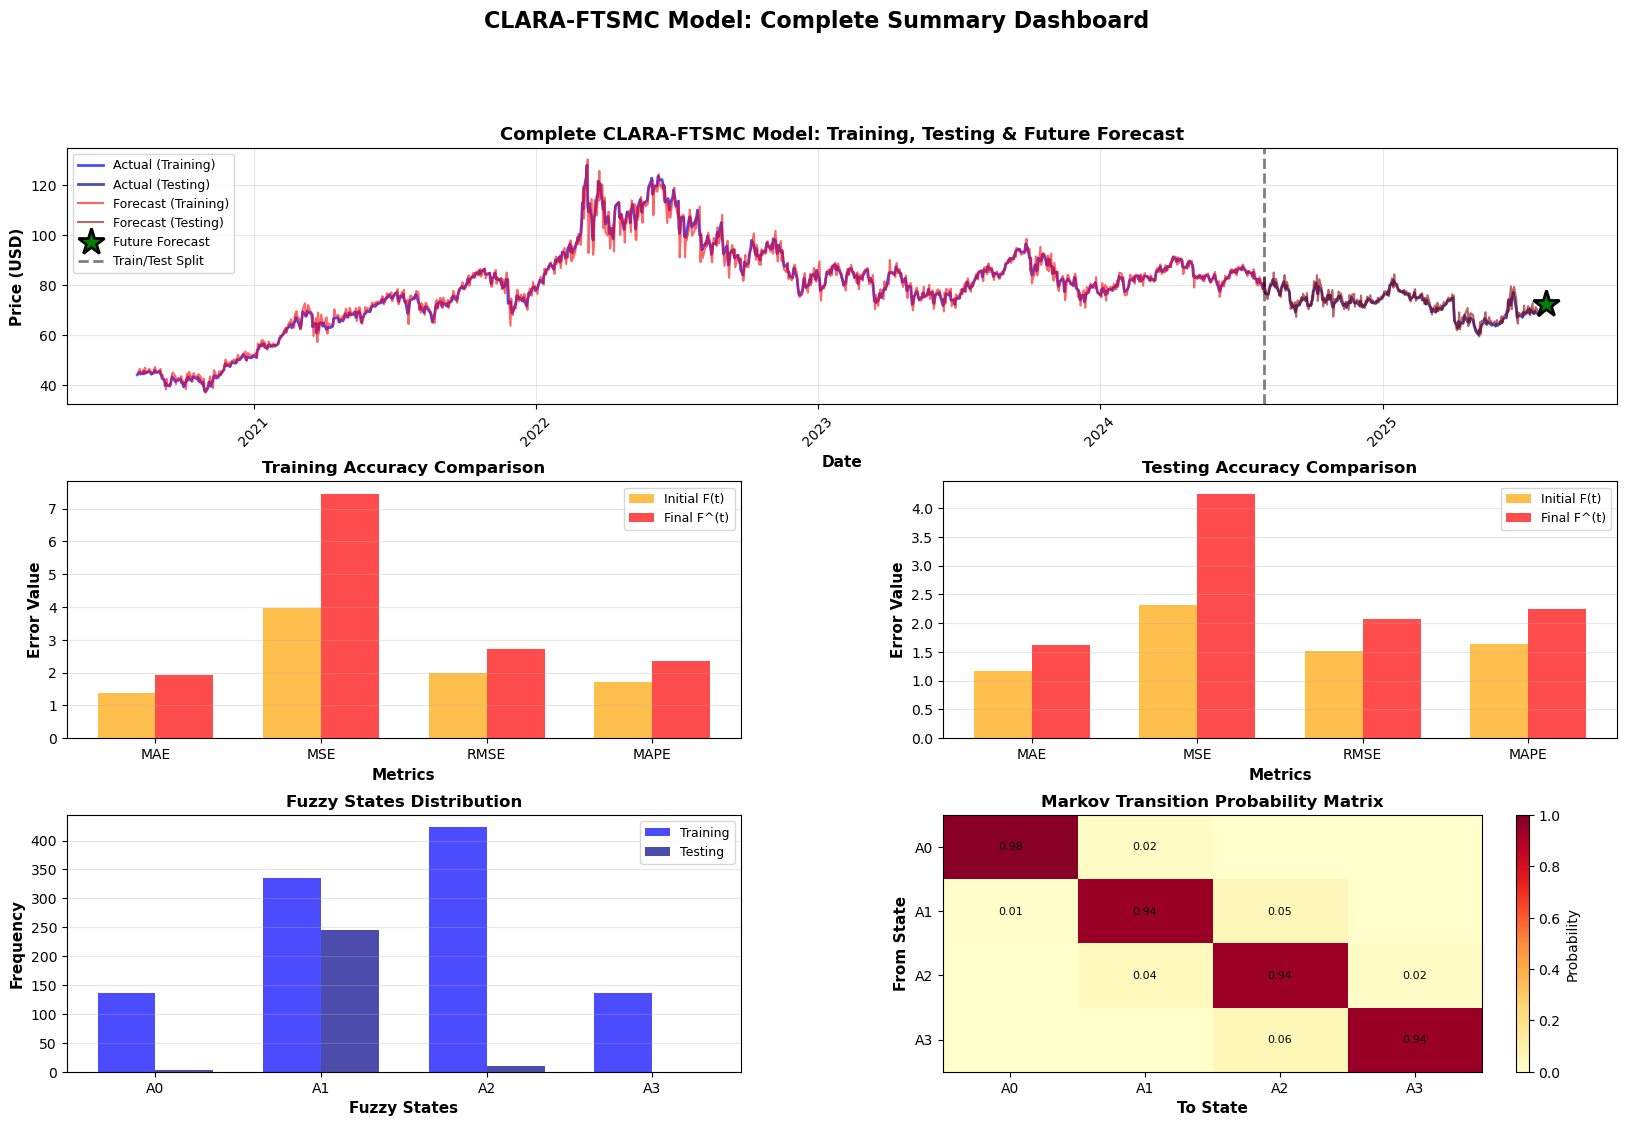


✅ All visualizations and reports completed!

🎊 CLARA-FTSMC MODEL SUCCESSFULLY COMPLETED! 🎊


In [90]:
# ============================================================================
# BONUS: Create Summary Visualization
# ============================================================================
print("\n📊 Creating final summary visualization...")

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Plot 1: Complete Time Series with Forecasts
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(df_train['Date'], df_train['Price'], 
         label='Actual (Training)', color='blue', linewidth=2, alpha=0.7)
ax1.plot(df_test['Date'], df_test['Price'], 
         label='Actual (Testing)', color='darkblue', linewidth=2, alpha=0.7)
ax1.plot(df_forecast_train['Date'], df_forecast_train['Final_Forecast_F^(t)'], 
         label='Forecast (Training)', color='red', linewidth=1.5, alpha=0.6)
ax1.plot(df_forecast_test['Date'], df_forecast_test['Final_Forecast_F^(t)'], 
         label='Forecast (Testing)', color='darkred', linewidth=1.5, alpha=0.6)
ax1.plot(next_date, future_final_forecast, '*', 
         label=f'Future Forecast', color='green', markersize=20, 
         markeredgecolor='black', markeredgewidth=2)
ax1.axvline(df_test['Date'].iloc[0], color='black', linestyle='--', 
            linewidth=2, alpha=0.5, label='Train/Test Split')
ax1.set_xlabel('Date', fontsize=11, fontweight='bold')
ax1.set_ylabel('Price (USD)', fontsize=11, fontweight='bold')
ax1.set_title('Complete CLARA-FTSMC Model: Training, Testing & Future Forecast', 
              fontsize=13, fontweight='bold')
ax1.legend(fontsize=9, loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Training Accuracy Comparison
ax2 = fig.add_subplot(gs[1, 0])
metrics = ['MAE', 'MSE', 'RMSE', 'MAPE']
initial_vals = [initial_mae, initial_mse, initial_rmse, initial_mape]
final_vals = [final_mae, final_mse, final_rmse, final_mape]
x = np.arange(len(metrics))
width = 0.35
ax2.bar(x - width/2, initial_vals, width, label='Initial F(t)', color='orange', alpha=0.7)
ax2.bar(x + width/2, final_vals, width, label='Final F^(t)', color='red', alpha=0.7)
ax2.set_xlabel('Metrics', fontsize=11, fontweight='bold')
ax2.set_ylabel('Error Value', fontsize=11, fontweight='bold')
ax2.set_title('Training Accuracy Comparison', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Testing Accuracy Comparison
ax3 = fig.add_subplot(gs[1, 1])
initial_vals_test = [initial_mae_test, initial_mse_test, initial_rmse_test, initial_mape_test]
final_vals_test = [final_mae_test, final_mse_test, final_rmse_test, final_mape_test]
ax3.bar(x - width/2, initial_vals_test, width, label='Initial F(t)', color='orange', alpha=0.7)
ax3.bar(x + width/2, final_vals_test, width, label='Final F^(t)', color='red', alpha=0.7)
ax3.set_xlabel('Metrics', fontsize=11, fontweight='bold')
ax3.set_ylabel('Error Value', fontsize=11, fontweight='bold')
ax3.set_title('Testing Accuracy Comparison', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(metrics)
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Fuzzy States Distribution
ax4 = fig.add_subplot(gs[2, 0])
states = [f'A{i}' for i in range(k_optimal)]
train_counts = [((df_train['Fuzzy_State'] == i).sum()) for i in range(k_optimal)]
test_counts = [((df_test['Fuzzy_State'] == i).sum()) for i in range(k_optimal)]
x_states = np.arange(len(states))
ax4.bar(x_states - width/2, train_counts, width, label='Training', color='blue', alpha=0.7)
ax4.bar(x_states + width/2, test_counts, width, label='Testing', color='darkblue', alpha=0.7)
ax4.set_xlabel('Fuzzy States', fontsize=11, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax4.set_title('Fuzzy States Distribution', fontsize=12, fontweight='bold')
ax4.set_xticks(x_states)
ax4.set_xticklabels(states)
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: Transition Matrix Heatmap
ax5 = fig.add_subplot(gs[2, 1])
im = ax5.imshow(transition_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
ax5.set_xticks(np.arange(k_optimal))
ax5.set_yticks(np.arange(k_optimal))
ax5.set_xticklabels([f'A{i}' for i in range(k_optimal)])
ax5.set_yticklabels([f'A{i}' for i in range(k_optimal)])
ax5.set_xlabel('To State', fontsize=11, fontweight='bold')
ax5.set_ylabel('From State', fontsize=11, fontweight='bold')
ax5.set_title('Markov Transition Probability Matrix', fontsize=12, fontweight='bold')

# Add text annotations
for i in range(k_optimal):
    for j in range(k_optimal):
        if transition_matrix[i, j] > 0:
            text = ax5.text(j, i, f'{transition_matrix[i, j]:.2f}',
                           ha="center", va="center", color="black", fontsize=8)

plt.colorbar(im, ax=ax5, label='Probability')

plt.suptitle('CLARA-FTSMC Model: Complete Summary Dashboard', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('ftsmc_summary_dashboard.png', dpi=300, bbox_inches='tight')
print("  ✓ Summary dashboard saved to 'ftsmc_summary_dashboard.png'")
plt.show()

print("\n✅ All visualizations and reports completed!")
print("\n" + "="*100)
print("🎊 CLARA-FTSMC MODEL SUCCESSFULLY COMPLETED! 🎊")
print("="*100)

In [91]:
# ============================================================================
# STEP 14: MULTI-STEP-AHEAD FORECAST (5 STEPS)
# ============================================================================
print("\n" + "="*100)
print("📊 STEP 14: Multi-Step-Ahead Forecast (5 Steps into the Future)")
print("="*100)
print("\n⚠️  IMPORTANT: Multi-step forecast uses PREDICTED values as 'actual' for next step")
print("   This introduces cumulative uncertainty - accuracy decreases with each step.")
print("-"*100)

# Function to assign fuzzy state to a single price value
def get_fuzzy_state_from_price(price, df_fuzzy_sets, k_optimal):
    """
    Determine fuzzy state for a given price based on membership functions
    """
    memberships = []
    for i in range(k_optimal):
        params = df_fuzzy_sets.iloc[i]
        mu = trapezoid_membership(price, params['a'], params['b'], params['c'], params['d'])
        memberships.append(mu)
    
    # Return state with maximum membership
    max_membership = max(memberships)
    fuzzy_state = memberships.index(max_membership)
    
    return fuzzy_state, max_membership, memberships

# Initialize for multi-step forecast
n_future_steps = 5
multi_step_forecasts = []

# Get initial information from last test data
current_price = df_test.iloc[-1]['Price']
previous_price = df_test.iloc[-2]['Price']
current_date = df_test.iloc[-1]['Date']

print(f"\n📋 Starting Information:")
print(f"  • Last Known Date    : {current_date}")
print(f"  • Last Known Price   : ${current_price:.2f}")
print(f"  • Previous Price     : ${previous_price:.2f}")
print(f"  • Initial diff(Y(t)) : ${current_price - previous_price:.2f}")

print("\n" + "="*100)
print("🔮 PERFORMING 5-STEP-AHEAD FORECASTING")
print("="*100)

# Perform multi-step forecasting
for step in range(1, n_future_steps + 1):
    print(f"\n{'─'*100}")
    print(f"FORECAST STEP {step}")
    print(f"{'─'*100}")
    
    # Calculate next date
    from datetime import timedelta
    next_date = current_date + timedelta(days=1)
    
    # Get fuzzy state for current price
    current_state, current_membership, all_memberships = get_fuzzy_state_from_price(
        current_price, df_fuzzy_sets, k_optimal
    )
    
    print(f"\n📅 Target Date: {next_date}")
    print(f"\n  Step 1: Current State Information")
    print(f"    • Current Price Y(t)         : ${current_price:.2f}")
    print(f"    • Previous Price Y(t-1)      : ${previous_price:.2f}")
    print(f"    • Current Fuzzy State        : A{current_state}")
    print(f"    • Membership Degree          : {current_membership:.4f}")
    
    # Show all memberships
    print(f"\n    • Membership degrees for current price:")
    for i in range(k_optimal):
        if all_memberships[i] > 0:
            print(f"      - μ_A{i}(${current_price:.2f}) = {all_memberships[i]:.4f}")
    
    # Calculate diff
    diff_current = current_price - previous_price
    
    print(f"\n  Step 2: Calculate diff(Y(t))")
    print(f"    • diff(Y(t)) = Y(t) - Y(t-1)")
    print(f"    • diff(Y(t)) = ${current_price:.2f} - ${previous_price:.2f}")
    print(f"    • diff(Y(t)) = ${diff_current:.2f}")
    
    # Initial forecast
    print(f"\n  Step 3: Initial Forecast F(t+1)")
    print(f"    • Transition probabilities from A{current_state}:")
    
    probs = transition_matrix[current_state]
    forecast_components = []
    for j in range(k_optimal):
        if probs[j] > 0:
            if j == current_state:
                component = current_price * probs[j]
                print(f"      - P(A{current_state} → A{j}) = {probs[j]:.4f} × ${current_price:.2f} (current price) = ${component:.2f}")
                forecast_components.append(component)
            else:
                component = midpoints[j] * probs[j]
                print(f"      - P(A{current_state} → A{j}) = {probs[j]:.4f} × ${midpoints[j]:.2f} (midpoint) = ${component:.2f}")
                forecast_components.append(component)
    
    initial_forecast = forecast_ftsmc_initial(current_state, current_price, 
                                                transition_matrix, midpoints)
    
    print(f"\n    • F(t+1) = {' + '.join([f'${comp:.2f}' for comp in forecast_components])}")
    print(f"    • F(t+1) = ${initial_forecast:.2f}")
    
    # Final forecast (adjusted)
    print(f"\n  Step 4: Final Forecast F^(t+1) with Adjustment")
    print(f"    • F^(t+1) = F(t+1) + diff(Y(t))")
    print(f"    • F^(t+1) = ${initial_forecast:.2f} + ${diff_current:.2f}")
    
    final_forecast = initial_forecast + diff_current
    
    print(f"    • F^(t+1) = ${final_forecast:.2f}")
    
    # Store results
    multi_step_forecasts.append({
        'Step': step,
        'Date': next_date,
        'Y(t)_Used': current_price,
        'Y(t-1)_Used': previous_price,
        'Fuzzy_State': f'A{current_state}',
        'Membership': current_membership,
        'diff(Y(t))': diff_current,
        'Initial_Forecast_F(t+1)': initial_forecast,
        'Final_Forecast_F^(t+1)': final_forecast,
        'Source': 'Actual' if step == 1 else 'Predicted'
    })
    
    print(f"\n  ✅ Forecast Complete for {next_date}:")
    print(f"    • Initial Forecast  : ${initial_forecast:.2f}")
    print(f"    • Final Forecast    : ${final_forecast:.2f}")
    
    if step < n_future_steps:
        print(f"\n  🔄 Moving to next step...")
        print(f"    • Using F^(t+1) = ${final_forecast:.2f} as 'actual' for next prediction")
    
    # Update for next iteration
    previous_price = current_price
    current_price = final_forecast  # Use forecast as "actual" for next step
    current_date = next_date

# Create DataFrame for multi-step forecasts
df_multi_step = pd.DataFrame(multi_step_forecasts)

print("\n" + "="*100)
print("✅ 5-STEP-AHEAD FORECASTING COMPLETE!")
print("="*100)

# Display results
print("\n📊 MULTI-STEP FORECAST RESULTS:")
print("-"*100)
print(df_multi_step.to_string(index=False, float_format=lambda x: f'{x:.2f}' if isinstance(x, float) else x))


📊 STEP 14: Multi-Step-Ahead Forecast (5 Steps into the Future)

⚠️  IMPORTANT: Multi-step forecast uses PREDICTED values as 'actual' for next step
   This introduces cumulative uncertainty - accuracy decreases with each step.
----------------------------------------------------------------------------------------------------

📋 Starting Information:
  • Last Known Date    : 2025-07-31 00:00:00
  • Last Known Price   : $72.53
  • Previous Price     : $73.24
  • Initial diff(Y(t)) : $-0.71

🔮 PERFORMING 5-STEP-AHEAD FORECASTING

────────────────────────────────────────────────────────────────────────────────────────────────────
FORECAST STEP 1
────────────────────────────────────────────────────────────────────────────────────────────────────

📅 Target Date: 2025-08-01 00:00:00

  Step 1: Current State Information
    • Current Price Y(t)         : $72.53
    • Previous Price Y(t-1)      : $73.24
    • Current Fuzzy State        : A1
    • Membership Degree          : 1.0000

    • Memb


📊 STEP 15: Visualizing Multi-Step Forecast
  ✓ Multi-step forecast plot saved to 'ftsmc_multi_step_forecast.png'


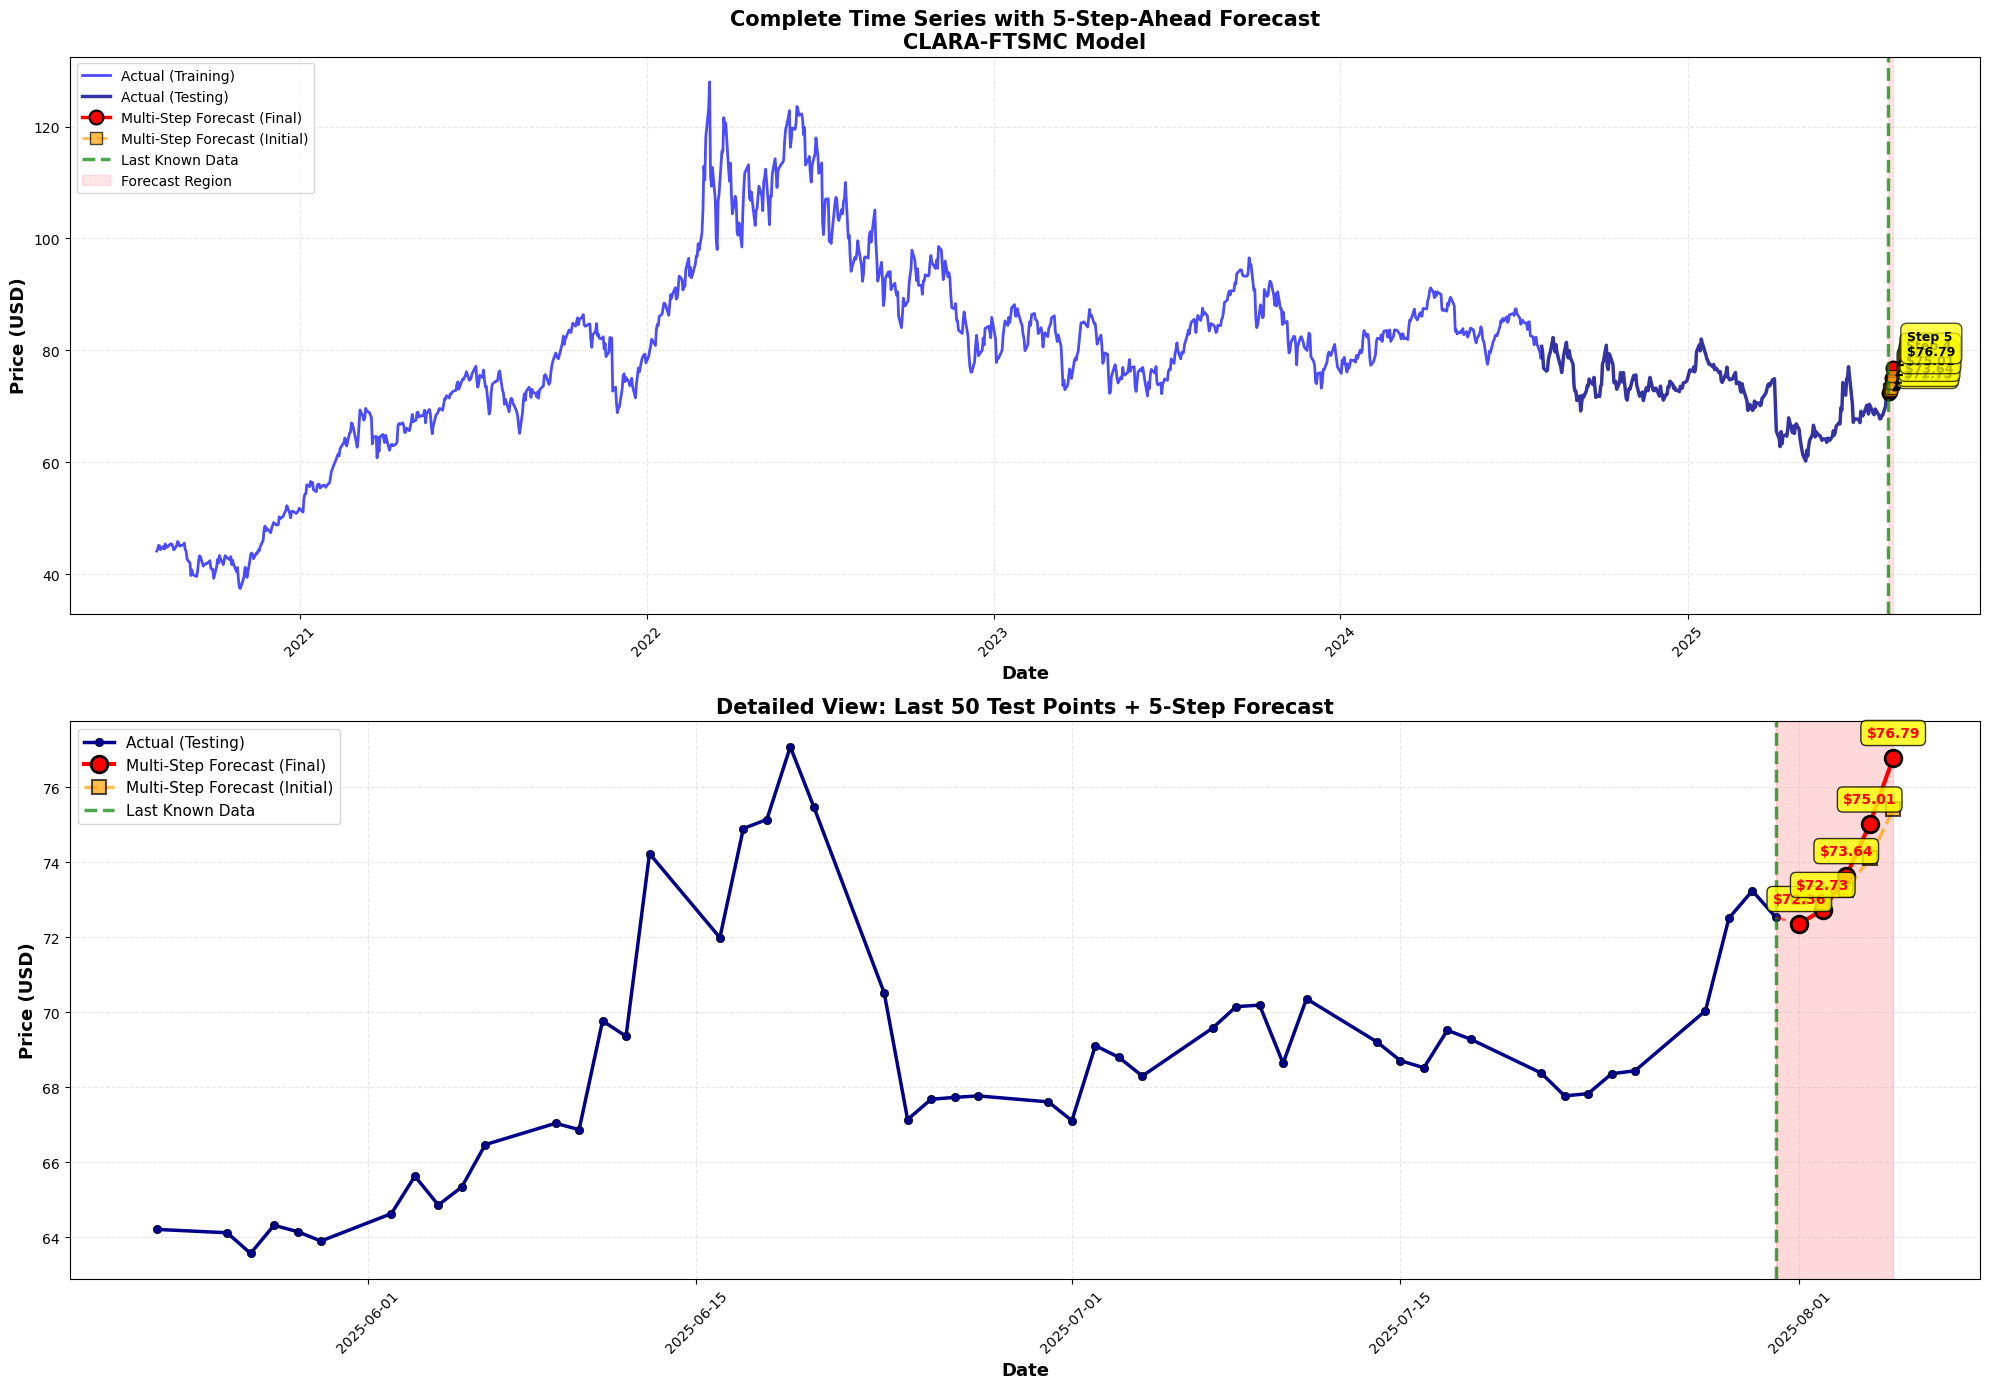

In [92]:
# ============================================================================
# STEP 15: VISUALIZE MULTI-STEP FORECAST
# ============================================================================
print("\n" + "="*100)
print("📊 STEP 15: Visualizing Multi-Step Forecast")
print("="*100)

# Prepare data for visualization
last_actual_date = df_test.iloc[-1]['Date']
last_actual_price = df_test.iloc[-1]['Price']

# Plot 1: Multi-Step Forecast with Actual Data
fig, axes = plt.subplots(2, 1, figsize=(20, 14))

# Subplot 1: Full view with training and testing
ax1 = axes[0]
ax1.plot(df_train['Date'], df_train['Price'], 
         label='Actual (Training)', color='blue', linewidth=2, alpha=0.7)
ax1.plot(df_test['Date'], df_test['Price'], 
         label='Actual (Testing)', color='darkblue', linewidth=2.5, alpha=0.8)

# Add multi-step forecasts
forecast_dates = df_multi_step['Date'].tolist()
initial_forecasts = df_multi_step['Initial_Forecast_F(t+1)'].tolist()
final_forecasts = df_multi_step['Final_Forecast_F^(t+1)'].tolist()

# Connect last actual to first forecast
ax1.plot([last_actual_date, forecast_dates[0]], 
         [last_actual_price, final_forecasts[0]], 
         'r--', linewidth=2, alpha=0.5)

ax1.plot(forecast_dates, final_forecasts, 
         'o-', label='Multi-Step Forecast (Final)', color='red', 
         linewidth=2.5, markersize=10, markeredgecolor='black', markeredgewidth=1.5)

ax1.plot(forecast_dates, initial_forecasts, 
         's--', label='Multi-Step Forecast (Initial)', color='orange', 
         linewidth=2, markersize=8, markeredgecolor='black', markeredgewidth=1, alpha=0.7)

# Mark each forecast step
for i, row in df_multi_step.iterrows():
    ax1.annotate(f"Step {row['Step']}\n${row['Final_Forecast_F^(t+1)']:.2f}", 
                 xy=(row['Date'], row['Final_Forecast_F^(t+1)']),
                 xytext=(10, 10), textcoords='offset points',
                 fontsize=9, fontweight='bold',
                 bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=1.5))

# Vertical line at last actual data
ax1.axvline(last_actual_date, color='green', linestyle='--', linewidth=2.5, 
            alpha=0.7, label='Last Known Data')

# Shade forecast region
ax1.axvspan(last_actual_date, forecast_dates[-1], alpha=0.1, color='red', 
            label='Forecast Region')

ax1.set_xlabel('Date', fontsize=13, fontweight='bold')
ax1.set_ylabel('Price (USD)', fontsize=13, fontweight='bold')
ax1.set_title('Complete Time Series with 5-Step-Ahead Forecast\nCLARA-FTSMC Model', 
              fontsize=15, fontweight='bold')
ax1.legend(fontsize=10, loc='upper left')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.tick_params(axis='x', rotation=45)

# Subplot 2: Zoomed view (last 50 test points + forecast)
ax2 = axes[1]
n_display = min(50, len(df_test))
display_test = df_test.tail(n_display)

ax2.plot(display_test['Date'], display_test['Price'], 
         'o-', label='Actual (Testing)', color='darkblue', 
         linewidth=2.5, markersize=6, markeredgecolor='black', markeredgewidth=0.5)

# Connect last actual to first forecast
ax2.plot([last_actual_date, forecast_dates[0]], 
         [last_actual_price, final_forecasts[0]], 
         'r--', linewidth=2, alpha=0.5)

ax2.plot(forecast_dates, final_forecasts, 
         'o-', label='Multi-Step Forecast (Final)', color='red', 
         linewidth=3, markersize=12, markeredgecolor='black', markeredgewidth=2)

ax2.plot(forecast_dates, initial_forecasts, 
         's--', label='Multi-Step Forecast (Initial)', color='orange', 
         linewidth=2.5, markersize=10, markeredgecolor='black', markeredgewidth=1.5, alpha=0.7)

# Mark each forecast step with values
for i, row in df_multi_step.iterrows():
    # Final forecast annotation
    ax2.annotate(f"${row['Final_Forecast_F^(t+1)']:.2f}", 
                 xy=(row['Date'], row['Final_Forecast_F^(t+1)']),
                 xytext=(0, 15), textcoords='offset points',
                 fontsize=10, fontweight='bold', color='red',
                 ha='center',
                 bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.8))

# Vertical line at last actual data
ax2.axvline(last_actual_date, color='green', linestyle='--', linewidth=2.5, 
            alpha=0.7, label='Last Known Data')

# Shade forecast region
ax2.axvspan(last_actual_date, forecast_dates[-1], alpha=0.15, color='red')

ax2.set_xlabel('Date', fontsize=13, fontweight='bold')
ax2.set_ylabel('Price (USD)', fontsize=13, fontweight='bold')
ax2.set_title(f'Detailed View: Last {n_display} Test Points + 5-Step Forecast', 
              fontsize=15, fontweight='bold')
ax2.legend(fontsize=11, loc='upper left')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('ftsmc_multi_step_forecast.png', dpi=300, bbox_inches='tight')
print("  ✓ Multi-step forecast plot saved to 'ftsmc_multi_step_forecast.png'")
plt.show()

  ✓ Multi-step analysis plot saved to 'ftsmc_multi_step_analysis.png'


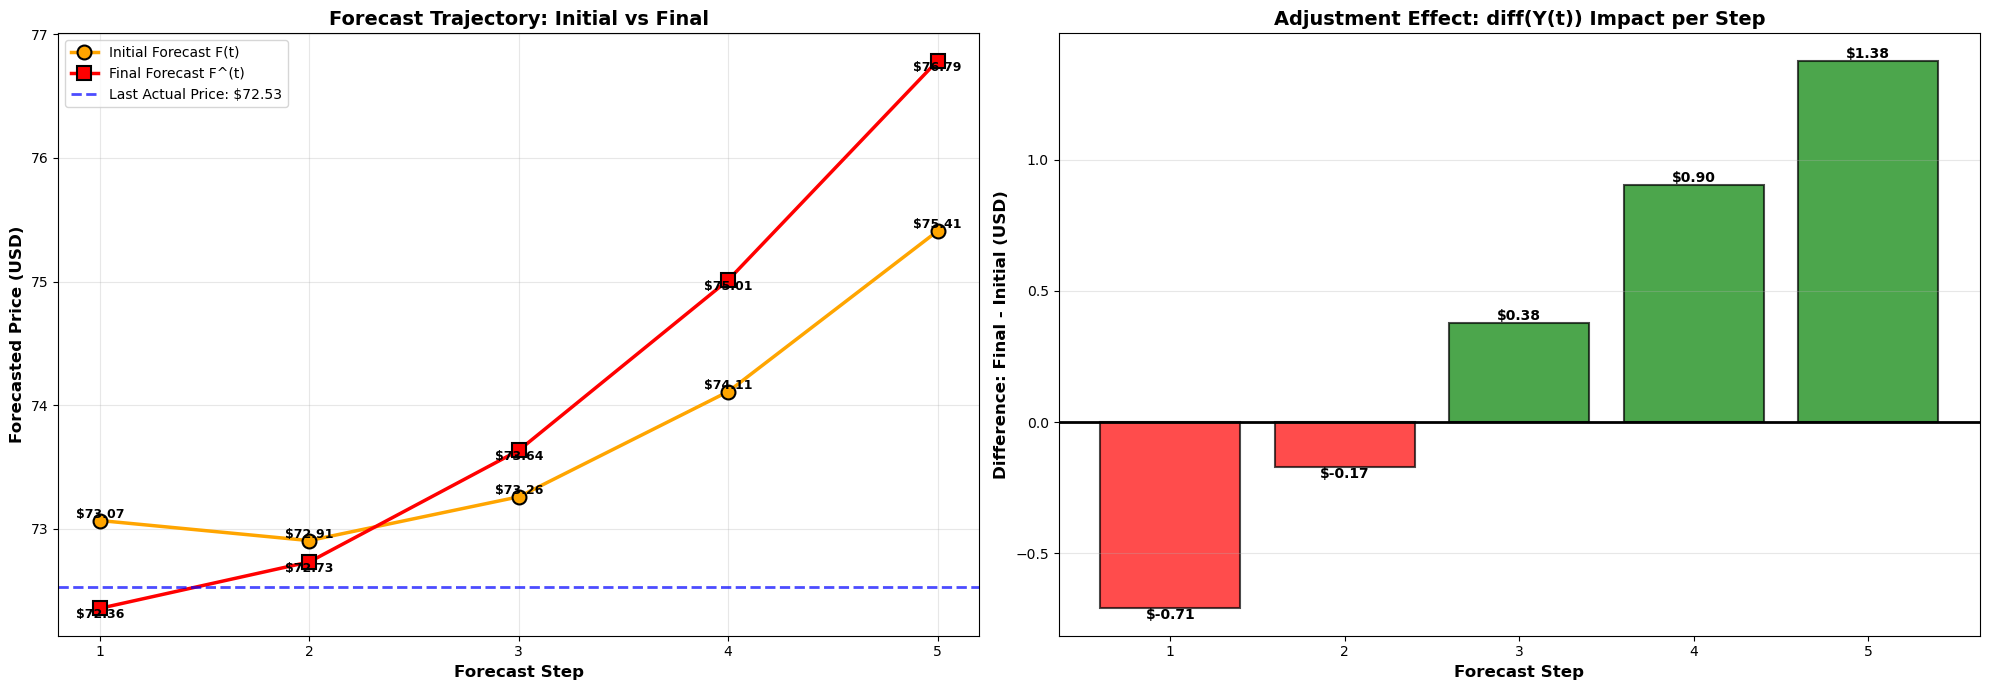

  ✓ State transitions plot saved to 'ftsmc_state_transitions.png'


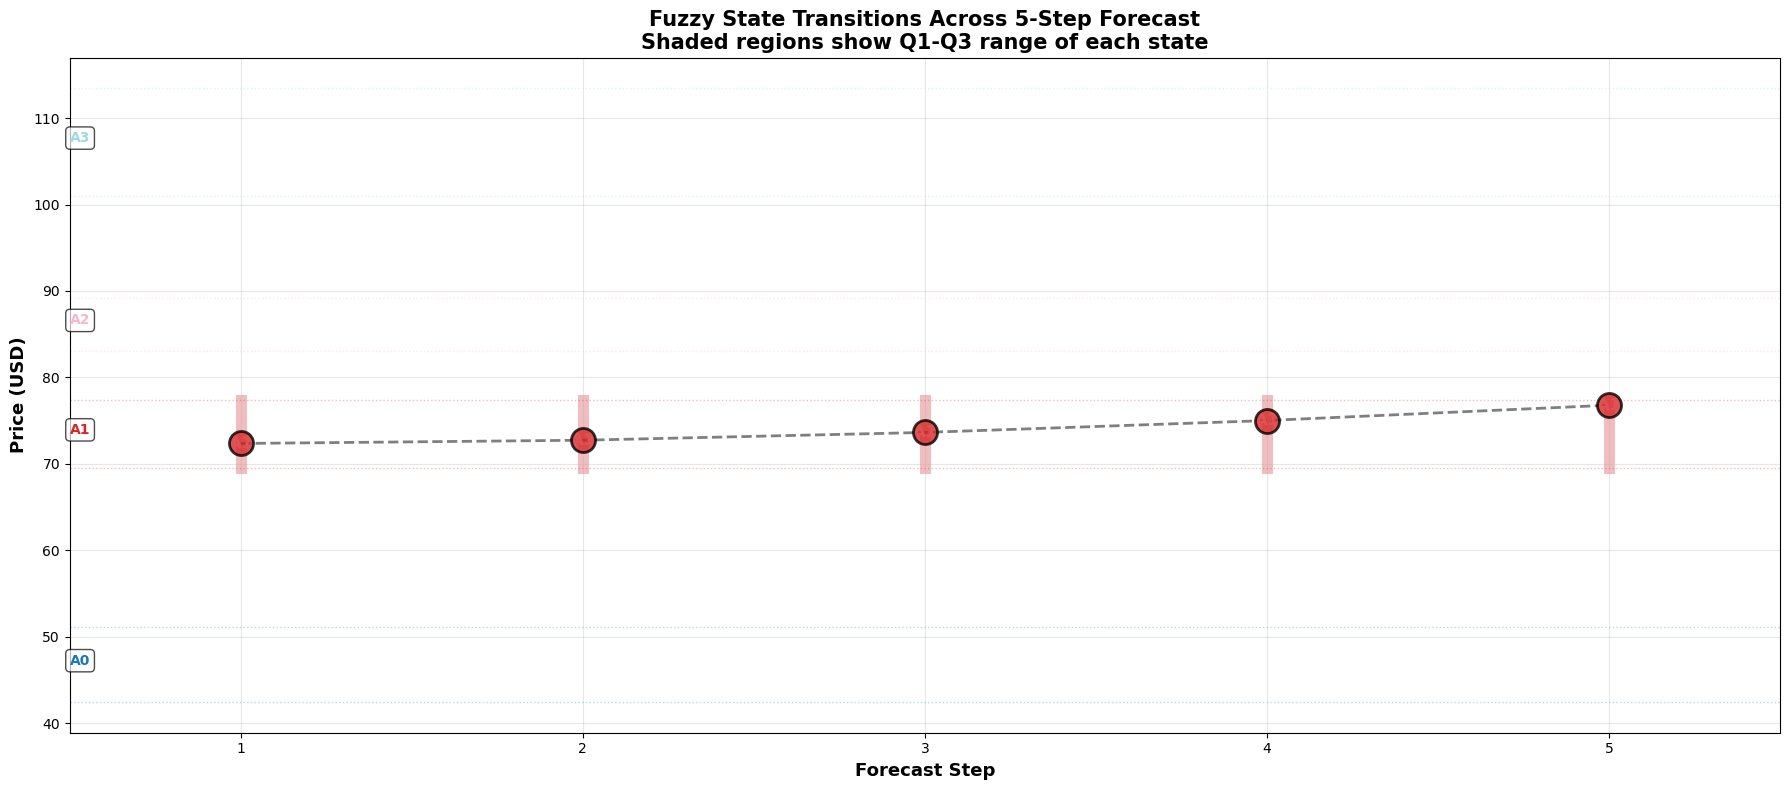

In [93]:
# Plot 2: Forecast Trajectory Analysis
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# Subplot 1: Initial vs Final Forecast Comparison
ax1 = axes[0]
steps = df_multi_step['Step'].tolist()
ax1.plot(steps, initial_forecasts, 'o-', label='Initial Forecast F(t)', 
         color='orange', linewidth=2.5, markersize=10, markeredgecolor='black', markeredgewidth=1.5)
ax1.plot(steps, final_forecasts, 's-', label='Final Forecast F^(t)', 
         color='red', linewidth=2.5, markersize=10, markeredgecolor='black', markeredgewidth=1.5)

# Add value labels
for i in range(len(steps)):
    ax1.text(steps[i], initial_forecasts[i], f'${initial_forecasts[i]:.2f}', 
             fontsize=9, ha='center', va='bottom', fontweight='bold')
    ax1.text(steps[i], final_forecasts[i], f'${final_forecasts[i]:.2f}', 
             fontsize=9, ha='center', va='top', fontweight='bold')

ax1.axhline(last_actual_price, color='blue', linestyle='--', linewidth=2, 
            alpha=0.7, label=f'Last Actual Price: ${last_actual_price:.2f}')
ax1.set_xlabel('Forecast Step', fontsize=12, fontweight='bold')
ax1.set_ylabel('Forecasted Price (USD)', fontsize=12, fontweight='bold')
ax1.set_title('Forecast Trajectory: Initial vs Final', fontsize=14, fontweight='bold')
ax1.set_xticks(steps)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Subplot 2: Forecast Differences
ax2 = axes[1]
differences = [final_forecasts[i] - initial_forecasts[i] for i in range(len(steps))]
colors_bar = ['green' if d > 0 else 'red' for d in differences]

bars = ax2.bar(steps, differences, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (step, diff) in enumerate(zip(steps, differences)):
    ax2.text(step, diff, f'${diff:.2f}', 
             ha='center', va='bottom' if diff > 0 else 'top', 
             fontsize=10, fontweight='bold')

ax2.axhline(0, color='black', linestyle='-', linewidth=2)
ax2.set_xlabel('Forecast Step', fontsize=12, fontweight='bold')
ax2.set_ylabel('Difference: Final - Initial (USD)', fontsize=12, fontweight='bold')
ax2.set_title('Adjustment Effect: diff(Y(t)) Impact per Step', fontsize=14, fontweight='bold')
ax2.set_xticks(steps)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('ftsmc_multi_step_analysis.png', dpi=300, bbox_inches='tight')
print("  ✓ Multi-step analysis plot saved to 'ftsmc_multi_step_analysis.png'")
plt.show()

# Plot 3: Fuzzy State Transitions
fig, ax = plt.subplots(figsize=(18, 8))

# Get fuzzy states for each step
fuzzy_states_journey = [int(state[1]) for state in df_multi_step['Fuzzy_State']]

# Plot state transitions
for i in range(len(fuzzy_states_journey)):
    step_num = df_multi_step.iloc[i]['Step']
    state = fuzzy_states_journey[i]
    price = df_multi_step.iloc[i]['Final_Forecast_F^(t+1)']
    
    # Get state boundaries
    params = df_fuzzy_sets.iloc[state]
    
    # Plot point
    ax.scatter(step_num, price, s=300, c=colors[state], 
               edgecolors='black', linewidths=2, zorder=5, alpha=0.8)
    
    # Add state label
    ax.text(step_num, price, f'A{state}', 
            ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    
    # Show state range
    ax.plot([step_num, step_num], [params['b'], params['c']], 
            color=colors[state], linewidth=8, alpha=0.3, zorder=1)

# Connect the journey
ax.plot(df_multi_step['Step'], final_forecasts, 'k--', linewidth=2, alpha=0.5, zorder=2)

# Add horizontal lines for each fuzzy set boundary
for i in range(k_optimal):
    params = df_fuzzy_sets.iloc[i]
    ax.axhline(params['b'], color=colors[i], linestyle=':', linewidth=1, alpha=0.3)
    ax.axhline(params['c'], color=colors[i], linestyle=':', linewidth=1, alpha=0.3)
    ax.text(0.5, (params['b'] + params['c'])/2, f'A{i}', 
            fontsize=10, fontweight='bold', color=colors[i], 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

ax.set_xlabel('Forecast Step', fontsize=13, fontweight='bold')
ax.set_ylabel('Price (USD)', fontsize=13, fontweight='bold')
ax.set_title('Fuzzy State Transitions Across 5-Step Forecast\nShaded regions show Q1-Q3 range of each state', 
             fontsize=15, fontweight='bold')
ax.set_xticks(steps)
ax.grid(True, alpha=0.3)
ax.set_xlim(0.5, 5.5)

plt.tight_layout()
plt.savefig('ftsmc_state_transitions.png', dpi=300, bbox_inches='tight')
print("  ✓ State transitions plot saved to 'ftsmc_state_transitions.png'")
plt.show()

In [94]:
# ============================================================================
# STEP 16: MULTI-STEP FORECAST SUMMARY & UNCERTAINTY ANALYSIS
# ============================================================================
print("\n" + "="*100)
print("📊 STEP 16: Multi-Step Forecast Summary & Uncertainty Analysis")
print("="*100)

print("\n📋 DETAILED FORECAST SUMMARY:")
print("-"*100)
print(f"{'Step':<6} {'Date':<12} {'Fuzzy State':<12} {'Initial F(t)':<15} {'Final F^(t)':<15} {'Adjustment':<12} {'Source':<12}")
print("-"*100)

for idx, row in df_multi_step.iterrows():
    adjustment = row['Final_Forecast_F^(t+1)'] - row['Initial_Forecast_F(t+1)']
    print(f"{row['Step']:<6} {str(row['Date'])[:10]:<12} {row['Fuzzy_State']:<12} "
          f"${row['Initial_Forecast_F(t+1)']:<14.2f} ${row['Final_Forecast_F^(t+1)']:<14.2f} "
          f"${adjustment:<11.2f} {row['Source']:<12}")

print("-"*100)

# Calculate price changes
print("\n📈 FORECAST PRICE CHANGES:")
print("-"*100)
print(f"  • Starting Price (Last Actual): ${last_actual_price:.2f}")

for idx, row in df_multi_step.iterrows():
    if idx == 0:
        change = row['Final_Forecast_F^(t+1)'] - last_actual_price
        pct_change = (change / last_actual_price) * 100
    else:
        prev_price = df_multi_step.iloc[idx-1]['Final_Forecast_F^(t+1)']
        change = row['Final_Forecast_F^(t+1)'] - prev_price
        pct_change = (change / prev_price) * 100
    
    direction = "↑" if change > 0 else "↓"
    print(f"  • Step {row['Step']}: ${row['Final_Forecast_F^(t+1)']:.2f} "
          f"({direction} ${abs(change):.2f}, {pct_change:+.2f}%)")

# Overall change
total_change = df_multi_step.iloc[-1]['Final_Forecast_F^(t+1)'] - last_actual_price
total_pct = (total_change / last_actual_price) * 100
print(f"\n  • TOTAL CHANGE (5 steps): {total_change:+.2f} USD ({total_pct:+.2f}%)")

# Uncertainty estimation
print("\n📊 UNCERTAINTY ESTIMATION:")
print("-"*100)
print(f"  • Based on Testing Performance:")
print(f"    - Final Forecast MAE : ${final_mae_test:.2f}")
print(f"    - Final Forecast RMSE: ${final_rmse_test:.2f}")
print(f"\n  • Cumulative Uncertainty (increases with each step):")

for step in range(1, n_future_steps + 1):
    # Cumulative uncertainty grows with each step
    cumulative_uncertainty = final_rmse_test * np.sqrt(step)
    forecast_value = df_multi_step[df_multi_step['Step'] == step]['Final_Forecast_F^(t+1)'].values[0]
    lower_bound = forecast_value - cumulative_uncertainty
    upper_bound = forecast_value + cumulative_uncertainty
    
    print(f"    Step {step}: ${forecast_value:.2f} ± ${cumulative_uncertainty:.2f}")
    print(f"            Range: [${lower_bound:.2f}, ${upper_bound:.2f}]")


📊 STEP 16: Multi-Step Forecast Summary & Uncertainty Analysis

📋 DETAILED FORECAST SUMMARY:
----------------------------------------------------------------------------------------------------
Step   Date         Fuzzy State  Initial F(t)    Final F^(t)     Adjustment   Source      
----------------------------------------------------------------------------------------------------
1      2025-08-01   A1           $73.07          $72.36          $-0.71       Actual      
2      2025-08-02   A1           $72.91          $72.73          $-0.17       Predicted   
3      2025-08-03   A1           $73.26          $73.64          $0.38        Predicted   
4      2025-08-04   A1           $74.11          $75.01          $0.90        Predicted   
5      2025-08-05   A1           $75.41          $76.79          $1.38        Predicted   
----------------------------------------------------------------------------------------------------

📈 FORECAST PRICE CHANGES:
-------------------------------

In [95]:
# Save multi-step forecast
df_multi_step.to_csv('ftsmc_multi_step_forecast.csv', index=False)
print("\n💾 Multi-step forecast saved to 'ftsmc_multi_step_forecast.csv'")

print("\n" + "="*100)
print("✅ MULTI-STEP FORECASTING ANALYSIS COMPLETE!")
print("="*100)

print("\n⚠️  IMPORTANT NOTES:")
print("  1. Multi-step forecasts use PREDICTED values as input for subsequent steps")
print("  2. Uncertainty INCREASES with each step (cumulative error propagation)")
print("  3. Step 1 is most reliable, Step 5 has highest uncertainty")
print("  4. Actual performance can only be validated when real data becomes available")
print("  5. Consider these forecasts as TREND INDICATORS rather than precise predictions")

print("\n📁 Generated Files for Multi-Step Forecast:")
print("  1. ftsmc_multi_step_forecast.csv    - Detailed 5-step forecast data")
print("  2. ftsmc_multi_step_forecast.png    - Complete visualization")
print("  3. ftsmc_multi_step_analysis.png    - Trajectory analysis")
print("  4. ftsmc_state_transitions.png      - Fuzzy state transitions")

print("\n" + "="*100)
print("🎉 COMPLETE CLARA-FTSMC MODELING AND FORECASTING FINISHED!")
print("="*100)


💾 Multi-step forecast saved to 'ftsmc_multi_step_forecast.csv'

✅ MULTI-STEP FORECASTING ANALYSIS COMPLETE!

⚠️  IMPORTANT NOTES:
  1. Multi-step forecasts use PREDICTED values as input for subsequent steps
  2. Uncertainty INCREASES with each step (cumulative error propagation)
  3. Step 1 is most reliable, Step 5 has highest uncertainty
  4. Actual performance can only be validated when real data becomes available
  5. Consider these forecasts as TREND INDICATORS rather than precise predictions

📁 Generated Files for Multi-Step Forecast:
  1. ftsmc_multi_step_forecast.csv    - Detailed 5-step forecast data
  2. ftsmc_multi_step_forecast.png    - Complete visualization
  3. ftsmc_multi_step_analysis.png    - Trajectory analysis
  4. ftsmc_state_transitions.png      - Fuzzy state transitions

🎉 COMPLETE CLARA-FTSMC MODELING AND FORECASTING FINISHED!
